# Results
In this notebook, we define and calculate the statistics of our tests.

In [20]:
# load data

import json
import pandas as pd
from collections import defaultdict
import math
import os
# dirName = "results"

# def loadData():
#     data = {}
#     for content in os.listdir(dirName):
#         contentPath = os.path.join(dirName,content)
#         if os.path.isfile(contentPath) and ".json" in content:
#             with open(contentPath, "r", encoding='utf-8') as file:
#                 data = {**data,**json.loads(file.read().replace("$",""))}

#     raiseError = False
#     for caseNum, case in data.items():
#         if len(case) != 9:
#             raiseError = True 
#             print(f"Case {caseNum} has only {sorted(list(case.keys()))}")

#     if raiseError:
#         raise ValueError
    
#     for case in data.values():
#         for app, result in case.items():
#             case[app] = [r for r in result if r]
    
#     return data

def loadData():
    with open('allResults.json', "r", encoding='utf-8') as file:
        return json.load(file)

def normalize(cases):
    for case in cases.values():
        maxLen = max(len(result) for result in case.values())
        for result in case.values():
            result += [None]*(maxLen-len(result))

        assert len(set(len(result) for result in case.values())) == 1
    
    return cases

def getDataframe(case):
    return pd.DataFrame(
        case,
        columns=["gs",*sorted([key for key in case.keys() if key != "gs"])],
        index= list(range(1,1+len(list(case.values())[0])))
        )


In [21]:
data = loadData()
normalizedData = normalize(data)
cases = {id: getDataframe(case) for id, case in normalizedData.items()}
print(len(cases))


400


In [22]:
from IPython.display import display
for caseNum, case in cases.items():
    print(caseNum)
    display(case)

1


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute bronchitis,acute bronchitis,None,acute bronchitis,acute bronchitis,gastroesophageal reflux,reactive airway disease with superimposed infe...,post infectious cough,asthma
2,common cold,asthma,None,asthma,asthma,post nasal drip,None,acute bronchitis,acute bronchitis
3,influenza,whooping cough,None,benign cough,pneumonia,acute bronchitis,None,None,coronavirus disease 2019
4,asthma,pneumonia,None,None,upper respiratory infection,None,None,None,influenza
5,None,mycoplasma pneumonia,None,None,None,None,None,None,chronic sinusitis


2


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,unstable angina,unstable angina,None,None,myocardial infarction,stable angina,unstable angina,myocardial infarction,myocardial infarction
2,myocardial infarction,collapsed lung,None,None,musculoskeletal chest pain,unstable angina,myocardial infarction,unstable angina,broken ribs
3,stable angina,myocardial infarction,None,None,cardia arrhythmias,myocardial infarction,None,heart failure,costochondritis
4,pericardial effusion,chronic obstructive pulmonary disease,None,None,unstable angina,None,None,None,heartburn/gerd
5,None,stable angina,None,None,None,None,None,None,unstable angina
6,None,None,None,None,None,None,None,None,pulmonary embolism


3


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,aortic dissection,unstable angina,None,None,musculoskeletal chest pain,aortic dissection,aortic dissection,aortic dissection,pulmonary embolism
2,myocardial infarction,myocardial infarction,None,None,gastroesophageal reflux disease (gerd),None,None,myocardial infarction,fainting (vasovagal syncope)
3,unstable angina,aortic dissection,None,None,None,None,None,None,myocardial infarction
4,pulmonary embolism,acute left heart failure,None,None,None,None,None,None,unstable angina
5,pulmonary edema,None,None,None,None,None,None,None,valvular heart disease


4


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,asthma,chronic obstructive pulmonary disease,None,heart issue,asthma,asthma,asthma,asthma,asthma
2,chronic obstructive pulmonary disease,asthma,None,asthma,gastroesophageal reflux,acute bronchitis,pulmonary edema,pulmonary fibrosis,chronic obstructive pulmonary disease
3,None,chronic sarcoidosis,None,chronic obstructive pulmonary disease,heart failure,hay fever,None,sarcoidosis,pulmonary embolism
4,None,paradoxical vocal fold motion,None,None,None,None,None,None,pneumonia
5,None,None,None,None,None,None,None,None,bronchitis
6,None,None,None,None,None,None,None,None,diastolic heart failure


5


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,heart failure,heart failure,None,None,heart failure,heart failure,heart failure,heart failure,heart failure
2,pulmonary edema,cardiac tamponade,None,None,pulmonary embolism,None,None,None,bronchitis
3,chronic obstructive pulmonary disease,None,None,None,deep vein thrombosis (dvt),None,None,None,chronic obstructive pulmonary disease
4,None,None,None,None,None,None,None,None,myocardial infarction


6


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,None,chronic obstructive pulmonary disease,heart failure,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,lung tumor,bronchitis
2,pulmonary edema,heart failure,None,heart failure,chronic obstructive pulmonary disease,asthma,None,chronic obstructive pulmonary disease,asthma
3,heart failure,asthma,None,None,pleural effusion,heart failure,None,bronchiectasis,eczema
4,pericardial effusion,None,None,None,None,None,None,tb,pneumonia
5,asthma,None,None,None,None,None,None,None,pneumonia
6,None,None,None,None,None,None,None,None,coronavirus disease 2019


7


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute pericarditis,acute pericarditis,None,None,musculoskeletal chest pain,acute pericarditis,acute pericarditis,acute pericarditis,pulmonary embolism
2,pneumothorax,borhaave syndrome,None,None,asthma,pluritis,acute pleuritis,myocarditis,asthma
3,pericardial effusion,coronavirus disease 2019,None,None,pneumonia,pneumothorax,None,pleurisy,chronic obstructive pulmonary disease
4,aortic dissection,None,None,None,None,None,None,acute pancreatitis,acute pericarditis
5,None,None,None,None,None,None,None,None,broken (fractured) rib(s)


8


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,rheumatic fever,acute gout attack,None,None,None,rheumatic fever,rheumatic fever,rheumatic fever,Hand-foot-and-mouth disease
2,juvenile idiopathic arthritis,familial mediterranean fever,None,None,None,None,None,None,influenza (flu)
3,None,middle ear infection,None,None,None,None,None,None,pneumonia
4,None,herpangina,None,None,None,None,None,None,swine influenza
5,None,coronavirus disease 2019,None,None,None,None,None,None,septicemia


9


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,stable angina,stable angina,None,stable angina,myocardial infarction,stable angina,unstable angina,unstable angina,myocardial infarction
2,unstable angina,unstable angina,None,atrial fibrillation,stable angina,None,None,None,unstable angina
3,myocardial infarction,obstructive hypertrophic cardiomyopathy,None,acute pericarditis,unstable angina,None,None,None,pulmonary embolism
4,None,thoracic aortic aneurysm,None,None,None,None,None,None,heartburn /gerd
5,None,None,None,None,None,None,None,None,broken ( fractured) rib


10


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute appendicitis,acute appendicitis,None,None,nephrolithiasis,acute appendicitis,acute appendicitis,acute appendicitis,acute appendicitis
2,nephrolithiasis,acute abdominal pain without specific cause,None,None,acute appendicitis,uretric colic,uti,diverticulitis,diverticulitis
3,None,campylobacter gastroenteritis,None,None,acute cholecystitis,None,ovarian cyst complicated,hernia,gaz
4,None,None,None,None,None,None,None,intestinal obstruction,irritable bowel syndrome
5,None,None,None,None,None,None,None,None,ureteral calculus


11


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute cholangitis,acute cholangitis,None,None,acute cholecystitis,acute cholecystitis,acute cholecystitis,acute cholangitis,acute cholecystitis
2,acute cholecystitis,cholelithiasis,None,None,acute pancreatitis,acute cholangitis,None,acute cholecystitis,acute gastroenteritis
3,hepatitis,acute cholecystitis,None,None,food poisoning,hepatitis,None,peptic ulcer disease,acute pancreatitis
4,acute pancreatitis,acute pancreatitis,None,None,None,liver abscess,None,None,hepatitis
5,cholelithiasis,None,None,None,None,acute pancreatitis,None,None,cirrhosis (liver)
6,None,None,None,None,None,None,None,None,hepatitis


12


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute cholecystitis,cholelithiasis,None,viral gastroenteritis (stomach bug),peptic ulcer disease,biliary colic,cholelithiasis,acute cholecystitis,acute cholecystitis
2,acute cholangitis,hepatitis,None,acute pancreatitis,gastritis,acute cholecystitis,acute cholecystitis,acute pancreatitis,cholelithiasis
3,acute pancreatitis,foodborne trematode infection,None,coronavirus disease 2019,None,acute pancreatitis,hepatitis,peptic ulcer disease,acute pancreatitis
4,cholelithiasis,None,None,None,None,None,None,None,hepatitis
5,hepatitis,None,None,None,None,None,None,None,cirrhosis(liver)


13


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,bronchiolitis,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,acute bronchitis
2,acute bronchitis,asthma,stable angina,chronic lung issue,asthma,acute bronchitis,asthma,viral,pneumonia
3,asthma,None,small cell lung cancer,None,None,croup,acute bronchitis,coronavirus disease 2019,pneumonia
4,pulmonary edema,None,None,None,None,asthma,None,None,coronavirus disease 2019
5,common cold,None,None,None,None,None,None,None,heart failure
6,None,None,None,None,None,None,None,None,asthma
7,None,None,None,None,None,None,None,None,chronic obstructive pulmonary disease


14


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,coronavirus disease 2019,coronavirus disease 2019,coronavirus disease 2019,coronavirus disease 2019,influenza,coronavirus disease 2019,pneumonia,coronavirus disease 2019,pneumonia
2,influenza,influenza,None,None,pneumonia,pneumonia,coronavirus disease 2019,influenza,influenza
3,pneumonia,pneumonia,None,None,None,None,None,pneumonia,swin influenza
4,acute bronchitis,None,None,None,None,None,None,None,acute appendicitis
5,common cold,None,None,None,None,None,None,None,septicemia


15


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,abdominal aortic aneurysm,abdominal aortic aneurysm,None,None,nephrolithiasis,abdominal aortic aneurysm,abdominal aortic aneurysm,abdominal aortic aneurysm,abdominal aortic aneurysm
2,acute mesenteric ischemia,acute mesenteric ischemia,None,None,general abdominal pain,ischemic colitis,None,None,colon cancer
3,None,acute pancreatitis,None,None,acute pancreatitis,acute pancreatitis,None,None,diverticulitis
4,None,None,None,None,None,perforated du,None,None,polycyctic kidney disease
5,None,None,None,None,None,None,None,None,inflammatory bowel disease


16


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute pancreatitis,acute pancreatitis,None,None,acute cholecystitis,pneumonia,acute pancreatitis,acute pancreatitis,peptic ulcer disease
2,acute cholecystitis,gastritis,None,None,nephrolithiasis,myocardial infarction,None,peptic ulcer disease,gastritis
3,gastritis,liver abscess,None,None,acute pancreatitis,acute cholecystitis,None,None,acute pancreatitis
4,peptic ulcer disease,peptic ulcer disease,None,None,general abdominal pain,hepatitis,None,None,gastroesophageal reflux
5,chronic pancreatitis,acute cholecystitis,None,None,bowel obstruction,None,None,None,peptic ulcer disease
6,None,None,None,None,None,None,None,None,acute gastroenteritis
7,None,None,None,None,None,None,None,None,acute cholecystitis


17


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cholelithiasis,acute cholecystitis,None,acute cholecystitis,acute cholecystitis,cholelithiasis,cholelithiasis,biliary colic,hepatitis a
2,acute cholecystitis,cholelithiasis,None,food poisoning,gastritis,hepatic congestion,None,cholelithiasis,acute cholecystitis
3,acute pancreatitis,acute pancreatitis,None,cholelithiasis,acute appendicitis,None,None,peptic ulcer disease,acute pancreatitis
4,acute cholangitis,viral stomach bug in adults,None,None,nephrolithiasis,None,None,None,cholelithiasis
5,None,gastritis,None,None,acute pancreatitis,None,None,None,hepatitis
6,None,None,None,None,bowel obstruction,None,None,None,cirrhosis liver


18


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pneumonia,pneumonia,coronavirus disease 2019,None,pneumonia,acute bronchitis,pneumonia,coronavirus disease 2019,pneumonia
2,influenza,chronic obstructive pulmonary disease,None,None,acute bronchitis,pneumonia,acute bronchitis,acute bronchitis,coronavirus disease 2019
3,acute bronchitis,coronavirus disease 2019,None,None,chronic obstructive pulmonary disease,None,None,pneumonia,myocardial infarction
4,coronavirus disease 2019,None,None,None,pleural effusion,None,None,acute pericarditis,pulmonary embolism
5,heart failure,None,None,None,None,None,None,chronic obstructive pulmonary disease,influenza


19


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cholera,viral stomach bug in children,None,None,None,rotavirus,acute gastroenteritis,cholera,acute gastroenteritis
2,acute gastroenteritis,sepsis,None,None,None,salmonella bacteria,hus,acute gastroenteritis,Norovirus (Norwalk-like virus)
3,food poisoning,iron deficiency anemia,None,None,None,gardia parasites,None,None,chronic kidney disease
4,None,heparorenal syndrome,None,None,None,None,None,None,Antibiotic associated diarrhea
5,None,acute gastroenteritis,None,None,None,None,None,None,giardiasis


20


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acanthosis nigricans,benign mole,age apot,acanthosis nigricans,hypothyroidism,acanthosis nigricans,insulin resistance,acanthosis nigricans,acanthosis nigricans
2,diabetes mellitus,polycystic ovary syndrome,melasma,None,lymphedema,None,diabetes mellitus,None,seasonal depression (sad)
3,polycystic ovary syndrome,sebarrheic keratosis,birthmarks,None,polycystic ovary syndrome,None,acanthosis nigricans,None,premenstrual syndrome (pms)
4,tinea versicolor,acne vulgaris,seborrheic keratitis,None,heart failure,None,None,None,actinic keratosis
5,None,acanthosis nigricans,tinea versicolor,None,None,None,None,None,melanoma (skin cancer)


24


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,coronavirus disease 2019,coronavirus disease 2019,None,coronavirus disease 2019,influenza,acute bronchitis,pneumonia,coronavirus disease 2019,chronic sinusitis
2,pneumonia,influenza,None,None,upper respiratory infection,sinusitis,bronchial asthma exacerbation,influenza,common cold
3,influenza,common cold,None,None,None,allergy,None,acute bronchitis,asthma
4,common cold,pneumonia,None,None,None,None,None,None,coronavirus disease 2019
5,acute bronchitis,None,None,None,None,None,None,None,pneumonia
6,None,None,None,None,None,None,None,None,influenza


25


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,obstructive sleep apnea,obstructive sleep apnea,None,obstructive sleep apnea,obstructive sleep apnea,obstructive sleep apnea,obstructive sleep apnea,obstructive sleep apnea,obstructive sleep apnea
2,nasal septum deviation,central sleep apnoea,None,None,uper respiratory infection,alcoholic consumption,nasal polyps,airway narrowing or obstruction ex tumor,cerebral thrombosis
3,gastroesophageal reflux,nasal septum deviation,None,None,None,chronic sinusitis,None,obesity hypoventilation syndrome,myocardial infarction
4,None,None,None,None,None,nasal septum deviation,None,None,stroke
5,None,None,None,None,None,None,None,None,high blood pressure


26


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic pancreatitis,chronic pancreatitis,None,chronic gastritis,peptic ulcer disease,cystic fibrosis,pancreatic cancer,chronic pancreatitis,alcoholic hepatitis
2,pancreatic cancer,teniasis,None,pancreatic cancer,gastritis,acute pancreatitis,acute pancreatitis,pancreatic cancer,acute pancreatitis
3,chronic gastritis,chronic gastritis,None,gastric cancer,None,inflammatory bowel disease,None,peptic ulcer disease,celiac disease
4,gastric cancer,intestinal malrotation,None,None,None,celiac disease,None,None,acute gastroenteritis
5,None,food allergy,None,None,None,gallbladder cancer,None,None,hepatitis


27


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,celiac disease,celiac disease,None,chronic liver infection,celiac disease,inflammatory bowel disease,inflammatory bowel disease,celiac disease,irritable bowel syndrome
2,inflammatory bowel disease,bowel cancer,None,cellular changes in the ovary,inflammatory bowel disease,bahcet disease,psoriasis,food allergy,celiac disease
3,chronic pancreatitis,tropical sprue,None,folate ( vitamin b9 ) deficiency,colorectal cancer,None,None,None,endogenous depression
4,None,None,None,None,None,None,None,None,drug allergy
5,None,None,None,None,None,None,None,None,anemia iron deficiency


28


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diabetic ketoacidosis,bladder infection,None,diabetes mellitus,None,drugs ingestion over dose,diabetic ketoacidosis,diabetes mellitus,low potassium (hypokalemia)
2,diabetes mellitus,kidney infection,None,urinary tract infection,None,anorexia norvosa,uti,urinary tract infection/ cystitis,diabetic ketoacidosis
3,None,nephrolithiasis,None,hyperglycemic hyperosmolar syndrome(hhs),None,metabolic disorder,None,None,excessice caffein use
4,None,None,None,None,None,gi viral infection,None,None,supraventricular tachycardia
5,None,None,None,None,None,None,None,None,sickle cell disease


29


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,atopic dermatitis,atopic dermatitis,None,specific dermatitis (skin inflammation),None,contact dermatitis,atopic dermatitis,atopic dermatitis,hives
2,contact dermatitis,xerosis cutis,None,non specific rash,None,pteriasis roseah,None,urticaria,atopic dermatitis
3,psoriasis,scabies,None,skin abscess,None,urticaria,None,None,insect bites
4,None,None,None,None,None,fungal infections,None,None,scabies
5,None,None,None,None,None,None,None,None,drug allergy


31


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,genital warts,primary syphyilis,None,enlarged bartholin cyst,herpes simplex virus,genital warts,sti (syphilis),genital warts,blood clot in the leg
2,condyloma lata,granuloma inguinale,None,herpes simplex virus,sexually transmitted disease,condayloma lata,None,molloscum contagiosum,miscarriage
3,herpes simplex virus,genital warts,None,None,genital warts,None,None,fordyce spots,false labor
4,None,None,None,None,herpes simplex (hsv),None,None,None,pregnancy
5,None,None,None,None,None,None,None,None,anemia iron deficiency


33


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,iron deficiency anemia,iron deficiency anemia,None,iron deficiency anemia,iron deficiency anemia,iron deficiency anemia,iron deficiency anemia,iron deficiency anemia,iron deficiency anemia
2,thalassemia,folate deficiency,None,low thyroid hormone,hypothyroidism,malnutrition,None,other forms of nutritional anemia,asthma
3,None,thyroiditis,None,low blood cell count due to chronic disease,fatigue,hypothyroidism,None,None,diastolic heart failure
4,None,None,None,None,None,protein deficiency,None,None,bronchitis
5,None,None,None,None,None,None,None,None,hypothyroidism


34


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,thalassemia,iron deficiency anemia,None,chronic fatigue syndrome,iron deficiency anemia,thalassemia,thalassemia,thalassemia,endogenous depression
2,leukemia,folate deficiency,None,iron deficiency anemia,migraine,None,None,valvular heart disease,hypothyroidism
3,lymphoma,anemia due to chronic disease,None,heart issue,fatigue,None,None,heart failure,drug allergy
4,None,pulmonary regurgitation,None,None,tension headache,None,None,None,iron deficiency anemia
5,None,mitral valve prolapse,None,None,multiple sclerosis,None,None,None,chronic fatigue syndrome


35


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,celiac disease,celiac disease,None,irritable bowel syndrome,None,celiac disease,celiac disease,celiac disease,acute gastroenteritis
2,cystic fibrosis,giardiasis,None,folate ( vitamin b9) deficiency,None,food intolerance,None,giardiasis,noroviruses ( norwalk like viruses)
3,inflammatory bowel disease,whipworms infection,None,None,None,inflammatory bowel disease,None,food allergy,giardiasis
4,None,None,None,None,None,None,None,None,antibiotic associated diarrhea
5,None,None,None,None,None,None,None,None,influenza


36


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cholelithiasis,acute cholecystitis,None,acute cholecystitis,acute cholecystitis,cholelithiasis,cholelithiasis,cholelithiasis,acute cholecystitis
2,peptic ulcer disease,cholelithiasis,None,food poisoning,peptic ulcer disease,None,None,acute pancreatitis,cholelithiasis
3,acute cholecystitis,liver abscess,None,cholelithiasis,None,None,None,peptic ulcer disease,acute pancreatitis
4,None,None,None,None,None,None,None,None,hepatitis
5,None,None,None,None,None,None,None,None,cirrhosis ( liver)


37


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cushing syndrome,cushing syndrome,None,cushing syndrome,cirrhosis,scleroderma,cushing syndrome,cushing syndrome,premenstrual syndrome (pms)
2,metabolic syndrome,graves’ disease,None,low thyroid hormone,hypothyroidism,hypothyroid,None,hypercortisolism,seasonal depression
3,polycystic ovary syndrome,hashimoto’s thyroiditis (hypothyroid),None,abnormal growth in the adrenal gland,other possible condition:,hormonal disorder,None,hypothyroidism,diastolic heart failure
4,None,None,None,None,cushing syndrome,None,None,None,diabetic neuropathy
5,None,None,None,None,None,None,None,None,hyperthyroidism


38


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diabetic nephropathy,diabetic nephropathy,None,kidney issue,None,nephrotic syndrome,heart failure,renal failure,nephrotic syndrome
2,nephrotic syndrome,chronic renal failure unspecified,None,heart failure,None,kidney failure,renal failure,heart failure,baker's cyst
3,heart failure,renal amyloidosis,None,None,None,heart failure,hypothyroidism,liver disease,heart failure
4,renal artery stenosis,None,None,None,None,diabetic ketoacidosis,None,hypothyroidism,blood clot in the leg
5,None,None,None,None,None,infection,None,None,cellulitis


39


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,primary ovarian failure,primary ovarian failure,None,early menopause,polycystic ovary syndrome,depression,iatrogenic hyperthyroidism,primary ovarian failure,thyroiditis
2,polycystic ovary syndrome,pituitary tumor,None,polycystic ovary syndrome,pregnancy,schizophrenia,None,hyper and hypothyroidism,menopause
3,pituitary tumor,secondary adrenocortical insufficiency,None,ovaractive thyroid,ectopic pregnancy,psychosis,None,hyperprolactinemia,obstructive sleep apnea
4,None,None,None,None,None,medication used to treat upper conditions,None,None,hypothermia
5,None,None,None,None,None,None,None,None,carpal tunnel syndrome


40


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acromegaly,rheumatoid arthritis,None,chronic fatigue syndrome,rheumatoid arthritis,Acromegaly,acromegaly,acromegaly,osteoarthritis
2,None,"osteoarthritis , generalised",None,fibromyalgia,osteoarthritis,Pituitary gland adenoma,None,None,gout
3,None,fibromyalgia,None,high iron level,None,None,None,None,rheumatiod arthritis
4,None,None,None,None,None,None,None,None,fifth disease


42


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo
2,vestibular neuritis,carotid artery disease,None,possible meniere's disease,vestibular neuritis,None,None,None,labyrinthitis
3,None,phobic postural vertigo,None,iron deficiency anemia,None,None,None,None,heart failure
4,None,vestibular paroxysmia,None,None,None,None,None,None,myocardial infarction
5,None,downbeat nystagmus syndrome,None,None,None,None,None,None,concussion


43


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,meniere disease,earwax blockage,None,meniere disease,meniere disease,meniere disease,meniere disease,meniere disease,hearing loss
2,acoustic neuroma,meniere disease,None,cancerous growth of the ear),benign paroxysmal positional vertigo,vestibular neuritis,None,None,aspirin poisoning
3,None,osteosclerosis,None,None,vestibular neuritis,migrain,None,None,raptured eardrum
4,None,related hearing loss,None,None,other possible conditions:,None,None,None,middle ear infection
5,None,None,None,None,acoustic neuroma,None,None,None,labyrinthitis
6,None,None,None,None,sensorineural hearing loss,None,None,None,None


44


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,polycystic ovary syndrome,polycystic ovary syndrome,None,polycystic ovary syndrome,polycystic ovary syndrome,polycystic ovary syndrome,polycystic ovary syndrome,polycystic ovary syndrome,polycystic ovary syndrome
2,metabolic syndrome,grave's disease,None,cushing syndrome,acne vulgaris,cushing syndrome,None,hypothyroidism,hirsutism
3,cushing syndrome,cushing syndrome,None,None,cushing syndrome,None,None,androgen secreting tumor of ovary or adrenal g...,obesity
4,hypothyroidism,None,None,None,None,None,None,None,hypothyroidism
5,None,None,None,None,None,None,None,None,drug allergy
6,None,None,None,None,None,None,None,None,obstructive sleep apnea


45


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diabetic ketoacidosis,diabetic ketoacidosis,None,diabetic ketoacidosis,dehydration,diabetic ketoacidosis,diabetic ketoacidosis,diabetic ketoacidosis,obstructive sleep apnea
2,hyperosmolar hyperglycemic nonketotic state,hyperosmolar hyperglycemic nonketotic state,None,adrenal hormone issue,food poisoning,None,None,None,diabetic ketoacidosis
3,None,kidney infection,None,coronavirus disease 2019,hepatitis,None,None,None,low blood sugar (hypoglycemia)
4,None,None,None,None,None,None,None,None,drug allergy
5,None,None,None,None,None,None,None,None,narcotic abuse


46


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,tension headache,type headache,None,tension headache,type headache,tension headache,tension headache,tension headache,tension headache
2,migraine,chronic sinusitis,None,headache from medication overuse,cervical radiculopathy,low pressure headache,None,None,high blood pressure (hypertension)
3,None,chronic fatigue syndrome,None,None,migraine,migraine,None,None,medication overuse headache
4,None,teeth grinding,None,None,None,None,None,None,influenza (flu)
5,None,burnout,None,None,None,None,None,None,migraine


47


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cluster headaches,cluster headaches,None,cluster headaches,cluster headaches,cluster headaches,cluster headaches,cluster headaches,migraine
2,migraine,migraine,None,tension headache,migraine,tension headache,None,migraine,acute sinusitis
3,None,trigeminal neuralgia,None,headache from medication overuse,None,None,None,None,subconjuctival hemorrhage (bleeding in eye)
4,None,None,None,None,None,None,None,None,cluster headaches
5,None,None,None,None,None,None,None,None,pink eye (conjunctivitis)


48


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,anal fissure,hemorrhoids,None,anal fissure,anal fissure,anal fissure,anal fissure,anal fissure,gonorrhea
2,hemorrhoids,anal venous thrombosis,None,hemorrhoids,hemorrhoids,hemorrhoids,None,None,anal fissure
3,None,constipation,None,ulcerative colitis,anal fissure,None,None,None,ulcerative colitis
4,None,None,None,None,None,None,None,None,colon cancer
5,None,None,None,None,None,None,None,None,crohn’s disease


49


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,lactose intolerance,irritable bowel syndrome,None,lactose intolerance,lactose intolerance,irritable bowel syndrome,irritable bowel syndrome,lactose intolerance,irritable bowel syndrome
2,irritable bowel syndrome,lactose intolerance,None,microscopic colitis,irritable bowel syndrome,malabsorption,None,irritable bowel syndrome,lactose intolerance
3,None,dietry fructose intolerance,None,irritable bowel syndrome,None,inflammatory bowel disease,None,celiac disease,acute gastroenteritis
4,None,None,None,None,None,psychological stress,None,None,giardiasis
5,None,None,None,None,None,None,None,None,norovirus
6,None,None,None,None,None,None,None,None,antibiotics associated diarrhea


50


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hyperparathyroidism (primary),bowel cancer,None,low blood cell counts due to a chronic disease,iron deficiency anemia,hypothyroidism,hypothyroidism,hypothyroidism,endogenous depression
2,hypercalcemia,fibromyalgia,None,iron deficiency anemia,hypothyroidism,vit d deficiency,vitamin d deficiency,hyperparathyroidism (primary),drug allergy
3,hypothyroidism,folate deficiency,None,normal occurrence of fatigue,fatigue,anexity,None,None,hypothyroidism
4,None,hypothyroidism,None,None,None,None,None,None,multiple myeloma
5,None,acquired zinc deficiency,None,None,None,None,None,None,lung cancer (small cell)
6,None,None,None,None,None,None,None,None,celiac disease
7,None,None,None,None,None,None,None,None,hyperparathyroidism (primary)


51


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hypothyroidism,hypothyroidism,None,polycystic ovary syndrome,hypothyroidism,hypothyroidism,hypothyroidism,hypothyroidism,obstructive sleep apnea
2,thyroiditis,mild depression,None,hypothyroidism,thyroiditis,pituitary adenoma,None,hyperprolactinemia,seasonal depression (sad)
3,None,burnout,None,depression,None,antidepressant medication,None,anemia,endogenous depression
4,None,None,None,None,None,antihypertensve midication,None,depression,hypothyroidism
5,None,None,None,None,None,None,None,None,reactive depression


52


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,brucellosis,chronic fatigue syndrome,None,lyme disease,meningitis,salmonellosis,cat scratch disease,brucellosis,influenza (flu) adults
2,cat scratch disease,inflammatory bowel disease,None,inflammatory condition,inflammatory bowel disease,brucellosis,None,enteric fever,bacterial pneumonia
3,None,osteomyelitis,None,acute viral hepatitis,mononucleosis,rabies,None,rheumatoid arthritis,strep throat
4,None,axial spondyloarthritis,None,None,dehydration,influenza,None,None,viral gastroenteritis
5,None,heart muscle inflammation,None,None,lyme disease,coronavirus disease 2019,None,None,viral pneumonia
6,None,None,None,None,None,None,None,None,small bowel obstruction
7,None,None,None,None,None,None,None,None,drug allergy


53


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,mononucleosis,quinsy,None,None,None,viral upper respiratory tract infection ( com...,tonsillopharyngitis,tonsillopharyngitis,tonsillopharyngitis
2,tonsillopharyngitis,tonsillopharyngitis,None,None,None,mononucleosis,None,mononucleosis,mononucleosis
3,None,mononucleosis,None,None,None,scarlet fever,None,None,influenza
4,None,diphtheria,None,None,None,measles,None,None,appendicitis
5,None,scarlet fever,None,None,None,None,None,None,bacterial pneumonia
6,None,None,None,None,None,None,None,None,peritonsillar abscess
7,None,None,None,None,None,None,None,None,pneumococcal meningitis


58


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,urinary tract infection,urinary tract infection,None,urinary tract infection,urinary tract infection,urinary tract infection,urinary tract infection,urinary tract infection,urinary tract infection
2,pyelonephritis,bladder stone,None,pyelonephritis,pyelonephritis,None,None,None,ureteral calculus
3,None,pyelonephritis,None,kidney stone,kidney stones,None,None,None,vaginal yeast infection
4,None,None,None,None,None,None,None,None,bacterial vaginosis
5,None,None,None,None,None,None,None,None,diverticulitis
6,None,None,None,None,None,None,None,None,pyelonephritis


59


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,fibroadenoma,fibroadenoma,None,fibroadenoma,None,fibroadenoma,fibroadenoma,fibroadenoma,breast cancer (female)
2,breast cyst,breast cancer,None,breast cyst,None,breast cyst,None,None,breast infection
3,None,benign breast lumps,None,intraductal papilloma,None,None,None,None,hereditary breast and ovarian cancer syndrome
4,None,None,None,None,None,None,None,None,fibroadenoma
5,None,None,None,None,None,None,None,None,breast cyst
6,None,None,None,None,None,None,None,None,lymphocytic lymphoma


60


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,endometriosis,endometriosis,None,menstrual cramps,endometriosis,primary dismenorria,primary dysmenorrhea,endometriosis,dysmenorrhea (menstrual cramps)
2,adenomyosis,primary dysmenorrhea,None,endometriosis,dysmenorrhea,endometriosis,fibroids,adenomyosis,uterine fibroids
3,None,chronic pelvic pain,None,uterine fibroids,None,adenomyosis,None,pelvic inflammatory disease,endometriosis
4,None,adenomyosis,None,None,None,pelvic inflammatory disease,None,None,pelvic inflammatory disease (pid)
5,None,None,None,None,None,None,None,None,cervicitis
6,None,None,None,None,None,None,None,None,interstitial cystitis
7,None,None,None,None,None,None,None,None,irritable bowel syndrome
8,None,None,None,None,None,None,None,None,fibromyalgia


61


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diverticulitis,viral stomach bug in the adults,None,diverticulitis,diverticulitis,ovarian mass,ovarian mass,diverticulitis,diverticulitis
2,infectious colitis,shigella gastroenteritis,None,appendicitis,gastroenteritis,colon cancer,diverticulitis,ischemic colitis,colon cancer
3,irritable bowel syndrome,compylobacter gastroenteritis,None,viral gastroenteritis (stomach bug),appendicitis,fibroids,None,None,small bowel obstruction
4,ovarian mass,bowel cancer,None,None,cholecystitis,lymph nodes,None,None,irritable bowel syndrome
5,None,diverticulitis,None,None,kidney stone,diverticulitis,None,None,ulcerative colitis


62


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,peptic ulcer disease,chronic gastritis,None,chronic dyspepsia or gastritis,gastritis,peptic ulcer disease,peptic ulcer disease,peptic ulcer disease,peptic ulcer disease
2,functional dyspepsia,gastroparesis,None,cyclic vomiting syndrome,peptic ulcer disease,gastroesophageal reflux,None,gastritis,viral gastroenteritis
3,None,functional dyspepsia,None,peptic ulcer disease,irritable bowel syndrome,esophigiti,None,None,acute cholecystitis
4,None,peptic ulcer disease,None,None,cholecystitis,gastritis,None,None,gastritis
5,None,stomach cancer,None,None,None,None,None,None,acute necrotizing pancreatitis
6,None,None,None,None,None,None,None,None,heartburn/gerd
7,None,None,None,None,None,None,None,None,peptic ulcer disease
8,None,None,None,None,None,None,None,None,bile reflux gastritis
9,None,None,None,None,None,None,None,None,irritable bowel syndrome


63


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,malaria,campylobacter gastroenteritis,None,viral gastroenteritis (stomach bug),influenza,malaria,infective gastroenteritis,gastroenteritis,influenza
2,dengue fever,malaria,None,coronavirus disease 2019,gastroenteritis,None,None,malaria,viral gastroenteritis
3,influenza,boutonneuse fever,None,influenza,pneumonia,None,None,cholera,bacterial pneumonia
4,None,viral stomach bug in adults,None,None,pyelonephritis,None,None,None,viral pneumonia
5,None,borne relapsing fever,None,None,None,None,None,None,irritable bowel syndrome
6,None,None,None,None,None,None,None,None,lactose intolerance


64


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,shingles,shingles,None,atypical chest pain,shingles,shingles,shingles,shingles,heart attack (male)
2,contact dermatitis,contact dermatitis,None,atrial fibrillation,pulmonary embolism,None,None,None,broken (fractured) rib(s)
3,None,folliculitis,None,None,heart attack,None,None,None,costochondritis
4,None,None,None,None,None,None,None,None,heartburn/gerd
5,None,None,None,None,None,None,None,None,unstable angina pectoris
6,None,None,None,None,None,None,None,None,pulmonary embolism
7,None,None,None,None,None,None,None,None,acute pericarditis
8,None,None,None,None,None,None,None,None,esophagitis


68


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,stye (hordeolum),stye (hordeolum),None,chalazion,blepharitis,stye (hordeolum),chalazion,stye (hordeolum),subconjunctival hemorrhage
2,chalazion,orbital cellulitis,None,eye infection,stye (hordeolum),None,None,None,stye (hordeolum)
3,lipoma,shingless affecting the eye,None,coronavirus(covid 19),episcleritis,None,None,None,dry eye syndrome
4,None,None,None,None,None,None,None,None,acute sinusitis
5,None,None,None,None,None,None,None,None,pink eye ( conjunctivitis)


69


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chalazion,stye (hordeolum),None,chalazion,blepharitis,conjunctivitis,chalazion,chalazion,hives
2,stye (hordeolum),chalazion,None,irritated eye causing swelling,stye (hordeolum),glaucoma,None,tb of the eyelid,stye (hordeolum)
3,lipoma,chronic dacryocystitis,None,None,None,chalazion,None,None,blepharitis
4,None,None,None,None,None,None,None,None,chalazion
5,None,None,None,None,None,None,None,None,pink eye ( conjunctivitis)


70


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bacterial conjunctivitis,bacterial conjunctivitis,None,viral conjunctivitis,None,bacterial conjunctivitis,bacterial conjunctivitis,bacterial conjunctivitis,bacterial conjunctivitis
2,eyelid blepharitis,viral conjunctivitis,None,bacterial conjunctivitis,None,viral conjunctivitis,None,viral conjunctivitis,eye allergies
3,viral conjunctivitis,corneal ulcer,None,eyelid blepharitis,None,allergic conjunctivitis,None,None,herpes eye infection
4,None,None,None,None,None,None,None,None,corneal abrasion(scratch)
5,None,None,None,None,None,None,None,None,bleeding in the eye


72


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,primary dysmenorrhea,primary dysmenorrhea,None,primary dysmenorrhea,primary dysmenorrhea,premenestrul syndrome,primary dysmenorrhea,primary dysmenorrhea,endometriosis
2,endometriosis,adenomyosis,None,fibroids,endometriosis,pelvic inflammatory disease,fibroids,endometriosis,primary dysmenorrhea
3,fibroids,endometriosis,None,endometriosis,None,endometriosis,polyps,adenomyosis,fibroids
4,None,chronic pelvic pain,None,None,None,cervical stenosis,endometriosis,None,pelvic inflammatory disease (pid)
5,None,fibroids,None,None,None,None,None,None,cervicitis


73


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bacterial vaginosis,cervicitis,None,bacterial vaginosis,vulvovaginal candidiasis,chlamedia cervasitis,bacterial vaginosis,bacterial vaginosis,vulvovaginal candidiasis
2,vulvovaginal candidiasis,vulvovaginal candidiasis,None,vulvovaginal candidiasis,vulvovaginitis,gonorrhea,None,vulvovaginal candidiasis,pelvic inflammatory disease
3,None,gonorrhoea infection,None,vaginal trichomonas infection,None,foreign body,None,trichomoniasis / chlamydia infection,cervicitis
4,None,trichomonas vulvovaginitis,None,None,None,bacterial vaginosis,None,None,gonococcal arthritis
5,None,None,None,None,None,None,None,None,fallopian tube occlusion


74


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,breast cancer,breast cancer,None,breast cancer,mastitis,breast cancer,breast cancer,breast cancer,breast infection
2,fibrocystic breast disease,mastitis and breast abscess,None,fibrocystic breast disease,bacterial skin infection,fibrocystic breast disease,mastitis,duct ectasia,breast cancer
3,fat necrosis,paget's disease of the breast,None,specific breast pain,breast cancer,complex cyst,None,None,hereditary breast and ovarian cancer syndrome
4,None,None,None,None,None,None,None,None,mononucleosis
5,None,None,None,None,None,None,None,None,lactation (breastfeeding) mastitis


75


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pelvic inflammatory disease,cervicitis,None,kidney infection (pyelonephritis),pelvic inflammatory disease,urinary tract infection,interstitial cystitis,endometriosis,pelvic inflammatory disease
2,acute appendicitis,pelvic inflammatory disease,None,bacterial vaginosis,pregnancy,vaginitis,pelvic inflammatory disease,pelvic inflammatory disease,miscarriage
3,cystitis,bladder stone,None,pelvic inflammatory disease,ectopic pregnancy,None,pelvic pain syndrome,salpingitis,acute appendicitis
4,None,ruptured ovarian cyst,None,None,None,None,None,acute appendicitis,diverticulitis
5,None,chronic pelvic pain,None,None,None,None,None,None,endometrial cancer
6,None,None,None,None,None,None,None,None,influenza
7,None,None,None,None,None,None,None,None,ectopic pregnancy


76


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,viral conjunctivitis,viral conjunctivitis,allergic conjunctivitis,viral conjunctivitis,test is not available due to age limit,bacterial conjunctivitis,viral conjunctivitis,viral conjunctivitis,pink eye (conjunctivitis)
2,allergic conjunctivitis,allergic conjunctivitis,viral conjunctivitis,bacterial conjunctivitis (pink eye),None,allergic conjunctivitis,None,None,allergic conjunctivitis
3,eye dryness,less likely: bacterial conjunctivitis,bacterial conjunctivitis,None,None,acute sinusitis,None,None,subconjuctival hemorrhage (bleeding in eye)
4,None,None,None,None,None,dusty weather,None,None,viral conjunctivitis
5,None,None,None,None,None,None,None,None,corneal abrasion (scratch)


77


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,lateral epicondylitis,lateral epicondylitis,speak to a pharmacist,specific elbow pain,orthopedic elbow condition,lateral epicondylitis,lateral epicondylitis,lateral epicondylitis,lateral epicondylitis
2,elbow trauma,golfer’s elbow,None,lateral epicondylitis,ulnar nerve neuropathy,None,None,None,bursitis (olecranon)
3,None,elbow sprain,None,None,septic arthritis (infectious arthritis),None,None,None,gout
4,None,olecranon bursitis,None,None,None,None,None,None,bone spurs
5,None,None,None,None,None,None,None,None,osteoarthritis


79


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,deep venous thrombosis,deep venous thrombosis,None,cellulitis,deep venous thrombosis,deep venous thrombosis,deep venous thrombosis,deep venous thrombosis,deep venous thrombosis
2,cellulitis,cellulitis,None,deep venous thrombosis,cellulitis,lymphedema,None,ruptured baker cyst,heart failure
3,lymphedema,None,None,None,erysipelas,cellulitis,None,None,diastolic heart failure
4,None,None,None,None,superficial vein thrombosis,None,None,None,thrombophlebitis
5,None,None,None,None,None,None,None,None,varicose veins


81


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute laryngitis,acute laryngitis,None,acute laryngitis,acute laryngitis,upper respiratory tract infection,acute laryngitis,acute laryngitis,common cold
2,reflux laryngitis,acute throat infection,None,viral throat infection,upper respiratory tract infection,reflux laryngitis,None,voice overuse,acute laryngitis
3,None,weakness of the vocal cord muscles,None,common cold,acute laryngitis,spasmodic dysphonia,None,reflux laryngitis,heart burn / gerd
4,None,None,None,None,None,None,None,None,bronchitis
5,None,None,None,None,None,None,None,None,lung cancer (small cell)


82


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,allergic conjunctivitis,viral conjunctivitis,None,bacterial conjunctivitis,allergic conjunctivitis,allergic conjunctivitis,viral conjunctivitis,allergic conjunctivitis,pink eye (conjunctivitis)
2,viral conjunctivitis,allergic conjunctivitis,None,inflamed eyelid (blepharitis),blepharitis,corneal abrasion,None,viral conjunctivitis,allergic conjunctivitis
3,allergic rhinitis,common cold,None,coronavirus disease 2019,episcleritis,bacterial conjunctivitis,None,None,viral conjunctivitis
4,None,None,None,None,None,allergic rhinitis,None,None,corneal abrasion (scratch)
5,None,None,None,None,None,None,None,None,bleeding in the eye


84


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,multiple myeloma,chronic lumbosacral rediculopathy,None,ankylosing spondylitis,low back strain,chronic kidney disease,thalassemia,multiple myeloma,endogenous depression
2,amyloidosis,iron deficiency anemia,None,inflammatory joint issue,spondylosis,None,sickle cell disease,bone cancer,diabetic ketoacidosis
3,leukemia,osteomalacia,None,None,None,None,None,renal failure and hyperparathyroidism,chronic kidney disease
4,None,mild depression,None,None,None,None,None,None,multiple myeloma
5,None,burnout,None,None,None,None,None,None,heart failure
6,None,None,None,None,None,None,None,None,hyperthyroidism


85


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,medial epicondylitis,medial epicondylitis,None,non specific elbow pain,orthopedic elbow condition,tendinitis,medial epicondylitis,medial epicondylitis,tennis elbow
2,elbow trauma,tennis elbow,None,None,ulnar nerve neuropathy,medial epicondylitis,None,None,bursitis
3,None,elbow trauma,None,None,cervical radiculopathy,elbow trauma,None,None,gout
4,None,subluxation of the radial head,None,None,septic arthritis,None,None,None,rotator cuff tear
5,None,olecranon bursitis,None,None,None,None,None,None,None


86


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,nephrolithiasis,nephrolithiasis,None,nephrolithiasis,nephrolithiasis,pyelonephritis,nephrolithiasis,nephrolithiasis,ureteral calculus
2,pyelonephritis,upper genitourinary tract trauma,None,aortic issue,pyelonephritis,nephrolithiasis,None,pyelonephritis,renal pelvis transitional cell carcinoma
3,None,ruptured renal cyst,None,None,None,uretric stones,None,None,subacute bacterial endocarditis
4,None,psoas abscess,None,None,None,bladder stones,None,None,nephrolithiasis
5,None,None,None,None,None,None,None,None,interstitial cystitis
6,None,None,None,None,None,None,None,None,bladder stones


87


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,rosacea,melasma,None,celiac disease,None,erethema nodosum,rosacea,rosacea,cellulitis
2,systemic lupus erythematosus,rosacea,None,None,None,systemic lupus erythematosus,None,systemic lupus erythematosus,fifth disease
3,contact dermatitis,contact dermatitis,None,None,None,erethema multiformis,None,None,None


88


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,otitis externa,otitis externa,None,otitis externa,otitis externa,otitis externa,otitis externa,otitis externa,otitis externa
2,otomycosis,middle ear infection,None,ear wax blockage,otitis media,None,None,None,middle ear infection
3,contact dermatitis,burst ear drum,None,cholesteatoma,tympanic membrane perforation,None,None,None,adenoidal hypertrophy
4,None,None,None,None,None,None,None,None,ruptured eardrum
5,None,None,None,None,None,None,None,None,temporomandibular joint syndrome
6,None,None,None,None,None,None,None,None,acute adenoiditis


89


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,otitis media,otitis media,None,covid (corona virus),None,otitis media,otitis media,otitis media,"asked about age, gender and c/c only"
2,otitis media with effusion,common cold,None,otitis externa,None,sinusitis,None,None,otitis media
3,otitis externa,burst ear drum,None,None,None,None,None,None,otitis externa
4,None,mastoiditis,None,None,None,None,None,None,adenoidal hypertrophy
5,None,flu,None,None,None,None,None,None,ruptured eardrum
6,None,None,None,None,None,None,None,None,acute adenoiditis
7,None,None,None,None,None,None,None,None,airplane ear
8,None,None,None,None,None,None,None,None,acute sinusitis
9,None,None,None,None,None,None,None,None,tonsilitis
10,None,None,None,None,None,None,None,None,scarlet fever


91


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,osteoarthritis,trigger finger,None,None,osteoarthritis,osteoarthritis,osteoarthritis,osteoarthritis,rheumatoid arthritis
2,rheumatoid arthritis,osteoarthritis,None,None,rheumatoid arthritis,None,None,None,fibromyalgia
3,None,dupuytren's contracture,None,None,lupus,None,None,None,ankylosing spondylitis
4,None,None,None,None,fibromyalgia,None,None,None,lupus
5,None,None,None,None,None,None,None,None,fifth disease
6,None,None,None,None,None,None,None,None,osteoarthritis


92


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,rheumatoid arthritis,rheumatoid arthritis,None,None,rheumatoid arthritis,osteoarthritis,polyarteritis nodosa,rheumatoid arthritis,de quervain's tenosynovitis
2,osteoarthritis,osteoarthritis,None,None,osteoarthritis,carbal tunnel syndrome,None,None,rheumatoid arthritis
3,None,chondrocalcinosis,None,None,None,None,None,None,broken wrist
4,None,felty syndrome,None,None,None,None,None,None,cervical spondylosis
5,None,psoriatic arthritis,None,None,None,None,None,None,psudogout
6,None,None,None,None,None,None,None,None,gout
7,None,None,None,None,None,None,None,None,ganglion cyst


97


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,leukemia,leukemia,coronavirus,coronavirus,None,thrombocytopenia,meningococcal meningitis,kawasaki disease,bacterial pneumonia
2,lymphoma,langehans cell histiocytosis,None,None,None,rheumatoid arthritis,None,mononucleosis,influenza child
3,sepsis,None,None,None,None,anemia,None,itp immune thrombocytopenia,appendicitis
4,None,None,None,None,None,None,None,None,middle ear infection
5,None,None,None,None,None,None,None,None,sepsis


99


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,benign prostatic hyperplasia,benign prostatic hyperplasia,None,benign prostatic hyperplasia,benign prostatic hyperplasia,benign prostatic hyperplasia,benign prostatic hyperplasia,benign prostatic hyperplasia,benign prostatic hyperplasia
2,overactive bladder,prostate cancer,None,chronic prostatitis,acute prostatitis,None,None,prostate cancer,diabetic ketoacidosis
3,prostate cancer,nonbacterial prostatitis,None,prostate cancer,prostate cancer,None,None,None,ureteral calculus
4,None,None,None,None,None,None,None,None,motion sickness
5,None,None,None,None,None,None,None,None,appendicitis
6,None,None,None,None,None,None,None,None,kidney infection
7,None,None,None,None,None,None,None,None,high blood pressure
8,None,None,None,None,None,None,None,None,diverticulitis


101


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute prostatitis,acute prostatitis,None,None,acute prostatitis,acute prostatitis,cystitis,acute prostatitis,acute prostatitis
2,pyelonephritis,bladder stone,None,None,cystitis,cystitis,None,cystitis,pyelonephritis
3,cystitis,pyelonephritis,None,None,chronic prostatitis,None,None,pyelonephritis,acute appendicitis
4,None,None,None,None,None,None,None,None,influenza (flu)
5,None,None,None,None,None,None,None,None,swine influenza


102


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pulmonary embolism,acute respiratory distress syndrome,None,None,pulmonary embolism,pulmonary embolism,pleuritis,acute pericarditis,pulmonary embolism
2,pneumothorax,pneumonia,None,None,pneumonia,None,pulmonary embolism,acute coronary syndrome / mi,myocardial infarction
3,acute pericarditis,pulmonary embolism,None,None,heart failure,None,myocardial infarction,pulmonary embolism,diabetic ketoacidosis
4,None,acute respiratory failure,None,None,pleural effusion,None,None,arrhythmia,heart failure
5,None,acute left heart failure,None,None,acute atrial fibrillation (afib),None,None,None,unstable angina


103


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,celiac disease,celiac disease,None,inflammatory bowel disease,irritable bowel syndrome,malabsorption,liver failure,celiac disease,celiac disease
2,inflammatory bowel disease,irritable bowel syndrome,None,cellular changes of the ovary,inflammatory bowel disease,irritable bowel syndrome,inflammatory bowel disease,malabsorption,irritable bowel syndrome
3,irritable bowel syndrome,dietary fructose intolerance,None,inflammatory bowel disease,other possible conditions:,food allergy,celiac disease,None,lactose intolerance
4,None,None,None,None,gi parasite infection,Infection,None,None,inflammatory bowel disease


104


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,costochondritis,costochondritis,None,None,costochondritis,muscle strain,acute pericarditis,costochondritis,myocardial ifarction
2,acute pericarditis,intercostal muscle strain,None,None,heart arrhythmia,inflammation of the muscles and tendons,pleurisy,myocardial ifarction,unstable angina
3,pulmonary embolism,costochondritis,None,None,myocardial ifarction,costochondritis,None,pulmonary embolism,pulmonary embolism
4,myocardial ifarction,intercostal neuralgia,None,None,None,None,None,None,takutsobo cardiomyopathy
5,acute pneumonia,None,None,None,None,None,None,None,gastroesophageal reflux
6,None,None,None,None,None,None,None,None,broken ribs


105


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,adrenal insufficiency,adrenal insufficiency,None,hemochromatosis,test is unavailable due to age limitation,adrenal insufficiency,adrenal insufficiency,adrenal insufficiency,eczema
2,hemochromatosis,hemochromatosis,None,folate (vitamin b9) deficiency,None,Systemic lupus,None,None,tinea versicolor
3,hyperthyroidism,jeghers syndrome,None,hyperparathyroidism,None,None,None,None,dermatitis
4,None,None,None,None,None,None,None,None,pityriasis rosea
5,None,None,None,None,None,None,None,None,hyperthyroidism


106


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hodgkin lymphoma,lipoma,None,cellular changes of the skin on the neck,reactive lymph node enlargement,graves disease,thyroid nodule,thyroid nodule,sialadinitis
2,reactive lymph node enlargement,non hodgkin lymphoma,None,swimmer's ear (otitis externa),mononucleosis,reactive lymph node enlargement,reactive lymph node enlargement,reactive lymph node enlargement,hodgkin lymphoma
3,None,cancer of the thyroid,None,coronavirus disease 2019,None,None,None,None,bacterial pneumonia
4,None,hodgkin lymphoma,None,None,None,None,None,None,lymphocytic lymphoma
5,None,viral sinusitis,None,None,None,None,None,None,viral pneumonia


107


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,abruptio placenta,abruptio placenta,None,None,ovarian cyst,placenta previa,abruptio placenta,abruptio placenta,miscarriage
2,preterm labor,preterm labor,None,None,uterine leiomyoma,None,uterine rupture,None,placenta previa
3,placenta previa,placenta previa,None,None,ectopic pregnancy ( tubal pregnancy),None,placenta previa,None,ectopic pregnancy
4,None,None,None,None,None,None,vasa previa,None,uterine fibroids
5,None,None,None,None,None,None,None,None,cervical polyp


108


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,impetigo,impetigo,skin infection,None,None,impetigo,impetigo,impetigo,deshitrotic eczema
2,cold sores,Hand-foot-mouth disease (early stages),None,None,None,None,None,None,impetigo
3,Hand-foot-mouth disease (early stages),infantile acne,None,None,None,None,None,None,contact dermatitis
4,bullous pemphigoid,None,None,None,None,None,None,None,Hand-foot-mouth disease (early stages)
5,None,None,None,None,None,None,None,None,cellulitis


109


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,ear wax blockage,ear wax blockage,ear wax blockage,meniere disease,meniere disease,ear wax blockage,ear wax blockage,ear wax blockage,hearing loss
2,meniere disease,meniere disease,None,ear wax blockage,vestibular neuritis,None,meniere disease,meniere disease,ruptured eardrum
3,labrynthitis,sudden idiopathic sensorineural hearing loss,None,cancerous growth in the ear),benign paroxysmal positional vertigo (bppv),None,None,None,middle ear infection
4,None,burst eardrum,None,None,acoustic neuroma (vestibular schwannoma),None,None,None,aspirin poisoning
5,None,labrynthitis,None,None,sensorineural hearing loss,None,None,None,swimmer's ear


110


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cerebral stroke (ischemic),tia,None,None,tia,transient ischemic attack,tia,cerebral stroke (ischemic),cerebral stroke (ischemic)
2,tia,cerebral stroke (ischemic),None,None,cerebral stroke (ischemic),None,None,tia,cervical (neck) herniated disc
3,hemorrhagic stroke,hypertensive emergency,None,None,tissue within the skull cavity that is not nor...,None,None,left ventricular hypertrophy,brain aneurysm
4,None,hemorrhagic stroke,None,None,None,None,None,None,multiple sclerosis
5,None,None,None,None,None,None,None,None,heart failure


111


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,brucellosis,enteric fever,coronavirus disease2019,coronavirus disease 2019,mononucleosis,brucellosis,salmonellosis,brucellosis,bacterial pneumonia
2,liver abscess,liver abscess,None,bacterial brain inflammation,influenza,hepatitis,None,hematological malignancies,appendicitis
3,cat scratch disease,folate deficiency,None,influenza,meningitis,zoonotic influenza,None,enteric fever,influenza
4,None,coronavirus disease2019,None,None,None,salmonellosis,None,None,septicemia
5,None,hepatitis a,None,None,None,None,None,None,pneumococcal meningitis


112


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pyelonephritis,pyelonephritis,coronavirus,coronavirus,None,pyelonephritis,urosepsis,pyelonephritis,bacterial pneumonia
2,acute interstitial nephritis,cystitis,None,None,None,septesemia,None,sepsis,appendicitis
3,cystitis,kidney stones,None,None,None,None,None,None,influenza
4,None,None,None,None,None,None,None,None,septicemia
5,None,None,None,None,None,None,None,None,pneumococcal meningitis


113


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,macular degeneration,macular degeneration,None,vision disorder,cataract,macular degeneration,diabetic retinopathy,diabetic retinopathy,macular degeneration
2,diabetic retinopathy,diabetic retinopathy,None,cataract,hyperopia,None,None,cataract,cataract
3,cataract,related farsightedness,None,diabetic retinopathy,transient ischemic attack (tia),None,None,None,low blood sugar
4,None,diabetes mellitus type 2,None,None,amaurosis fugax,None,None,None,transient ischemic attack (mini stroke)
5,None,Short-sightedness,None,None,None,None,None,None,diabetic retinopathy


114


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,ankylosing spondylitis,ankylosing spondylitis,None,ankylosing spondylitis,low back strain,ankylosing spondylitis,ankylosing spondylitis,ankylosing spondylitis,lumbar (low back) strain
2,vertebral fracture,mechanical low back pain,None,chronic low back pain,lumbar radiculopathy,arthritis,None,spondylolysis spondylolisthesis,lumbar (low back)herniated disk
3,None,chronic lumbosacral radiculopathy,None,scoliosis,None,None,None,"osteoblastoma , osteoid osteoma",vertebral fracture
4,None,None,None,None,None,None,None,None,ankylosing spondylitis
5,None,None,None,None,None,None,None,None,lumbar spinal stenosis


115


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pneumothorax,pneumothorax,None,None,musculoskeletal chest pain,pneumothorax,pneumothorax,pneumothorax,chronic obstructive pulmonary disease
2,pulmonary embolism,acute aspiration of oropharyngeal or gastric c...,None,None,pulmonary embolism,None,None,pulmonary embolism,bronchitis
3,chronic obstructive pulmonary disease,acute respiratory failure,None,None,pneumothorax,None,None,None,pulmonary embolism
4,None,myocardial infarction,None,None,None,None,None,None,pneumonia
5,None,pulmonary embolism,None,None,None,None,None,None,heart failure


118


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,valvular heart disease,valvular heart disease,None,arrhythmias,arrhythmias,vasovagal syncope,valvular heart disease,cardiac causes,fainting ( vasovagal syncope)
2,arrhythmias,orthostatic hypotension,None,None,orthostatic hypotension,None,tias,valvular heart disease,valvular heart disease
3,hypertrophic obstructive cardiomyopathy,vasovagal syncope,None,None,vasovagal syncope,None,None,None,pulmonary embolism
4,None,arrhythmias,None,None,bradycardia,None,None,None,cerebellar hemorrhage
5,None,None,None,None,None,None,None,None,arrhythmias


119


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,urinary incontinence,overactive bladder,None,atrophic urethritis,uterovaginal prolapse,over active bladder,atrophic urethritis,atrophic urethritis,overactive bladder syndrome
2,urogenital fistula,urinary incontinence,None,atrophic vaginitis,bladder infection,caffeine,saddle anesthesia due to lumbar spinal canal s...,None,diabetic ketoacidosis
3,atrophic urethritis,bladder infection,None,mixed urinary incontinence,neurogenic bladder,excessive hydration,None,None,rectal prolapse
4,None,None,None,None,None,water pills,None,None,heart failure
5,None,None,None,None,None,None,None,None,cerebral thrombosis


120


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,breast cancer,breast cancer,None,breast cancer,None,breast cancer,breast cancer,breast cancer,breast cancer
2,fibrocystic breast disease,fibroadenoma,None,None,None,None,None,fat necrosis,breast infection
3,fat necrosis,lipoma,None,None,None,None,None,None,hereditary breast and ovarian cancer
4,None,benign breast lumps,None,None,None,None,None,None,fibroadenoma
5,None,None,None,None,None,None,None,None,lymphocytic lymphoma


121


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,urethritis,urethritis,None,urethritis,stds,stds,stds,urethritis,ureteral calculus
2,acute prostatitis,acute prostatitis,None,cystitis,acute prostatitis,None,None,stds,diverticulitis
3,cystitis,stds,None,None,urethritis,None,None,None,kidney infection ( pyelonephritis
4,stds,None,None,None,chronic prostatitis,None,None,None,cystitis
5,None,None,None,None,None,None,None,None,urethritis


122


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic obstructive pulmonary disease,pneumonia,None,None,upper respiratory infection,bronchiectasis,pulmonary edema,heart failure,bronchitis
2,heart failure,chronic obstructive pulmonary disease,None,None,acute bronchitis,bronchitis,pleural effusion,chronic obstructive pulmonary disease,coronavirus
3,None,acute bronchitis,None,None,pneumonia,bronchial asthma,None,coronavirus disease 2019,heart attack (male)
4,None,coronavirus disease 2019,None,None,chronic obstructive pulmonary disease,allergic bronchitis,None,None,bacterial pneumonia
5,None,None,None,None,None,None,None,None,chronic obstructive pulmonary disease
6,None,None,None,None,None,None,None,None,unstable angina pectoris


125


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,peptic ulcer disease,chronic gastritis,None,chronic dyspepsia or gastritis,gastroesophageal reflux,peptic ulcer disease,peptic ulcer disease,peptic ulcer disease,gastroesophageal reflux
2,esophagitis,gastroesophageal reflux,None,angina pectoris (chest pain from reduced cardi...,gastritis,None,None,gastritis,peptic ulcer disease
3,gastroesophageal reflux,hiatal hernia,None,cellular changes in the stomach,peptic ulcer disease,None,None,h pylori infection,acute necrotizing pancreatitis
4,None,epigastric pain syndrome,None,None,irritable bowel syndrome,None,None,None,viral gastroenteritis
5,None,None,None,None,None,None,None,None,appendicitis
6,None,None,None,None,None,None,None,None,heart failure


126


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,heart failure,chronic obstructive pulmonary disease,None,None,heart failure,heart failure,heart failure,heart failure,heart failure
2,pulmonary edema,pneumonia,None,None,chronic obstructive pulmonary disease,pulmonary hypertension,None,coronavirus disease 2019,pulmonary embolism
3,chronic obstructive pulmonary disease,acute bronchitis,None,None,unstable angina,None,None,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease
4,None,high blood pressure,None,None,None,None,None,pulmonary embolism,heart attack (male)
5,None,coronavirus disease 2019,None,None,None,None,None,pulmonary hypertension,bronchitis
6,None,None,None,None,None,None,None,None,asthma (teen and adult)


127


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,aortic dissection,myocardial infarction,None,None,panic attack,myocardial infarction,aortic dissection,myocardial infarction,myocardial infarction
2,myocardial infarction,unstable angina,None,None,myocardial infarction,gastroesophageal reflux,None,None,unstable angina
3,pulmonary embolism,cardiogenic shock,None,None,pulmonary embolism,stress and anexity,None,None,pulmonary embolism
4,myocarditis,None,None,None,unstable angina,None,None,None,heartburn / gerd
5,unstable angina,None,None,None,None,None,None,None,broken ( fractured ) rib


129


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bacterial conjunctivitis,viral conjunctivitis,None,bacterial conjunctivitis,bacterial conjunctivitis,bacterial conjunctivitis,bacterial conjunctivitis,bacterial conjunctivitis,bacterial conjunctivitis
2,viral conjunctivitis,bacterial conjunctivitis,None,inflamed eyelid (blepharitis),dry eye syndrome,viral conjunctivitis,None,None,eye allergy
3,None,keratitis,None,None,episcleritis,None,None,None,viral conjunctivitis
4,None,None,None,None,None,None,None,None,corneal abrasion (scratch)
5,None,None,None,None,None,None,None,None,bleeding in the eye
6,None,None,None,None,None,None,None,None,subconjunctival hemorrhage


130


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,ectopic pregnancy,threatened abortion,None,None,pregnancy,implantation spotting ( occurred wwhin fertili...,ectopic pregnancy,ectopic pregnancy,threatened abortion
2,threatened abortion,cervicitis,None,None,ovarian cyst,None,None,threatened abortion,placenta previa
3,None,pelvic inflammatory disease,None,None,pelvic inflammatory disease (pid),None,None,None,ectopic pregnancy
4,None,placenta abruption,None,None,other possible conditions:,None,None,None,uterine fibroids
5,None,None,None,None,ectopic pregnancy,None,None,None,None


131


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pregnancy,pregnancy,None,pregnancy,pregnancy,pregnancy,pregnancy,pregnancy,pregnancy
2,pituitary tumor,less likely causes:,None,tension headache (previously undiagnosed),polycystic ovarian syndrome (pcos),hormonal disorder,polycystic ovary syndrome,polycystic ovary syndrome,viral gastroenteritis
3,hyperthyroidism,pituitary tumor,None,viral gastroenteritis (stomach bug),other possible condition:,hypothyroid,hyperprolactenemia,hyperprolactinemia,ectopic pregnancy
4,None,polycystic ovary syndrome,None,None,ectopic pregnancy (tubal pregnancy),None,None,hyperthyroidism,"anemia, iron deficiency"
5,None,None,None,None,None,None,None,hypothyroidism,influenza (flu)


132


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,shingles,shingles,None,shingles,shingles,shingles,shingles,shingles,cellulitis
2,bullous pemphigoid,cellulitis,None,specific dermatitis (skin inflammation),herpes simplex,None,None,None,fifth disease
3,None,trunk abscess,None,benign skin growth,None,None,None,None,blood clot in the legs
4,None,contact dermatitis,None,None,None,None,None,None,measles
5,None,prickly heat,None,None,None,None,None,None,boil
6,None,None,None,None,None,None,None,None,gout


134


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,varicella (chickenpox),varicella (chickenpox),None,varicella (chickenpox),None,coronavirus disease 2019,measles,varicella (chickenpox),varicella (chickenpox)
2,herpes simplex dermatitis,impetigo,None,coronavirus disease 2019,None,viral infection,None,None,erythema multiforme
3,bullous pemphigoid,prickly heat,None,None,None,bacterial infection,None,None,drug allergy
4,None,diffuse contact dermatitis,None,None,None,atopic dermatitis,None,None,middle ear infection
5,None,None,None,None,None,herbis zoster,None,None,scabies


135


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,polycystic kidney disease,nephrolithiasis,None,benign prostatic hypertrophy,benign prostatic hyperplasia,diabetes mellitus,bph or prostate cancer,renal cell carcinoma,prostate gland enlargement
2,renal cell carcinoma,genitourinary tubeculosis,None,chronic prostatitis,acute prostatitis,chronic kidney disease,colonic mass,None,diabetic ketoacidosis
3,chronic kidney disease,overactive bladder,None,painful bladder syndrome,prostate cancer,liver cirrhosis,renal cell carcinoma,None,acute appendicitis
4,None,chronic kidney disease,None,(interstitial cystitis),None,None,None,None,prostatitis
5,None,diabetes mellitus type 2,None,None,None,None,None,None,overactive bladder syndrome


137


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,common cold,common cold,coronavirus disease 2019,common cold,upper respiratory infection,common cold,upper respiratory tract infection,coronavirus disease 2019,common cold
2,influenza,influenza,None,viral throat infection,allergic rhinitis,pharengitis,coronavirus disease 2019,viral pharyngitis,pneumonia
3,coronavirus disease 2019,viral sinusitis,None,None,None,None,None,None,influenza
4,None,acute throat infection,None,None,None,None,None,None,acute appendicitis
5,None,coronavirus disease 2019,None,None,None,None,None,None,blood clot in the legs


138


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,irritable bowel syndrome,irritable bowel syndrome,None,irritable bowel syndrome,irritable bowel syndrome,irritable bowel syndrome,irritable bowel syndrome,irritable bowel syndrome,acute appendicitis
2,inflammatory bowel disease,symptomatic uncomplicated diverticular disease,None,lactose intolerance,constipation,mal absorption,None,None,irritable bowel syndrome
3,None,inflammatory bowel disease,None,endometriosis,None,None,None,None,diverticulitis
4,None,None,None,None,None,None,None,None,inflammatory bowel disease
5,None,None,None,None,None,None,None,None,pelvic inflammatory disease


139


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,superficial thrombophlebitis,dvt,None,cellulitis,dvt,superficial thrombophlebitis,lymphangitis,superficial thrombophlebitis,cellulitis
2,cellulitis,cellulitis,None,None,varicose veins,None,None,cellulitis,superficial thrombophlebitis
3,dvt,superficial thrombophlebitis,None,None,superficial thrombophlebitis,None,None,dvt,dvt
4,None,None,None,None,None,None,None,None,pulmonary embolism
5,None,None,None,None,None,None,None,None,peripheral vascular disease


141


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,varicocele,epididymis inflammation,None,epididymitis,epididymitis,varicocele,varicocele,varicocele,hydrocele
2,hydrocele,spermatocele,None,None,acute prostatitis,spermatocyle,None,hydrocele,inguinal hernia
3,inguinal hernia,varicocele,None,None,varicocele,None,None,inguinal hernia,testicular torsion
4,testicular cancer,None,None,None,orchitis,None,None,None,orchitis
5,None,None,None,None,None,None,None,None,epididymitis


142


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pulmonary embolism,pulmonary embolism,None,None,pulmonary embolism,pulmonary embolism,pulmonary embolism,pulmonary embolism,pulmonary embolism
2,pneumothorax,myocardial infarction,None,None,deep vein thrombosis(dvt),pneumothorax,None,pneumothorax,heart failure
3,acute pericarditis,collapsed lung,None,None,heart failure,None,None,None,diastolic heart failure
4,None,None,None,None,pleural effusion,None,None,None,chronic obstructive pulmonary disease
5,None,None,None,None,None,None,None,None,bronchitis


143


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,croup,pediatric pneumonia,None,None,None,croup,croup,croup,asthma
2,foreign body aspiration,bronchiolitis,None,None,None,None,None,laryngeal diphtheria,croup
3,bronchiolitis,foreign body aspiration,None,None,None,None,None,foreign body aspiration,bronchiolitis
4,pneumonia,croup,None,None,None,None,None,None,pneumonia
5,None,whooping cough,None,None,None,None,None,None,None


144


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diverticulosis,lower bowel bleeding,None,lower gastrointestinal bleeding,hemorrhoids,hemorroides,colon cancer,diverticulosis,diverticulosis
2,colon cancer,angiodysplasia,None,diverticulosis,None,colon cancer,None,angiodysplasia,colon cancer
3,angiodysplasia,hemorrhoids,None,hemorrhoids,None,None,None,colon cancer,ulcerative colitis
4,None,colon cancer,None,None,None,None,None,None,hemorrhoids
5,None,None,None,None,None,None,None,None,peptic ulcer disease
6,None,None,None,None,None,None,None,None,rectal prolapse


145


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute pancreatitis,cholelithiasis,None,chronic gastritis,peptic ulcer disease,gallbluder stones,cholelithiasis,peptic ulcer disease,alcoholic hepatitis
2,acute cholecystitis,liver abscess,None,normal abdominal pain,gastritis,hepatitis,peptic ulcer disease,acute pancreatitis,acute pancreatitis
3,peptic ulcer disease,acute cholecystitis,None,cholelithiasis,general abdominal pain,acute cholecystitis,None,cholelithiasis,cirrhosis ( liver)
4,None,peptic ulcer disease,None,None,nephrolithiasis,None,None,None,dementia associated with alcohol
5,None,None,None,None,acute pancreatitis,None,None,None,acute cholecystitis


147


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,deep venous thrombosis,deep venous thrombosis,None,cellulitis,deep venous thrombosis,deep venous thrombosis,deep venous thrombosis,deep venous thrombosis,deep venous thrombosis
2,cellulitis,cellulitis,None,None,cellulitis,None,None,None,pulmonary embolism
3,lymphedema,pulmonary embolism,None,None,erysipelas,None,None,None,Baker’s cyst
4,None,None,None,None,superficial vein thrombosis,None,None,None,thrombophlebitis
5,None,None,None,None,None,None,None,None,peripherals vascular disease


150


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,vulvovaginal candidiasis,vulvovaginal candidiasis,None,vulvovaginal candidiasis,vulvovaginal candidiasis,vulvovaginal candidiasis,vulvovaginal candidiasis,vulvovaginal candidiasis,vulvovaginal candidiasis
2,bacterial vaginosis,allergic inflammation of the vulva and vagina,None,bacterial vaginosis,bacterial vaginosis,None,None,None,bacterial vaginosis
3,None,thrichomonas vulvovaginitis,None,None,None,None,None,None,genital warts
4,None,None,None,None,None,None,None,None,cervical polyp
5,None,None,None,None,None,None,None,None,cervicitis


152


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,tinea pedis (athlete's foot),tinea pedis (athlete's foot),atopic dermatitis,normal occurrence of dry skin,tinea pedis (athlete's foot),lupus,tinea pedis (athlete's foot),tinea pedis (athlete's foot),coronavirus disease 2019
2,allergic contact dermatitis,psoriasis vulgaris,allergic contact dermatitis,ringworm (tinea corporis),cirrhosis,psoriasis,None,allergic contact dermatitis,body lice
3,plaque psoriasis,allergic contact dermatitis,psoriasis,eczema (atopic dermatitis),None,atopic dermatitis,None,None,scabies
4,None,None,tinea pedis (athlete's foot),None,None,None,None,None,erythema multiforme
5,None,None,None,None,None,None,None,None,chilblains
6,None,None,None,None,None,None,None,None,insect bites
7,None,None,None,None,None,None,None,None,chicken pox


153


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bacterial vaginosis,bacterial vaginosis,None,bacterial vaginosis,bacterial vaginosis,bacterial vaginosis,bacterial vaginosis,bacterial vaginosis,bacterial vaginosis
2,trichomoniasis,crhon's disease,None,trichomoniasis,vulvovaginitis,candiasis,None,None,pelvic inflammatory disease
3,None,urethritis,None,gonorrhea infection,vaginal yeast infection,None,None,None,cervicitis
4,None,None,None,None,None,None,None,None,endometrial cancer
5,None,None,None,None,None,None,None,None,genital warts


154


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,brain abscess,cerebral toxoplasmosis,None,None,bacterial meningitis,bacterial meningitis,bacterial meningitis,bacterial meningitis,bacterial meningitis
2,acute encephalitis,acute encephalitis,None,None,dehydration,None,acute encephalitis,None,septicemia
3,bacterial meningitis,brain abscess,None,None,general headache,None,None,None,pneumonia
4,None,bacterial meningitis,None,None,gastroenteritis,None,None,None,influenza
5,None,sepsis,None,None,stroke,None,None,None,acute appendicitis
6,None,None,None,None,None,None,None,None,swine influenza


155


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,otitis media,otitis media,None,None,None,otitis media,otitis media,otitis media,otitis media
2,otitis media with effusion,otitis externa,None,None,None,viral sinusitis,None,None,acute adenoiditis
3,otitis externa,burst ear drum,None,None,None,allergic sinusitis,None,None,adenoidal hypertrophy
4,None,ear abscess,None,None,None,None,None,None,ruptured ear drum
5,None,None,None,None,None,None,None,None,acute appendicitis
6,None,None,None,None,None,None,None,None,pneumonia
7,None,None,None,None,None,None,None,None,influenza


156


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,malaria,tick borne relapsing fever,None,encephalitis,upper respiratory infection,malaria,gastroenteritis,malaria,influenza
2,pneumonia,malaria,None,coronavirus disease 2019,influenza,None,None,upper respiratory tract infection,pneumococcal meningitis
3,encephalitis,leptospirosis,None,Influenza or flu-like illnes,pneumonia,None,None,None,pneumonia
4,None,influenza,None,None,None,None,None,None,septicemia
5,None,coronavirus disease 2019,None,None,None,None,None,None,swine influenza
6,None,None,None,None,None,None,None,None,acute appendicitis
7,None,None,None,None,None,None,None,None,acute sinusitis


157


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,trichomoniasis,trichomoniasis,None,bacterial vaginosis,None,trichomoniasis,pid,trichomoniasis,vaginal yeast infection
2,bacterial vaginosis,genital thrush,None,trichomoniasis,None,bacterial vaginitis,None,bacterial vaginosi,bacterial vaginosis
3,None,bacterial vaginosis,None,yeast infection,None,None,None,chlamydia genital infection,genital warts
4,None,None,None,None,None,None,None,gonorrhea infection,cervical polyp
5,None,None,None,None,None,None,None,None,cervicitis


158


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,renal cell carcinoma,bladder cancer,None,red blood cell issue from infection,acute prostatitis,bladder cancer,bladder cancer,renal cell carcinoma,ureteral calculus
2,bladder cancer,chronic schistosomiasis,None,heart infection,pyelonephritis,adeno carcinoma of prostate,prostate cancer,lymphoma with kidney infiltration,interstitial cystitis
3,None,phosphate dehydrogenase deficiency,None,autoimmune hemolytic anemia,bladder infection,None,None,retroperitoneal tumor,bladder stones
4,None,acute schistosomiasis,None,None,nephrolithiasis,None,None,None,polycystic kidney disease
5,None,renal cell carcinoma,None,None,None,None,None,None,coronavirus disease 2019


159


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,blepharitis,blepharitis,None,coronavirus disease 2019,viral conjunctivitis,blepharitis,blepharitis,blepharitis,sarcoidosis
2,viral conjunctivitis,allergic conjunctivitis,None,specific eye pain,None,None,None,None,rheumatoid arthritis
3,allergic contact dermatitis,trachoma,None,None,None,None,None,None,sty
4,dry eye syndrome,None,None,None,None,None,None,None,subconjunctival hemorrhage
5,None,None,None,None,None,None,None,None,multiple sclerosis
6,None,None,None,None,None,None,None,None,dry eye syndrome
7,None,None,None,None,None,None,None,None,blepharitis


161


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,urethritis,gonorrhea infection,None,urethritis,chlamydia,gonorrhea,chlamydia,gonococcal urethritis,urethritis
2,chlamydia,urethritis,None,gonococcal urethritis,acute prostatitis,None,None,None,diverticulitis
3,cystitis,cystitis,None,specific painful urination (dysuria),cystitis,None,None,None,chlamydia
4,acute prostatitis,chlamydia,None,None,None,None,None,None,ureteral calculus
5,None,None,None,None,None,None,None,None,prostate calculus
6,None,None,None,None,None,None,None,None,kidney infection (pyelonephritis)


162


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pneumothorax,pneumothorax,None,None,muscloskeletal chest pain,peluritic chest pain,pneumothorax,pneumothorax,pulmonary embolism
2,pulmonary embolism,myocardial infarction (atypical),None,None,cardiac arrhythmias,pleurisy,None,pulmonary embolism,broken ribs
3,myocardial infarction (atypical),acute respiratory failure,None,None,None,acute pericarditis,None,None,costochondritis
4,None,None,None,None,None,muscculoscletal pain,None,None,acute pericarditis
5,None,None,None,None,None,None,None,None,heartburn
6,None,None,None,None,None,None,None,None,asthma
7,None,None,None,None,None,None,None,None,chronic obstructive pulmonary disease


163


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,irritable bowel syndrome,irritable bowel syndrome,None,premenstrual syndrome,irritable bowel syndrome,low fiber foods,hypothyroidism,primary constipation,constipation
2,hypothyroidism,constipation,None,irritable bowel syndrome,constipation,Vit d deficiency .vit b12 d,None,diverticulosis,irritable bowel syndrome
3,None,symptomatic uncomplicated diverticular disease,None,None,None,not drinking enough water,None,hypothyroidism,hypothyroidism
4,None,bowel cancer,None,None,None,hypothyroidism,None,None,drug allergy
5,None,None,None,None,None,None,None,None,appenditicitis


164


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,variant angina,unstable angina,None,stable angina,musculoskeletal chest pain,stress and anxiety,esophageal spasm,variant angina,heart attack (female)
2,unstable angina,acute pericarditis,None,atypical chest pain,myocardial infarction,depression,None,diffuse esophageal spasm,unstable angina
3,stable angina,gastroesophageal reflux,None,variant angina,gastroesophageal reflux,None,None,None,heartburn/gerd
4,None,stomach ulcer,None,None,cardic arrhythmia,None,None,None,costochondritis
5,None,thoracic aortic aneurysm,None,None,None,None,None,None,pulmonary embolism
6,None,None,None,None,None,None,None,None,esophageal spasm


165


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,adrenal insufficiency,None,None,folate (vitamin b9) deficiency,None,hemochromatosis,adrenal insufficiency,adrenal insufficiency,endogenous depression
2,hemochromatosis,None,None,hemochromatosis,None,hyperthyroidism,None,None,drug allergy
3,None,None,None,None,None,adrenal insufficiency,None,None,hyperthyroidism
4,None,None,None,None,None,sle,None,None,hypothyroidism
5,None,None,None,None,None,None,None,None,anorexia nervosa
6,None,None,None,None,None,None,None,None,celiac disease


166


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,primary dysmenorrhea,primary dysmenorrhea,None,endometriosis,None,primary dysmenorrhea,primary dysmenorrhea,primary dysmenorrhea,primary dysmenorrhea
2,endometriosis,development of the female hormonal axis,None,mature cystic teratoma of the ovary,None,None,fibroids,None,pelvic inflammatory disease
3,None,adenomyosis,None,None,None,None,None,None,cervicitis
4,None,None,None,None,None,None,None,None,irritable bowel syndrome
5,None,None,None,None,None,None,None,None,fallopian tube occlusion


167


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,breast engorgement,postpartum period,breast infection,breast infection,breast infection,breast engorgement,breast engorgement,breast engorgement,breast infection
2,breast infection,polycystic ovary syndrome,None,specific breast pain,benign breast condition,None,None,None,breast cancer
3,None,primary dysmenorrhea,None,None,None,None,None,None,pulmonary embolism
4,None,None,None,None,None,None,None,None,depression (postpartum)


168


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diaper dermatitis,diaper dermatitis,diaper dermatitis,None,None,diaper dermatitis,diaper dermatitis,diaper dermatitis,None
2,atopic dermatitis,genital warts,None,None,None,None,None,contact dermatitis,None
3,None,pemphigus vulgaris,None,None,None,None,None,None,None


169


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,lactose intolerance,irritable bowel syndrome,None,lactose intolerance,lactose intolerance,lactose intolerance,ibd,lactose intolerance,irritable bowel syndrome
2,irritable bowel syndrome,lactose intolerance,None,irritable bowel syndrome,irritable bowel syndrome,None,irritable bowel syndrome,irritable bowel syndrome,lactose intolerance
3,None,dietary fructose intolerance,None,microscopic colitis,None,None,None,giardiasis,acute gastroenteritis
4,None,None,None,None,None,None,None,None,gas
5,None,None,None,None,None,None,None,None,heartburn/gerd
6,None,None,None,None,None,None,None,None,giardiasis
7,None,None,None,None,None,None,None,None,peptic ulcer disease


170


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cluster headaches,cluster headaches,None,pseudotumor cerebri,cluster headaches,cluster headaches,cluster headaches,cluster headaches,migraine
2,migraine,migraine,None,coronavirus disease 2019,general headache,tension headache,None,migraine,eye allergy
3,None,tension headache,None,iron deficiency anemia,None,migraine,None,None,pink eye (conjunctivitis)
4,None,None,None,None,None,None,None,None,acute sinusitis
5,None,None,None,None,None,None,None,None,cluster headaches
6,None,None,None,None,None,None,None,None,subconjunctival hemorrhage


171


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,asthma,asthma,None,chronic obstructive pulmonary disease,asthma,chronic obstructive pulmonary disease,asthma,chronic obstructive pulmonary disease,asthma
2,chronic obstructive pulmonary disease,asbestosis,None,lung issues,chronic obstructive pulmonary disease,acute bronchitis,None,interstitial lung disease,chronic obstructive pulmonary disease
3,None,chronic sarcoidosis,None,heart issue,heart failure,asthma,None,sarcoidosis,chronic sinusitis
4,None,chronic obstructive pulmonary disease,None,None,gastroesophageal reflux,None,None,None,pneumonia
5,None,None,None,None,interstitial lung disease,None,None,None,corona virus
6,None,None,None,None,None,None,None,None,influenza
7,None,None,None,None,None,None,None,None,common cold


172


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,myocardial infarction,myocardial infarction,None,None,myocardial infarction,myocardial infarction,myocardial infarction,myocardial infarction,myocardial infarction
2,unstable angina,unstable angina,None,None,stable angina,None,None,None,pneumonia
3,pulmonary embolism,stable angina pectoris,None,None,musculoskeletal chest pain,None,None,None,pulmonary embolism
4,None,None,None,None,cardiac arrhythmia,None,None,None,lupus (systemic lupus erythematosus)
5,None,None,None,None,unstable angina,None,None,None,coronavirus disease 2019


173


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,polycythemia vera,hypertension disease,None,iron deficiency anemia,type headache,mononucleosis,polycythemia vera,pheochromocytoma,cerebellar hemorrhage
2,hypertension disease,graves's disease,None,vitamin b12 deficiency,migraine,None,None,carcinoid syndrome,labyrinthitis
3,None,acromegaly,None,chronic carbon monoxide poisoning,tissue within the skull cavity that is not nor...,None,None,None,aspirin poisoning
4,None,None,None,None,None,None,None,None,hodgkin's disease
5,None,None,None,None,None,None,None,None,sarcoidosis


174


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,tonsillopharyngitis,mononucleosis,None,None,influenza,tonsillopharyngitis,tonsillopharyngitis,tonsillopharyngitis,tonsillopharyngitis
2,mononucleosis,tonsillopharyngitis,None,None,None,laryngitis,pharyngolaryngitis,laryngitis,laryngitis
3,influenza,scarlet fever,None,None,None,None,None,upper respiratory tract infection,peritonsillar abscess
4,coronavirus disease 2019,acute laryngitis,None,None,None,None,None,None,esophagitis
5,None,None,None,None,None,None,None,None,mononucleosis


176


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute interstitial nephritis,acute interstitial nephritis,None,None,mononucleosis,fixed drug eruption,acute interstitial nephritis,mononucleosis,drug allergy
2,acute renal failure,streptococcal glomerulonephritis,None,None,pneumonia,post covid 19 vaccination,None,poststreptococcal glomerulonephritis,contact dermatitis
3,None,acute interstitial nephritis,None,None,None,None,None,None,scabies
4,None,postrenal kidney disease,None,None,None,None,None,None,diabetic ketoacidosis
5,None,trichinella spiralis (round worm infection),None,None,None,None,None,None,acute renal failure


177


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,Acute angle-closure glaucoma,Acute angle-closure glaucoma,None,None,conjunctivitis,dry eye,Acute angle-closure glaucoma,Acute angle-closure glaucoma,corneal abrasion (scratch)
2,cluster headaches,scratched eye,None,None,migraine,migraine,herpetic keratitis,None,cluster headaches
3,migraine,migraine,None,None,cluster headaches,microbial keratitis,None,None,subconjunctival hemorrhage
4,None,corneal ulcer,None,None,None,None,None,None,pink eye (conjunctivitis)
5,None,cluster headaches,None,None,None,None,None,None,migraine


178


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,common cold,influenza,None,None,influenza,tonsillopharyngitis,rhinosinusitis,coronavirus disease 2019,common cold
2,tonsillopharyngitis,common cold,None,None,upper respiratory infection,common cold,coronavirus disease 2019,common cold,mononucleosis
3,coronavirus disease 2019,coronavirus disease 2019,None,None,None,inflounza,None,tonsillopharyngitis,coronavirus disease 2019
4,None,acute bronchitis,None,None,None,None,None,None,influenza
5,None,None,None,None,None,None,None,None,hay fever
6,None,None,None,None,None,None,None,None,tonsillopharyngitis


179


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,gastric cancer,gastroparesis,None,chronic gastritis,gastritis,hemocromatosis,peptic ulcer disease,gastric cancer,heart failure
2,peptic ulcer disease,chronic gastritis,None,cellular changes of the pancreas,peptic ulcer disease,hepatitis,autoimmune hepatitis,peptic ulcer disease,peptic ulcer disease
3,None,gastric cancer,None,gastric cancer,None,None,None,chronic pancreatitis,acute pancreatitis
4,None,None,None,None,None,None,None,None,gastroesophageal reflux
5,None,None,None,None,None,None,None,None,acute gastroenteritis
6,None,None,None,None,None,None,None,None,diastolic heart failure


180


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,valvular heart disease,heart failure,None,heart failure,heart failure,heart failure,heart failure,heart failure,chronic obstructive pulmonary disease
2,heart failure,valvular heart disease,None,atrial fibrillation,pulmonary embolism,valvular heart disease,None,None,bronchitis
3,None,idiopathic dilated cardiomyopathy,None,None,dvt,None,None,None,heart failure
4,None,transthyretin amyloid cardiomyopathy,None,None,None,None,None,None,pulmonary embolism
5,None,atrial fibrillation,None,None,None,None,None,None,myocardial infarction


181


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hydrocele,hydrocele,None,kidney issue,inguinal hernia,hydrocele,spermatocele,hydrocele,hydrocele
2,inguinal hernia,inguinal hernia,None,None,epididymitis,None,hydrocele,testicular tumor,inguinal hernia
3,varicocele,varicocele,None,None,orchitis,None,None,inguinal hernia,epididymitis
4,None,epididymis inflammation,None,None,None,None,None,None,testicular torsion
5,None,spermatocele,None,None,None,None,None,None,sarcoidosis


182


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,None,chronic obstructive pulmonary disease,heart failure,environmental irritation,chronic obstructive pulmonary disease,interstitial lung disease,chronic obstructive pulmonary disease
2,lung cancer,lung cancer,None,heart failure,asthma,acute bronchitis,None,chronic obstructive pulmonary disease,asthma
3,heart failure,asthma,None,heart issue,None,None,None,lung cancer,heart failure
4,None,None,None,None,None,None,None,None,coronavirus disease 2019


183


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,achalasia,achalasia,None,achalasia,gastroesophageal reflux,esophagitis,esophageal cancer,pharynx or larynx tumor,gastroesophageal reflux
2,gastroesophageal reflux,hiatal hernia,None,barrette esophagus,peptic ulcer disease,gastroesophageal reflux,None,esophageal diverticula,esophageal cancer
3,esophageal cancer,esophageal pouches,None,esophageal inflammation,None,hiatal hernia,None,achalasia,barrette esophagus
4,None,eosinophilic esophagitis,None,None,None,None,None,None,esophagitis
5,None,gastroesophageal reflux,None,None,None,None,None,None,lung cancer (small cell)


184


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,colonic polyps,hemorrhoids,None,hemorrhoids,hemorrhoids,colonic polyps,colonic polyps,colonic polyps,diverticulosis
2,colorectal carcinoma,colonic polyps,None,colorectal carcinoma,ulcerative colitis,None,hemorrhoids,hemorrhoids,colorectal carcinoma
3,None,colorectal carcinoma,None,None,acute diverticular bleeding,None,None,angiodysplasia,ulcerative colitis
4,None,None,None,None,inflammatory bowel disease,None,None,colorectal carcinoma,hemorrhoids
5,None,None,None,None,None,None,None,None,peptic ulcer disease


185


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,myocarditis,coronavirus disease 2019,None,None,pulmonary embolism,rt sided congestive heart failure,pleuritis,acute heart failure,heart failure
2,acute pericarditis,pneumonia,None,None,cardiac arrhythmia,acute pericarditis,acute pericarditis,myocarditis,diastolic heart failure
3,pneumonia,collapsed lung,None,None,myocardial infarction,pneumonia,None,None,pulmonary embolism
4,coronavirus disease 2019,pulmonary embolism,None,None,musculoskeletal chest pain,None,None,None,myocardial infarction
5,None,acute bronchitis,None,None,pneumonia,None,None,None,bronchitis


186


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,intercostal neuralgia,costochondritis,None,None,costochondritis,costochondritis,costochondritis,intercostal neuralgia,myocardial infarction
2,costochondritis,intercostal muscle strain,None,None,pulmonary embolism,gastroesophageal reflux,None,diabetic thoracic neuropathy,heartburn/gerd
3,myocardial infarction,tietze syndrome,None,None,cardiac arrhythmia,None,None,prodrome of herpes zoster,broken (fractured) rib(s)
4,None,None,None,None,pneumonia,None,None,None,costochondritis
5,None,None,None,None,None,None,None,None,unstable angina


187


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diabetes mellitus,diabetes mellitus,None,painful bladder syndrome (interstitial cystitis),diabetes mellitus,diabetes mellitus,diabetes mellitus,diabetes mellitus,None
2,metabolic syndrome,diabetic nephropathy,None,condition of abnormal hormone levels requiring...,diabetes insipidus,None,None,None,None
3,None,primary hyper parathyroidism,None,cellular changes of the ovary,None,None,None,None,None
4,None,diabetes insipidus,None,None,None,None,None,None,None


188


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,leukemia,leukemia,None,anemia,None,epstein barr,leukemia,leukemia,endogenous depression
2,anemia,myeloproliferative neoplasm,None,mononucleosis infection,None,toxoplasmosis,None,lymphoma,hyperthyroidism
3,None,vit c deficiency,None,None,None,hepatitis,None,juvenile idiopathic arthritis,drug allergy
4,None,hemolytic uremic syndrome,None,None,None,mononucleosis,None,mononucleosis,strep throat
5,None,dissiminated intravascular coagulation,None,None,None,None,None,parvovirus b19,common cold
6,None,None,None,None,None,None,None,None,corona virus
7,None,None,None,None,None,None,None,None,middle ear infection


189


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bartholin gland abscess,bartholinitis,None,yeast infection,vulvovaginitis,bartholin gland abscess,bartholin gland abscess,bartholin gland abscess,vaginal yeast infection
2,bartholin gland cyst,allergic inflammation of the vulva and vagina,None,None,vaginal yeast infection,None,None,labial abscess,candidiasis
3,None,genital thrush,None,None,None,None,None,None,vaginitis
4,None,None,None,None,None,None,None,None,erythema multiforme
5,None,None,None,None,None,None,None,None,cervicitis


190


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,breast infection,breast infection,breast infection,breast infection,benign breast condition,breast infection,breast infection,breast infection,breast infection
2,None,trunk abscess,None,specific breast pain,breast infection,None,None,galactocele,breast cancer
3,None,cellulitis of the trunk,None,None,None,None,None,None,pneumonia


191


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,onychomycosis,onychomycosis,None,None,tinea pedis,onychomycosis,onychomycosis,onychomycosis,onychomycosis
2,tinea pedis,psoriasis,None,None,None,None,None,None,candidiasis
3,psoriasis,tinea pedis,None,None,None,None,None,None,raynaud phenomenon
4,None,None,None,None,None,None,None,None,tinea pedis
5,None,None,None,None,None,None,None,None,chronic sinusitis


192


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,mumps,common cold,None,coronavirus disease 2019,upper respiratory infection,mumps,mumps,mumps,common cold
2,otitis media,otitis media,None,otitis media,mononucleosis,None,None,acute suppurative parotitis,influenza (flu)
3,otitis externa,otitis externa,None,otitis externa,influenza,None,None,dental abscess,acute sinusitis
4,None,viral sinusitis,None,None,lyme disease,None,None,None,chronic fatigue syndrome (cfids)
5,None,dental cavity,None,None,thyroiditis,None,None,None,gastritis


193


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,migraine,migraine,None,cluster headaches,migraine,migraine,migraine,migraine,migraine
2,tension headache,idiopathic intracranial hypertension,None,cyclic vomtingy syndrome,tension headache,None,None,None,cluster headaches
3,None,fungal meningitis,None,headache of medication overduse,None,None,None,None,acute sinusitis
4,None,None,None,None,None,None,None,None,influenza
5,None,None,None,None,None,None,None,None,cerebellar hemorrhage


194


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,coronavirus disease 2019,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,heart failure
2,asthma,chronic heart failure,None,None,heart failure,heart failure,None,pneumonia,diastolic heart failure
3,None,asthma,None,None,asthma,pnemonea,None,None,pulmonary embolism
4,None,small cell lung cancer,None,None,pleural effusion,pneumothorax,None,None,asthma
5,None,None,None,None,None,None,None,None,chronic obstructive pulmonary disease


195


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,irritable bowel syndrome,irritable bowel syndrome,None,irritable bowel syndrome,irritable bowel syndrome,low fiber foods,diverticular disease,diverticular disease,acute appendicitis
2,pelvic inflammatory disease,lactose intolerance,None,chronic constipation,constipation,dehydration,left ovarian mass,pelvic inflammatory disease,diverticulitis
3,hypothyroidism,symptomatic uncomplicated diverticular disease,None,None,None,trichomoniasis,None,None,endometriosis
4,None,constipation,None,None,None,chronic colitis,None,None,pelvic inflammatory disease
5,None,fecal impaction,None,None,None,None,None,None,irritable bowel syndrome


196


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,galactocele,fibroadenoma,None,fibroadenoma,None,fibroadenoma,galactocele,fibroadenoma,breast infection
2,breast engorgement,galactocele,None,cellular changes in breast tissue,None,galactocele,fibroadenoma,galactocele,breast cancer
3,fibroadenoma,breast cancer,None,intraductal papilloma,None,sclerosis,None,None,hereditary breast and ovarian cancer
4,None,None,None,None,None,None,None,None,fibrocystic breasts
5,None,None,None,None,None,None,None,None,fibroadenoma


197


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,fibromyalgia,fibromyalgia,None,fibromyalgia,cervical radiculopathy,fibromyalgia,fibromyalgia,fibromyalgia,fibromyalgia
2,polymyalgia rheumatica,axial spondyloarthritis,None,chronic liver infection,fibromyalgia,ms,None,depression,drug allergy
3,None,chronic fatigue syndrome,None,None,polymyalgia rheumatica,myositis,None,None,iron deficiency anemia
4,None,None,None,None,None,None,None,None,hypothyroidism
5,None,None,None,None,None,None,None,None,coronavirus disease 2019


198


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,gout,gout,None,irritant contact dermatitis,gout,gout,gout,gout,rheumatoid arthritis
2,pseudo gout,pseudo gout,None,cellulitis,septic arthritis (infectious arthritis),None,None,osteoarthritis,dementia associated with alcoholism
3,rheumatoid arthritis,polyarticular septic arthritis,None,brachial plexopathy (shoulder nerve issue),None,None,None,None,alcoholic hepatitis
4,None,None,None,None,None,None,None,None,gout
5,None,None,None,None,None,None,None,None,polymyalgia rheumatica


199


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,epiglottitis,epiglottitis,None,epiglottitis,None,peri tonsiller abscess,epiglottitis,epiglottitis,strep throat
2,foreign body aspiration,tonsillitis,None,viral infection of the esophagus,None,epiglottitis,peritonsillar abscess,quinsy / peritonsillar abscess,peritonsillar abscess
3,None,quinsy,None,None,None,teething,None,None,acute appendicitis
4,None,retropharyngeal abscess,None,None,None,retropharangil abscess,None,None,pneumonia
5,None,None,None,None,None,None,None,None,influenza


201


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,inguinal hernia,inguinal hernia,None,inguinal hernia,inguinal hernia,inguinal hernia,inguinal hernia,varicocele,inguinal hernia
2,hydrocele,femoral hernia,None,groin abscess,orchitis,None,None,inguinal hernia,hydrocele
3,varicocele,hydrocele,None,None,None,None,None,None,abscess
4,lipoma,osteoarthritis of the hip,None,None,None,None,None,None,hidradenitis suppurativa
5,None,None,None,None,None,None,None,None,rhabdomyosarcoma


202


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,lung cancer,lung cancer,coronavirus disease 2019,chronic obstructive pulmonary disease,pneumonia,mononucleosis,lung cancer,lung cancer,coronavirus disease 2019
2,chronic obstructive pulmonary disease,tuberculosis,None,lung cancer,acute bronchitis,adeno virus,None,tuberculosis,pneumonia
3,tuberculosis,chronic obstructive pulmonary disease,None,airborne bacterial infection,lung cancer,lymphoma,None,sarcoidosis,asthma
4,None,None,None,None,None,lung cancer,None,None,influenza
5,None,None,None,None,None,None,None,None,bronchitis


204


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acromegaly,acromegaly,None,None,None,pituitary adenoma,acromegaly,acromegaly,bursitis (sub deltoid)
2,pituitary adenoma,None,None,None,None,None,None,None,bursitis (ankle)
3,None,None,None,None,None,None,None,None,bone spurs
4,None,None,None,None,None,None,None,None,acromegaly
5,None,None,None,None,None,None,None,None,poisoning


205


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,molar pregnancy,spontaneous abortion,None,None,ovarian cyst,large fibroids,placental abruption with intraterine bleeding,spontaneous abortion,spontaneous abortion
2,spontaneous abortion,placenta previa,None,None,leiomyoma,ectopic pregnancy,None,fibroid uterus,placenta previa
3,None,placental abruption,None,None,endometriosis,molar pregnancy,None,molar pregnancy,ectopic pregnancy
4,None,None,None,None,None,None,None,None,uterine fibroids
5,None,None,None,None,None,None,None,None,cervical polyp


206


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,tension headache,tension headache,None,tension headache,tension headache,tension headache,tension headache,tension headache,None
2,migraine,teeth grinding,None,headache from medication overuse,premenstrual syndrome,None,None,None,None
3,None,primary aldosteronism,None,vitamin b12 deficiency,migraine,None,None,None,None
4,None,burnout,None,None,None,None,None,None,None
5,None,chronic sinusitis,None,None,None,None,None,None,None


207


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,measles (rubeola),kawasaki disease,None,scarlet fever,None,measles (rubeola),measles (rubeola),measles (rubeola),contact dermatitis
2,rubella,roseola infantum,None,fifth disease,None,None,None,rubella,drug allergy
3,None,coronavirus disease 2019,None,coronavirus disease 2019,None,None,None,None,scabies
4,None,influenza,None,None,None,None,None,None,measles (rubeola)
5,None,lower limb wound complication,None,None,None,None,None,None,middle ear infection


208


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pelvic inflammatory disease,pelvic inflammatory disease,None,ovulation pain (mittelschmerz) or midcycle spo...,pelvic inflammatory disease,trichomoniasis,cystitis,trichomoniasis,pelvic inflammatory disease
2,acute appendicitis,cervicitis,None,pelvic inflammatory disease,pregnancy,gonorrhea,pelvic inflammatory disease,cystitis,bacterial vaginosis
3,cystitis,bladder stone,None,pregnancy complication,general abdominal pain,bacterial vaginitis,None,chlamydia genitourinary infection,acute appendicitis
4,None,endometriosis,None,None,ectopic pregnancy,None,None,None,diverticulitis
5,None,fitz hugh curtis syndrome,None,None,None,None,None,None,cervicitis


209


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic venous insufficiency,lymphedema of the leg,None,atrial fibrilation,chronic venous insufficiency,chronic venous insufficiency,chronic venous insufficiency,chronic venous insufficiency,deep venous thrombosis
2,deep venous thrombosis,deep venous thrombosis,None,None,deep venous thrombosis,None,None,None,cellulitis
3,superficial thrombophlebitis,chronic venous insufficiency,None,None,erysipelas,None,None,None,superficial thrombophlebitis
4,None,None,None,None,None,None,None,None,pulmonary embolism
5,None,None,None,None,None,None,None,None,baker's cyst


213


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diverticulitis,viral stomach bug in adults,None,viral gastroenteritis (stomach bug),diverticulitis,urinary tract infection,diverticulitis,diverticulitis,acute appendicitis
2,acute appendicitis,ruptured ovarian cyst,None,diverticulitis,acute appendicitis,None,None,pid,diverticulitis
3,None,campylobactor gastroenteritis,None,coronavirus disease 2019,acute cholecystitis,None,None,ovarian cancer,gas
4,None,shigella gastroenteritis,None,None,pyelonephritis,None,None,nephrolithiasis,irritable bowel syndrome
5,None,gastritis,None,None,nephrolithiasis,None,None,None,colon cancer
6,None,None,None,None,None,None,None,None,constipation
7,None,None,None,None,None,None,None,None,small bowel obstruction


216


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,systemic sclerosis,systemic sclerosis,None,angina pectoris (chest pain from reduced cardi...,systemic sclerosis,mixed connective tissue disease,mixed connective tissue disease,systemic sclerosis,heartburn/gerd
2,mixed connective tissue disease,mixed connective tissue disease,None,iron deficiency anemia,lupus,hyperceratosis,None,None,pulmonary embolism
3,None,None,None,heart issue,paronychia,None,None,None,systemic sclerosis
4,None,None,None,None,None,None,None,None,barrette esophagus
5,None,None,None,None,None,None,None,None,costochondritis


217


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diabetic retinopathy,diabetes mellitus type 2,None,cataract,myopia,diabetic retinopathy,diabetic retinopathy,cataract,low blood sugar (hypoglycemia)
2,macular degeneration (early),sightedness,None,diabetic retinopathy,cataract,None,cataracts,diabetic retinopathy,diabetic retinopathy
3,ischemic optic neuropathy,diabetic retinopathy,None,None,hyperopia,None,None,open angle glaucoma,cataracts
4,None,None,None,None,presbyopia,None,None,None,retinal hemorrhage
5,None,None,None,None,None,None,None,None,concussion


218


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bladder cancer,bladder cancer,None,chronic liver infection,hyperthyroid,bladder cancer,bladder cancer,renal cell carcinoma,endogenous depression
2,renal cell carcinoma,renal cell carcinoma,None,type 2 diabetes,diabetes type 1,renal cell carcinoma,None,bladder cancer,polycystic kidney disease
3,None,prostate cancer,None,urethritis,None,prostate cancer,None,side effect of medication ex analgesia,ureteral calculus
4,None,None,None,None,None,None,None,renal cyst / glomerular disease,cancer of unknown primary
5,None,None,None,None,None,None,None,None,interstitial cystitis


220


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,polycythemia vera,rosacea,None,non specific facial rash,None,phyocromocytoma,polycythemia vera,rosacea,rosacea
2,leukemia (chronic myeloid leukemia),specific flushing,None,solar ( actinic) keratosis,None,seasonal allergy,None,hyperthyroidism,cluster headaches
3,None,polycythemia vera,None,None,None,rosacea,None,polycythemia vera,food allregy
4,None,migraine,None,None,None,photodermatitis,None,None,generalised anxiety disorder
5,None,male hypogonadism,None,None,None,None,None,None,influenza


221


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,testicular torsion,testicular torsion,None,None,epididymitis,testicular torsion,testicular torsion,testicular torsion,testicular torsion
2,epididymitis,epididymitis,None,None,acute prostatitis,None,None,None,hydrocele
3,None,incarcerated inguinal hernia,None,None,testicular torsion,None,None,None,hernia
4,None,None,None,None,None,None,None,None,orchitis
5,None,None,None,None,None,None,None,None,epididymitis


224


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,infective endocarditis,acute sarcoidosis,None,None,infuenze,rheumatic fever,septic arthritis,septic arthritis,sarcoidosis
2,septic arthritis,reactive arthritis,None,None,infection mononucleosis,gout,None,None,sprained ankle
3,rheumatic fever,rheumatic fever,None,None,lyme disease,septic arthritis,None,None,broken ankle
4,None,None,None,None,None,None,None,None,pneumonia
5,None,None,None,None,None,None,None,None,acute appendicitis


225


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,peripheral vascular disease,chronic lumbosacral radiculopathy,None,peripheral vascular disease,peripheral vascular disease,peripheral vascular disease,peripheral vascular disease,peripheral vascular disease,diabetic neuropathy
2,popliteal artery aneurysm,peripheral vascular disease,None,calf srtain,deep vein thrombosis,nerve damage,None,lumbar disc herniation,blood clot in the legs
3,None,deep vein thrombosis of the lower extremity,None,spinal stenosis,erysipelas,complication of htn and dm,None,None,peripheral vascular disease
4,None,lumbar spinal stenosis,None,None,None,drug complications,None,None,lumbar herniated disk
5,None,diabetic cardiovascular disease,None,None,None,None,None,None,thrombophlebitis


228


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,breast infection,breast infection,None,specific breast pain,breast infection,breast infection,breast infection,breast infection,breast infection
2,None,postpartum period,None,breast infection,benign breast condition,None,None,None,breast cancer fibro cystic breast
3,None,None,None,None,None,None,None,None,premenstrual syndrome
4,None,None,None,None,None,None,None,None,dysmenorrhea
5,None,None,None,None,None,None,None,None,fibromyalgia


230


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,narcolepsy,narcolepsy,None,iron deficiency anemia,None,shezophrenia,obstructive sleep apnea,narcolepsy,seasonal depression
2,obstructive sleep apnea,periodic limb movement disorder,None,low thyroid hormone,None,depression,None,illicit drug use,endogenous depression
3,idiopathic hypersomnia,depression in childhood or adolescence,None,None,None,epilepsy,None,None,narcotic abuse
4,None,iron deficiency anemia,None,None,None,None,None,None,hypoglycemia
5,None,obstructive sleep apnea,None,None,None,None,None,None,obesity hypoventilation syndrome
6,None,None,None,None,None,None,None,None,epilepsy


231


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,benign paroxysmal positional vertigo,degenerative cervical spine disease,None,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,labyrinthitis
2,vestibular neuritis,earwax blockage,None,vestibular neuritis,iron deficiency anemia,None,None,None,benign paroxysmal positional vertigo
3,None,benign paroxysmal positional vertigo,None,None,cardic arrhythmia,None,None,None,cerebullar hemorrhage
4,None,bilateral vestibulopathy,None,None,None,None,None,None,multiple sclerosis
5,None,phobic postural vertigo,None,None,None,None,None,None,hearing loss
6,None,None,None,None,None,None,None,None,acute sinusitis


233


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,esophageal cancer,esophageal cancer,None,iron deficiency anemia,gastroesophageal reflux disease (gerd),chronic gastro osephagial reflux,esophageal cancer,esophageal stricture,esophagitis
2,esophageal stricture,eosinophilic esophagitis,None,type 2 diabetes,upper respiratory infection,esophageal cancer,laryngeal cancer,achalasia,myocardial infarction
3,achalasia,achalasia,None,esophageal cancer,viral pharyngitis,multiple sclerosis,None,esophageal cancer,achalasia
4,None,None,None,None,None,achalasia,None,None,esophageal cancer
5,None,None,None,None,None,None,None,None,lung cancer (small cell)


234


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cat scratch disease,upper limb wound complication,None,lymphadenitis (bacterial adenitis),lymphadenitis (bacterial adenitis),cat scratch disease,axillary abscess,cat scratch disease,common cold
2,lymphadenitis (bacterial adenitis),cat scratch disease,None,cat scratch disease,bacterial skin infection,lymphadenitis (bacterial adenitis),cat scratch disease,toxoplasmosis,acute sinusitis
3,None,arm abscess,None,None,cat scratch disease,None,None,None,cellulitis
4,None,mastitis and breast abscess,None,None,None,None,None,None,influenza (flu)
5,None,folliculitis of the trunk,None,None,None,None,None,None,strep throat


235


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,menopause,menopause,None,menopause,menopause,menopause,menopause,menopause,menopause
2,Secondary ovarian insufficiency,Graves’ disease,None,Prolactinoma,premenstrual syndrome (pms),None,None,None,dysfunctional uterine bleeding
3,None,pituitary tumor,None,pituitary tumor,thyroiditis,None,None,None,endometrial cancer
4,None,None,None,None,None,None,None,None,ovarian cyst
5,None,None,None,None,None,None,None,None,polycystic ovary syndrome


238


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bacterial conjunctivitis,bacterial conjunctivitis,bacterial conjunctivitis,coronavirus disease 2019,None,bacterial conjunctivitis,bacterial conjunctivitis,bacterial conjunctivitis,bacterial conjunctivitis
2,viral conjunctivitis,viral conjunctivitis,None,eye infection,None,viral conjunctivitis,None,None,subconjuctival hemorrhage (bleeding in eye)
3,None,coronavirus disease 2019,None,specific eye pain,None,irritation,None,None,eye allergies
4,None,urine infection,None,None,None,None,None,None,corneal abrasion (scratch)
5,None,influenza,None,None,None,None,None,None,viral conjunctivitis


239


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,ankylosing spondylitis,ankylosing spondylitis,None,ankylosing spondylitis,fibromyalgia,muscular strain,ankylosing spondylitis,ankylosing spondylitis,rheumatoid arthritis
2,osteoarthritis,mechanical low back pain,None,psoriatic arthritis,low back strain,ankylosing spondylitis,None,mechanical low back pain,ankylosing spondylitis
3,None,psoriatic arthritis,None,chronic low back pain,lumber radiculopathy,sciatica,None,None,lumber (low back) strain
4,None,None,None,None,ankylosing spondylitis,None,None,None,broken (fractured) hip
5,None,None,None,None,None,None,None,None,bursitis (trochanteric)


240


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,systemic lupus erythematosus,slapped cheek disease,None,coronavirus disease 2019,mononucleosis,parovirous infection,systemic lupus erythematosus,systemic lupus erythematosus,systemic lupus erythematosus
2,mixed connective tissue disease,influenza,None,None,lyme disease,rheumatoid arthritis,None,sarcoidosis,common cold
3,None,coronavirus disease 2019,None,None,None,None,None,None,chronic fatigue syndrome (cfids)
4,None,early disseminated lyme disease,None,None,None,None,None,None,pneumonia
5,None,acute sarcoidosis,None,None,None,None,None,None,strep throat


241


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,spontaneous abortion,spontaneous abortion,None,None,ovarian cyst,spontaneous abortion,spontaneous abortion,spontaneous abortion,spontaneous abortion
2,ectopic pregnancy,placental abruption,None,None,uterine leiomyoma,None,None,None,placenta praevia
3,None,placenta praevia,None,None,endometriosis,None,None,None,ectopic pregnancy
4,None,molar pregnancy,None,None,ectopic pregnancy,None,None,None,uterine fibroids
5,None,None,None,None,None,None,None,None,cervical polyp


242


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,ovarian cancer,ovarian cancer,None,irritable bowel syndrome,irritable bowel syndrome,ovarian cancer,ovarian cancer,ovarian cancer,diverticulitis
2,colorectal carcinoma,colorectal carcinoma,None,colorectal carcinoma,acute diverticulitis,colorectal carcinoma,None,colorectal carcinoma,diverticulosis
3,None,faecal impaction,None,ovarian cancer,colorectal carcinoma,fibroids,None,fallopian tube cancer / gynecological malignancy,irritable bowel syndrome
4,None,pelvic organ prolapse,None,None,None,None,None,None,colorectal carcinoma
5,None,symptomatic uncomplicated diverticular disease,None,None,None,None,None,None,pelvic inflammatory disease


243


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,sunburn,sunburn,None,skin infection,allergic reaction,sunburn,sunburn,sunburn,cellulitis
2,None,perioral dermatitis,None,coronavirus disease 2019,hives,None,None,None,fifth disease
3,None,rosacea,None,non specific dermatitis,None,None,None,None,blood clot in the legs
4,None,None,None,None,None,None,None,None,measles
5,None,None,None,None,None,None,None,None,scarlet fever


244


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,labyrinthitis,meniere disease,None,labyrinthitis,vestibular neuritis,labyrinthitis,vestibular neuritis,labyrinthitis,labyrinthitis
2,vestibular neuritis,labyrinthitis,None,possible meniere's disease,meniere disease,otitis media,None,None,cerebellar hemorrhage
3,None,perilymph fistula,None,earwax blockage,acoustic neuroma,None,None,None,multiple sclerosis
4,None,None,None,None,(vestibular schwannoma ),None,None,None,hearing loss
5,None,None,None,None,sensorineural hearing loss,None,None,None,benign paroxysmal positional vertigo


245


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic sinusitis,chronic sinusitis,None,chronic sinusitis,acute sinusitis,chronic sinusitis,chronic sinusitis,chronic sinusitis,coronavirus disease 2019
2,allergic rhinitis,bacterial sinusitis,None,None,allergic rhinitis,upper respiratory tract infection,None,allergic rhinitis,common cold
3,None,nasal polyp,None,None,None,allergic sinusitis,None,None,allergic rhinitis
4,None,None,None,None,None,None,None,None,chronic sinusitis
5,None,None,None,None,None,None,None,None,measles


247


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,herpetic withlow,arm abscess,None,non specific detmatitis,shingles,dyshidrotic eczema,herpetic withlow,herpetic withlow,shingles (herps zoster)
2,cellulitis,cellulitis,None,shingles,cellulitis,herbis zoster,None,None,chickenpox (varicella)
3,None,folliculitis of the upper extremity,None,skin obscess,None,None,None,None,contact dermatitis
4,None,None,None,None,None,None,None,None,scabies
5,None,None,None,None,None,None,None,None,cold sores


248


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,shoulder bursitis,impingement syndrome of the shoulder,None,acromioclavicular shoulder joint injury,orthopedic shoulder condition,biceps tendenitis,rotator cuff tendonitis,supraspinatus tendinitis,rotator cuff injury
2,rotator cuff injury,rotator cuff tendinopathy,None,biceps tendon rupture,cervical radiculopathy,None,None,rotator cuff tendinitis,cervical spondylosis
3,None,shoulder bursitis,None,rotator cuff injury,musculoskeletal chest pain,None,None,rotator cuff injury,impingemenent syndrome
4,None,frozen shoulder,None,None,None,None,None,acromioclavicular joint disorder,shoulder bursitis
5,None,None,None,None,None,None,None,biceps tendinitis,collapsed lung(pneumothorax)


249


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pseudogout,rheumatoid arthritis,None,chronic liver infection,rheumatoid arthritis,rheumatoid arthritis,rheumatoid arthritis,rheumatoid arthritis,gout
2,rheumatoid arthritis,osteoarthritis,None,fibromyalgia,osteoarthritis,None,None,osteoarthritis,osteoarthritis
3,osteoarthritis,felty syndrome,None,lyme disease,polymyalgia rheumatica,None,None,None,myocardial infarction
4,None,None,None,None,None,None,None,None,high blood pressure
5,None,None,None,None,None,None,None,None,lyme disease


250


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,epididymitis,epididymitis,None,epididymitis,epididymitis,epididymitis,epididymitis,epididymitis,hernia
2,testicular torsion,None,None,testicular torsion,acute prostitis,std [ gonorrhea],None,? sti ( sexually transmitted infection ex gono...,testicular torsion
3,None,None,None,None,sexually transmitted disease,None,None,testicular torsion,epididymitis
4,None,None,None,None,orchitis,None,None,None,orchitis
5,None,None,None,None,varicocele,None,None,None,hydrocele
6,None,None,None,None,None,None,None,None,diverticulitis


251


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bronchiectasis,chronic obstructive pulmonary disease,coronavirus disease 2019,chronic obstructive pulmonary disease,asthma,bronchiectasis,bronchiectasis,bronchiectasis,pneumonia
2,chronic obstructive pulmonary disease,tuberculosis,None,lung cancer,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,tuberculosis,?? ciliary dyskinesia,coronavirus disease 2019
3,tuberculosis,bronchiectasis,None,aspergillosis,pneumonia,None,None,None,bronchitis
4,lung cancer,None,None,None,heart failure,None,None,None,pneumonia
5,None,None,None,None,lung cancer,None,None,None,chronic sinusitis


252


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hodgkin lymphoma,lipoma,None,cellular changes of the skin on the neck,None,Malignant l.n,hodgkin lymphoma,"virchow node , malignancy ( gi, kidney, testi...",hodgkin lymphoma
2,reactive lymph node enlargement,simple nontoxic goiter,None,wart,None,hodgkin lymphoma,None,thyroid infection,cancer of unknown primary
3,None,non hodgkins lymphoma,None,skin cyst,None,None,None,hodgkin lymphoma,strep throat
4,None,cancer of the thyroid gland,None,None,None,None,None,None,adenovirus infection
5,None,hodgkin lymphoma,None,None,None,None,None,None,mononucleosis
6,None,None,None,None,None,None,None,None,hypoglycemia
7,None,None,None,None,None,None,None,None,influenza


253


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cataract,cataract,None,cataract,cataract,side effect of ramipril [ large dose or newly ...,cataract,cataract,macular degeneration
2,macular degeneration,age related farsightedness,None,diabetic eye issue,hyperopia,None,None,glaucoma,cataract
3,None,diabetic eye disease,None,vision disorder,diabetic retinopathy,None,None,diabetic retinopathy,hypoglycemia
4,None,macular degeneration,None,None,None,None,None,None,open angle glucoma
5,None,None,None,None,None,None,None,None,concussion
6,None,None,None,None,None,None,None,None,vasovagal syncope


254


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,deep venous thrombosis,deep venous thrombosis,None,atrial fibrillation,deep venous thrombosis,deep venous thrombosis,deep venous thrombosis,deep venous thrombosis,deep venous thrombosis
2,cellulitis,cellulitis,None,superficial vein thrombophlebitis,cellulitis,leg varicose veins,None,None,varicose veins
3,superficial vein thrombophlebitis,None,None,None,erysipelas,None,None,None,superficial vein thrombophlebitis
4,None,None,None,None,superficial vein thrombophlebitis,None,None,None,lumbar herniated disc
5,None,None,None,None,None,None,None,None,peripheral vascular disease
6,None,None,None,None,None,None,None,None,diabetic neuropathy


255


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,stable angina,unstable angina,None,None,myocardial infarction,myocardial infarction,myocardial infarction,myocardial infarction,myocardial infarction
2,unstable angina,stable angina,None,None,stable angina,unstable angina,unstable angina,unstable angina,unstable angina
3,myocardial infarction,myocardial infarction,None,None,unstable angina,None,None,None,pulmonary embolism
4,None,None,None,None,None,None,None,None,heartburn / gerd
5,None,None,None,None,None,None,None,None,broken ( fractured) rib


256


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diabetic neuropathy,diabetic neuropathy,None,diabetic neuropathy,diabetic neuropathy,pereferal neuropathy,diabetic neuropathy,diabetic neuropathy,lumbar herniated disc
2,vitamin b12 deficiency,benign paroxysmal positional vertigo,None,vitamin b12 deficiency,spinal stenosis,smale fibers in brain neuropathy,None,vitamin b12 deficiency,benign paroxysmal positional vertigo
3,None,chronic lumbosacral radiculopathy,None,None,transient ischemic attack,None,None,demyelinating polyneuropathy,labrynthitis
4,None,bilateral vestibulopathy,None,None,None,None,None,None,myocardial infarction
5,None,lumbar spinal stenosis,None,None,None,None,None,None,diabetic neuropathy
6,None,None,None,None,None,None,None,None,lumbar spinal stenosis


257


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,nephrotic syndrome,primary aldosteronism,None,low thyroid hormone,bacterial skin infection,renal failure,lymphoma,renal failure,hypothyroidism
2,nephritic syndrome,high blood pressure,None,cellular change in blood cells,allergic reaction,None,heart failure,nephritic syndrome,mononucleosis
3,None,non alcoholic steatohepatitis,None,None,mononucleosis,None,hypothyroidism,nephrotic syndrome,acute sinusitis
4,None,non bacterial prostaitis,None,None,lyme disease,None,None,None,acute kidney failure
5,None,hypercalcemia,None,None,pneumonia,None,None,None,contact dermatitis
6,None,None,None,None,None,None,None,None,acne vulgaris
7,None,None,None,None,None,None,None,None,nephrotic syndrome


258


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,nephrolithiasis,nephrolithiasis,None,aortic issue,nephrolithiasis,nephrolithiasis,nephrolithiasis,nephrolithiasis,ureteral calculus
2,pyelonephritis,ruptured renal cyst,None,nephrolithiasis,pyelonephritis,urinary tract infection,None,None,pyelonephritis
3,None,None,None,interstitial nephritis,None,None,None,None,polycyctic kidney disease
4,None,None,None,None,None,None,None,None,subacute bacterial endocarditis
5,None,None,None,None,None,None,None,None,solitary kidney cyst
6,None,None,None,None,None,None,None,None,vertebtal compression fracture
7,None,None,None,None,None,None,None,None,acute appendicitis


259


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,fibroadenoma,fibroadenoma,None,fibroadenoma,None,fibroadenoma,fibroadenoma,fibroadenoma,breast cancer
2,breast cyst,breast cancer,None,fibrocystic changes,None,lipoma,None,fat necrosis,breast infection
3,fibrocystic changes,benign breast lump,None,breast cyst,None,fibrocystic changes,None,None,hereditary breast and ovarian cancer syndrome
4,None,None,None,None,None,None,None,None,fibroadenoma
5,None,None,None,None,None,None,None,None,fibrocystic changes


260


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cholera,acute gastroenteritis,None,acute gastroenteritis,acute gastroenteritis,acute gastroenteritis,acute gastroenteritis,acute gastroenteritis,acute gastroenteritis
2,acute gastroenteritis,None,None,food poisoning,dehydration,most common viral infections,None,coronavirus disease 2019,norovirus
3,None,None,None,normal occurrence of diarrhea,food poisoning,None,None,cholera,drug allergy
4,None,None,None,None,None,None,None,salmonellosis,giardiasis
5,None,None,None,None,None,None,None,None,small bowel obstruction
6,None,None,None,None,None,None,None,None,antibiotic associated diarrhea
7,None,None,None,None,None,None,None,None,influenza


261


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chlamydia,gonorrhea infection,None,urethritis,sexually transmitted disease (std),gonorrhea,acute prostatitis,sexually transmitted infection,urethritis
2,urethritis,epididymitis,None,chlamydia,acute prostatitis,None,None,urethritis,epididymitis
3,epididymitis,urethritis,None,epididymitis,urethritis,None,None,chlamydia,testicular torsion
4,None,chlamydia,None,None,chronic prostatitis,None,None,None,prostate calculus
5,None,None,None,None,None,None,None,None,hernia


263


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,otitis media with tympanic membrane perforation,burst ear drum,ear infection,otitis externa,None,acute otitis media,acute otitis media,otitis media with tympanic membrane perforation,acute otitis media
2,acute otitis media,acute otitis media,None,None,None,None,None,acute otitis media,acute sinusitis
3,otitis externa,ear abscess,None,None,None,None,None,None,otitis externa
4,None,None,None,None,None,None,None,None,adenoidal hypertrophy
5,None,None,None,None,None,None,None,None,acute adenoiditis


264


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,heart failure,chronic obstructive pulmonary disease,None,chronic obstructive pulmonary disease,heart failure,chronic obstructive pulmonary disease,heart failure,"arrhythmia , atrial fibrillation",heart failure
2,chronic obstructive pulmonary disease,small cell lung cancer,None,heart failure,chronic obstructive pulmonary disease,heart failure,None,hyperthyroidism / graves disease,chronic obstructive pulmonary disease
3,None,idiopathic pulmonary fibrosis,None,heart issue,pleural effusion,upper respiratory tract infection,None,None,bronchitis
4,None,asthma,None,None,None,None,None,None,asthma


265


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,angiodysplasia,angiodysplasia,None,cellular changes in the colon,Crohn’s disease,hemorroides,colonic cancer,angiodysplasia,colon cancer
2,diverticulosis,hemorrhoids,None,hemorrhoids,ulcerative colitis,colonic polyps,hemorrhoids,colonic polyps,ulcerative colitis
3,colonic polyps,large bowel bleeding,None,None,hemorrhoids,irritable bowel syndrome,anal fissure,None,diverticulosis
4,None,None,None,None,diverticulosis,chron' s,None,None,peptic ulcer disease
5,None,None,None,None,None,None,None,None,hemorrhoids


266


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,renal artery stenosis,pulmonary edema,None,None,congestive heart failure exacerbation,pulmonary edema,myocardial infarction,angioedema due to ace inhibitor,pulmonary embolism
2,pulmonary edema,acute respiratory failure,None,None,pulmonary embolism,None,None,renal artery stenosis,unstable angina
3,None,acute respiratory distress syndrome,None,None,unstable angina,None,None,None,takotsubo cardiomyopathy
4,None,asthma,None,None,acute pericarditis,None,None,None,heart failure with preserved ejection fraction
5,None,pulmonary embolism,None,None,None,None,None,None,coronavirus disease 2019


267


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,obstructive sleep apnea,high blood pressure,None,obstructive sleep apnea,obstructive sleep apnea,obstructive sleep apnea,obstructive sleep apnea,obstructive sleep apnea,obstructive sleep apnea
2,nasal septum deviation,diabetic cardiovascular disease,None,chronic obstructive pulmonary disease,heart failure,None,None,anemia,heart failure
3,None,pulmonary regurgitation,None,heart valve issue,cardiac arrhythmias,None,None,heart failure,diastolic heart failure
4,None,chronic heart failure,None,None,interstitial lung disease,None,None,None,myocardial infarction
5,None,stable angina pectoris,None,None,None,None,None,None,pulmonary embolism
6,None,None,None,None,None,None,None,None,asthma
7,None,None,None,None,None,None,None,None,chronic obstructive pulmonary disease


268


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,meniere disease,perilymph fistula,None,meniere disease,meniere disease,meniere disease,meniere disease,meniere disease,labyrinthitis
2,labyrinthitis,meniere disease,None,acoustic neuroma,vestibular dysfunction,vestibular dysfunction,central nystagmus,basilar migraine,aspirin poisoning
3,acoustic neuroma,vestibular dysfunction,None,vestibular dysfunction,benign paroxysmal positional vertigo (bppv),None,None,None,hearing loss
4,None,earwax blockage,None,None,acoustic neuroma,None,None,None,middle ear infection
5,None,None,None,None,None,None,None,None,cerebellar hemorrhage


269


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cardiac tamponade,cardiac tamponade,None,None,musculoskeletal chest pain,intracranial bleeding,pneumomediastinum,cardiac tamponade,pulmonary embolism
2,pericardial effusion,myocardial infarction,None,None,cardiac arrhythmias,intrathorasic bleeding,None,rib fracture,heartburn/gerd
3,pneumothorax,pulmonary embolism,None,None,myocardial infarction,None,None,thoracic aortic dissection,broken ( fractured ) rib
4,None,unstable angina,None,None,bradycardia,None,None,None,costochondritis
5,None,None,None,None,None,None,None,None,acute pericarditis


270


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,esophagitis,esophagitis,None,esophagitis,gastroesophageal reflux,esophagitis,esophagitis,gastroesophageal reflux,esophagitis
2,gastroesophageal reflux,gastroesophageal reflux,None,None,aphthous stomatitis,inflammation upper gi,None,esophagitis,gastroesophageal reflux
3,None,barrett's oesophagus,None,None,esophagitis,psychological dysphagia,None,None,esophageal spasm
4,None,hiatal hernia,None,None,None,gastroesophageal reflux,None,None,esophageal cancer
5,None,None,None,None,None,None,None,None,strep throat


271


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cystitis,cystitis,None,kidney infection (pyelonephritis),cystitis,cystitis,cystitis,cystitis,urinary tract infection
2,urethritis,bladder stone,None,chlamydia infection,pyelonephritis,urethritis,None,urethritis,ureteral calculus
3,None,kidney infection,None,None,None,pelvic inflammatory disease,None,pyelonephritis,vaginal yeast infection
4,None,None,None,None,None,gonorrhea,None,None,bacterial vaginosis
5,None,None,None,None,None,None,None,None,diverticulitis


272


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic obstructive pulmonary disease,asthma,coronavirus disease 2019,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,heart failure
2,asthma,chronic obstructive pulmonary disease,None,heart issue,asthma,heart failure,None,None,asthma
3,None,None,None,heart failure,heart failure,None,None,None,diastolic heart failure
4,None,None,None,None,cardiac arrhythmias,None,None,None,chronic obstructive pulmonary disease
5,None,None,None,None,interstitial lung disease,None,None,None,bronchitis


273


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,sheehan syndrome,menopause transition,None,symptoms of menopause,premenstrual syndrome,hypothyroidism,hypothyroidism,sheehan syndrome,menopause
2,hypothyroidism,hypothyroidism,None,insomnia,hypothyroidism,None,None,hypothyroidism,generalized anxiety disorder
3,None,cushing syndrome,None,sheehan syndrome,hyperthyroidism,None,None,asherman syndrome,hyperthyroidism
4,None,None,None,None,None,None,None,None,panic attack
5,None,None,None,None,None,None,None,None,endogenous depression


275


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,leukemia,lymphoma,None,low blood cell counts due to a chronic disease,graves' disease,mononucleosis,leukemia,multiple myeloma,endogenous depression
2,lymphoma,systemic lupus erythematosus,None,iron deficiency anemia,hypothyroidism,sarcoidosis,None,leukemia,hypothyroidism
3,None,cancer of unknown origin,None,type2 diabetes,thyroiditis,None,None,lymphoma,drug allergy
4,None,None,None,None,None,None,None,anemia,anemia iron deficiency
5,None,None,None,None,None,None,None,None,chronic fatigue syndrome


276


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,adenomyosis,endometriosis,None,endometriosis,endometriosis,endometriosis,uterine fibroids,endometriosis,uterine fibroids
2,uterine fibroids,adenomyosis,None,uterine fibroids,dysmenorrhea,uterine fibroids,None,adenomyosis,endometriosis
3,endometriosis,uterine fibroids,None,intrauterine adhesions,None,None,None,uterine fibroids,pelvic inflammatory disease
4,None,None,None,None,None,None,None,None,dysmenorrhea
5,None,None,None,None,None,None,None,None,cervicitis


277


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,brain abscess,brain abscess,None,blood vessel issue in the brain,meningitis,meningitis,meningitis,meningitis,pneumococcal meningitis
2,encephalitis,meningitis,None,heart infection,tension headache,None,None,None,cerebullar hemorrhage
3,meningitis,meningeal tuberculosis,None,chronic carbon monoxide poisoning,None,None,None,None,influenza
4,None,None,None,None,None,None,None,None,pneumonia
5,None,None,None,None,None,None,None,None,meningitis
6,None,None,None,None,None,None,None,None,drug allergy
7,None,None,None,None,None,None,None,None,strep throat


278


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,polymyalgia rheumatica,polymyalgia rheumatica,None,frozen shoulder (adhesive capsulitis of the sh...,orthopedic shoulder condition,polymyalgia rheumatica,polymyalgia rheumatica,polymyalgia rheumatica,cervical spondylosis
2,rheumatoid arthritis,shoulder musle strain,None,specific shoulder pain,rheumatoid arthritis,None,None,rheumatoid arthritis,separated shoulder
3,None,rotator cuff injury,None,shoulder arthritis,polymyalgia rheumatica,None,None,None,rotator cuff tear
4,None,frozen shoulder,None,None,complex regional pain disorder,None,None,None,osteoarthritis
5,None,None,None,None,None,None,None,None,collapsed lung
6,None,None,None,None,None,None,None,None,frozen shoulder


279


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,sciatica,sciatica,None,spinal stenosis,sciatica,Disc herniation,Disc herniation,Disc herniation,lumbar strain
2,Disc herniation,lumbar spinal stenosis,None,sciatica,low back stain,None,None,sciatica,Disc herniation
3,None,None,None,scoliosis,None,None,None,None,lumbar spinal stenosis
4,None,None,None,None,None,None,None,None,vertebtal compression fracture
5,None,None,None,None,None,None,None,None,osteoarthritis
6,None,None,None,None,None,None,None,None,generalized anxiety disorder


281


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pulmonary embolism,myocardial infarction,None,None,vasovagal syncope,stroke,aortic dissection,pulmonary embolism,fainting (vasovagal) syncope
2,arrhythmia,cardiogenic shock,None,None,arrhythmia,stable angina,None,arrhythmia,pulmonary embolism
3,myocardial infarction,hyperventilation syndrome,None,None,pulmonary embolism,None,None,myocardial infarction,valvular heart disease
4,None,unstable angina,None,None,anaphylaxis,None,None,hypotension,arrhythmia
5,None,pulmonary embolism,None,None,atrial fibrillation,None,None,None,myocardial infarction
6,None,None,None,None,None,None,None,None,hypertrophic cardiomyopathy


283


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,testicular torsion,testicular torsion,None,None,epididymitis,testicular torsion,testicular torsion,testicular torsion,testicular torsion
2,epididymitis,None,None,None,acute prostitis,None,None,epididymitis,hernia
3,None,None,None,None,testicular torsion,None,None,orchitis,hydrocele
4,None,None,None,None,orchitis,None,None,scrotal hematoma,orchitis
5,None,None,None,None,None,None,None,None,epididymitis
6,None,None,None,None,None,None,None,None,drug allergy
7,None,None,None,None,None,None,None,None,heartburn / gerd


284


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,rheumatic fever,influenza,None,None,None,rheumatic fever,rheumatic fever,rheumatic fever,hand mouth foot disease
2,idiopathic juvenile arthritis,mycoplasma pneumonia,None,None,None,None,None,reactive arthritis,influenza
3,None,pediatric penumonia,None,None,None,None,None,coronavirus disease 2019,pneumonia
4,None,coronavirus disease 2019,None,None,None,None,None,None,swine influenza
5,None,childhood asthma,None,None,None,None,None,None,acute appendicitis
6,None,None,None,None,None,None,None,None,septicemia


286


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,dry eye disease (keratoconjunctivitis sicca),dry eye disease (keratoconjunctivitis sicca),None,inflamed eyelid (blepharitis),conjunctivitis,allergic conjunctivitis,dry eye disease (keratoconjunctivitis sicca),dry eye disease (keratoconjunctivitis sicca),dry eye disease (keratoconjunctivitis sicca)
2,viral conjunctivitis,allergic conjunctivitis,None,dry eye disease (keratoconjunctivitis sicca),dry eye disease (keratoconjunctivitis sicca),None,None,None,blepharitis
3,allergic conjunctivitis,blepharitis,None,None,None,None,None,None,pink eye (conjunctivitis)
4,None,Sjogren’s syndrome,None,None,None,None,None,None,allergic conjunctivitis
5,None,None,None,None,None,None,None,None,fibromyalgia


287


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,otitis externa,otitis externa,ear infection,otitis externa,None,otitis externa,otitis externa,otitis externa,otitis externa
2,otomycosis,ear abscess,None,foreign body wash n external ear,None,None,None,None,middle ear infection
3,None,cholesteatoma,None,cancerous growth in the ear),None,None,None,None,ruptured eardrum
4,None,None,None,None,None,None,None,None,adenoidal hypertrophy
5,None,None,None,None,None,None,None,None,acute adenoiditis


288


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,food poisoning,acute gastroenteritis,None,acute gastroenteritis,acute gastroenteritis,food poisoning,acute gastroenteritis,food poisoning,influenza (flu)
2,acute bacterial gastroenteritis,cyclic vomiting syndrome,None,food poisoning,food poisoning,acute bacterial gastroenteritis,None,acute gastroenteritis,acute appendicitis
3,acute gastroenteritis,acute bacterial gastroenteritis,None,gallbladder infection (cholecystitis),None,None,None,None,acute gastroenteritis
4,None,acute appendicitis,None,None,None,None,None,None,small bowel obstruction
5,None,None,None,None,None,None,None,None,pelvic inflammatory disease (pid)


289


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,mononucleosis,influenza,None,possible coronavirus,mononucleosis,tonsillopharyngitis,tonsillopharyngitis,mononucleosis,influenza (flu)
2,tonsillopharyngitis,tonsillopharyngitis,None,None,tonsillopharyngitis,None,None,tonsillopharyngitis,mononucleosis
3,None,common cold,None,None,thyroiditis,None,None,coronavirus disease 2019,acute appendicitis
4,None,mononucleosis,None,None,None,None,None,bacterial upper respiratory tract infection,pneumococcal meningitis
5,None,None,None,None,None,None,None,None,pneumonia


290


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bladder cancer,bladder cancer,None,specific changes in urine,acute prostatitis,bladder cancer,bladder cancer,urologic cancer,prostate gland enlargement
2,renal cell carcinoma,prostate cancer,None,None,bladder infection (uti),prostate cancer,prostate cancer,bladder cancer,heart failure
3,prostate cancer,bladder stone,None,None,bladder cancer,None,None,renal cell carcinoma,endogenous depression
4,None,bladder infection,None,None,None,None,None,benign prostatic hyperplasia,diastolic heart failure
5,None,benign enlargement of the prostate,None,None,None,None,None,prostate cancer,prostatitis
6,None,None,None,None,None,None,None,red discoloration of urine x due to food or drugs,None


291


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,prostate cancer,prostate cancer,None,giant cell arteritis,benign prostatic hyperplasia (bph),prostatitis,uti,prostate cancer,interstitial cystitis
2,bladder cancer,benign enlargement of the prostate,None,cellular changes of the liver,acute prostatitis,prostate cancer,diabetes mellitus,bladder cancer,heart failure
3,None,bladder cancer,None,benign prostatic hyperplasia (bph),bladder cancer,urinary tract infection,bladder cancer,None,urethritis
4,None,None,None,None,None,None,prostate cancer,None,polycystic kidney disease
5,None,None,None,None,None,None,None,None,bladder stones


292


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,shoulder fracture,shoulder fracture,None,rotator cuff tendonitis,None,shoulder dislocation,shoulder fracture,shoulder fracture,rotator cuff injury
2,rotator cuff injury,broken collarbone,None,rotator cuff injury,None,None,shoulder dislocation,shoulder dislocation,collapsed lung(pneumothorax)
3,None,subluxation or dislocation of the shoulder,None,biceps tendon rupture,None,None,None,None,shoulder fracture
4,None,bruised shoulder,None,None,None,None,None,None,superior labral tear
5,None,shoulder muscle strain,None,None,None,None,None,None,None


293


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,achilles tendonitis,achilles tendon rupture,None,achilles tendonitis,planter fasciitis,bursitis,achilles bursitis,achilles tendonitis,plantar fasciitis
2,achilles tendon rupture,acute gout attack,None,fibular nerve injury,None,tarsal tunnel syndrome,achilles tendonitis,achilles tendon rupture,planter warts
3,None,achilles tendonitis,None,None,None,achilles tendonitis,None,plantar fasciitis,stress fractures
4,None,None,None,None,None,planter fashiitis,None,calcaneal stress fracture,bursitis (ankle)
5,None,None,None,None,None,None,None,None,blood clot in the legs


294


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bacterial vaginosis,bacterial vaginosis,None,bacterial vaginosis,bacterial vaginosis,bacterial vaginosis,bacterial vaginosis,bacterial vaginosis,bacterial vaginosis
2,trichomoniasis,cervicitis,None,possible pregnancy,trichomoniasis,None,None,None,cervicitis
3,None,trichomoniasis,None,trichomoniasis,vaginal yeast infection,None,None,None,pelvic inflammatory disease
4,None,None,None,None,None,None,None,None,pregnancy
5,None,None,None,None,None,None,None,None,blood clot in the legs


295


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hypertrophic cardiomyopathy,valvular heart disease,coronavirus disease 2019,hypertrophic cardiomyopathy,cardiac arrhythmias,ischemic heart disease,hypertrophic cardiomyopathy,arrhythmia,asthma
2,valvular heart disease,stable angina pectoris,None,angina pectoris,stable angina,stable angina,valvular heart disease,hypertrophic cardiomyopathy,chronic obstructive pulmonary disease
3,arrhythmia,iron deficiency anemia,None,heart structure issue,anxiety disorder,hypertension,None,anemia,diastolic heart failure
4,None,valvular heart disease,None,None,valvular heart disease,None,None,None,bronchitis
5,None,None,None,None,bradycardia,None,None,None,valvular heart disease


297


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,primary dysmenorrhea,ruptured ovarian cyst,None,functional abdominal pain,None,primary dysmenorrhea,"Secondary dysmenorrhea ( fibroids, endometrio...",premenstrual syndrome,acute appendicitis
2,endometriosis,acute abdominal pain without specific cause,None,irritable bowel syndrome,None,None,None,primary dysmenorrhea,pelvic inflammatory disease
3,None,viral stomach bug in adults,None,endometriosis,None,None,None,None,gaz
4,None,campylobacter gastroenteritis,None,None,None,None,None,None,irritable bowel syndrome
5,None,coli gastroenteritis,None,None,None,None,None,None,ureteral calculus


298


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,sickle cell anemia,g6pd,None,None,None,mononucleosis,sickle cell anemia,sickle cell anemia,pneumonia
2,idiopathic juvenile arthritis,acute cholangitis,None,None,None,sickle cell anemia,None,None,subacute bacterial endocarditis
3,None,leptospirosis,None,None,None,leukemia,None,None,influenza
4,None,gilbert's syndrome,None,None,None,None,None,None,lymphocytic lymphoma
5,None,sickle cell anemia,None,None,None,None,None,None,septicemia
6,None,None,None,None,None,None,None,None,mononucleosis


300


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,uterine fibroids,uterine fibroids,None,uterine fibroids,None,uterine fibroids,uterine fibroids,uterine fibroids,acute appendicitis
2,adenomyosis,adenomyosis,None,None,None,endometrial polyps,adenomyosis,adenomyosis,irritable bowel syndrome
3,None,endometrial polyps,None,None,None,uterine cancer,None,None,prostaitis
4,None,endometriosis,None,None,None,None,None,None,interstitial cystitis
5,None,menopause transition,None,None,None,None,None,None,myocardial infarction
6,None,None,None,None,None,None,None,None,heart failure


302


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,dengue fever,viral sinusitis,None,coronavirus disease 2019,influenza,coronavirus disease 2019,hay fever,dengue fever,pneumococcal meningitis
2,malaria,acute appendicitis,None,Influenza or flu-like illness,lyme disease,malaria,None,rocky mountain spotted fever,influenza
3,None,herpes infection in the mouth,None,giant cell arteritis,None,hepatitis,None,None,acute appendicitis
4,None,tonsillitis,None,None,None,lishmaniasis,None,None,septicemia
5,None,osteomyelitis,None,None,None,None,None,None,pneumonia
6,None,None,None,None,None,None,None,None,kidney infection (pyelonephritis)


304


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hypertension disease,ralated farsightedness,None,tension headache (previously undiagnosed ),vitreous floaters,hypertension disease,hypertension disease,hypertension disease,hypertension disease
2,metabolic syndrome,hypertension disease,None,iron deficiency anemia,hyperopia,diabetic retinopathy,None,optic neuropathy,tension headache
3,None,farsightedness,None,systemic viral infection,retinal detachment,None,None,None,cerebellar hemorrhage
4,None,None,None,None,vitreous hemorrhage,None,None,None,retina detachment
5,None,None,None,None,None,None,None,None,open angle glaucoma


305


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hypotension,hypotension,None,atrial flutter,vasovagal syncope,hypotension,hypotension,hypotension,vasovagal syncope
2,vasovagal syncope,vasovagal syncope,None,atrial fibrillation,hypotension,may be from the side effects of tamsulosin,None,None,valvular heart disease
3,None,carotid sinus syndrome,None,None,bradycardia,None,None,None,supraventricular tachycardia
4,None,av block,None,None,acute atrial fibrillation (afib),None,None,None,pulmonary embolism
5,None,sick sinus syndrome,None,None,None,None,None,None,hypertrophic cardiomyopathy


306


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,functional dyspepsia,chronic gastritis,None,chronic gastritis,gastritis,overeating,functional dyspepsia,functional dyspepsia,heartburn/gerd
2,peptic ulcer disease,postprandial distress syndrome,None,irritable bowel syndrome (ibs),peptic ulcer disease,None,None,cholelithiasis,peptic ulcer disease
3,None,functional dyspepsia,None,acid reflux disease(gerd),irritable bowel syndrome,None,None,gastroparesis,acute pancreatitis
4,None,gastroesophageal reflux disease,None,None,gastroesophageal reflux disease (gerd),None,None,None,irritable bowel syndrome
5,None,epigastric pain syndrome,None,None,None,None,None,None,gas


307


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,mechanical back pain,mechanical back pain,None,mechanical back pain,low back strain,muscle strain,muscle spasm,paraspinal muscle spasm,mechanical back pain
2,vertebral fracture,scolioy,None,None,None,None,mechanical back pain,None,ankylosing spondylitis
3,None,sacroiliac joint dysfunction,None,None,None,None,None,None,lumbar (low back) strain
4,None,None,None,None,None,None,None,None,vertebral fracture
5,None,None,None,None,None,None,None,None,shingles (herpes zoster)


308


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,preterm labor,preterm labor,None,None,pregnancy,preterm labor,preterm labor,preterm labor,placenta previa
2,abruptio placenta,abruptio placenta,None,None,pelvic inflammatory disease (pid),None,None,None,false labor
3,None,bladder stone,None,None,ovarian cyst,None,None,None,pregnancy
4,None,None,None,None,ectopic pregnancy (tubal pregnancy),None,None,None,uterine fibroids
5,None,None,None,None,None,None,None,None,acute appendicitis


309


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,herpes simplex virus,herpes simplex virus,None,coronavirus disease 2019,herpes simplex virus,std,herpes simplex virus,herpes simplex virus,herpes simplex virus
2,chancroid,chancroid,None,specific skin rash,sexually transmitted infection (sti),syphilis,None,None,urinary tract infection (uti)
3,syphilis,bartholinitis,None,skin abscess,condylomata accuminata (genital warts),condayloma late and acuminata,None,None,acute hiv infection
4,None,None,None,None,None,None,None,None,influenza (flu)
5,None,None,None,None,None,None,None,None,strep throat


310


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic kidney disease,heart failure,None,chronic kidney disease,lymphedema,chronic kidney disease,heart failure,heart failure,heart failure
2,diabetic nephropathy,diabetic nephropathy,None,heart failure,heart failure,obesity,anemia,chronic kidney disease,nephrotic syndrome
3,heart failure,idiopathic dilated cardiomyopathy,None,atrial fibrillation,aortic valve stenosis,venous insufficiency,None,None,drug allergy
4,obstructive sleep apnea,venous insufficiency,None,None,acute atrial fibrillation,None,None,None,hypothyroidism
5,None,chronic kidney disease,None,None,None,None,None,None,acute kidney failure
6,None,None,None,None,None,None,None,None,chronic kidney disease


311


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bronchiolitis,bronchiolitis,None,None,None,respiratory syncytial virus,bronchiolitis,sepsis,None
2,sepsis,pneumonia,None,None,None,covid 19 infection,pneumonia,None,None
3,pneumonia,whooping cough,None,None,None,None,None,None,None


313


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,leukemia,lymphoma,None,inflamatory condition,lymphadenitis,mononucleosis,lymphoma,lymphoma,lymphoma
2,lymphoma,limopa,None,leukemia,mononucleosis,sarcoidosis,ddx for generalized lap,leukemia,cellulitis
3,None,None,None,lymphoma,None,lymphoma,None,sarcoidosis,impetigo
4,None,None,None,None,None,megaloplastic anemia,None,infections,boil


315


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pituitary adenoma,brain tumor,None,iron deficiency anemia,tension headache,migraine,pituitary adenoma,pituitary adenoma,acute sinusitis
2,brain tumor,pituitary adenoma,None,chronic fatigue syndrome,migraine,low ostregin,None,None,pneumococcal meningitis
3,None,hypopituitarism,None,insomnia,brain tumor,brain aneurysm,None,None,meningitis
4,None,None,None,None,None,None,None,None,medication overuse headache
5,None,None,None,None,None,None,None,None,tension headache


316


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,breast infection,breast infection,breast infection,breast infection,benign breast condition,ductactasia,breast engorgement,breast infection,premenstrual syndrome
2,None,postpartum period,None,specific breast pain,breast infection,abscess,breast infection,None,fibrocystic breasts
3,None,viral sinusitis,None,None,None,None,None,None,breast infection
4,None,None,None,None,None,None,None,None,dysmenorrhea (menstrual cramps)


317


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,None,labyrinthitis,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo
2,vestibular neuritis,low blood sugar,None,benign paroxysmal positional vertigo,vestibular neuritis,None,None,None,labyrinthitis
3,labyrinthitis,essential hypotension,None,coronavirus disease 2019,None,None,None,None,concussion
4,None,orthostatic hypotension,None,None,None,None,None,None,postconcussive syndrome
5,None,migraine,None,None,None,None,None,None,motion sickness


318


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pyelonephritis,pyelonephritis,None,kidney stone,pyelonephritis,pyelonephritis,pyelonephritis,pyelonephritis,ureteral calculus
2,cystitis,nephrolithiasis,None,pyelonephritis,acute diverticulitis,urinary retention,None,None,pyelonephritis
3,acute prostatitis,acute prostatitis,None,None,acute appendicitis,None,None,None,subacute bacterial endocarditis
4,None,None,None,None,None,None,None,None,solitary kidney cyst
5,None,None,None,None,None,None,None,None,myocardial infarction


319


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,coronavirus disease 2019,coronavirus disease 2019,None,coronavirus disease 2019,influenza infection,coronavirus disease 2019,coronavirus disease 2019,coronavirus disease 2019,mononucleosis
2,common cold,influenza infection,None,common cold,upper respiratory infection,None,None,acute pharyngitis,influenza infection
3,influenza infection,acute pharyngitis,None,viral infection of the larynx (voice box),None,None,None,None,pneumonia
4,acute pharyngitis,common cold,None,None,None,None,None,None,acute pharyngitis
5,None,acute bronchitis,None,None,None,None,None,None,common cold
6,None,None,None,None,None,None,None,None,coronavirus disease 2019


320


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,carpal tunnel syndrome,carpal tunnel syndrome,None,carpal tunnel syndrome,carpal tunnel syndrome,carpal tunnel syndrome,carpal tunnel syndrome,carpal tunnel syndrome,de quervain's tenosynovitis
2,herniated cervical disc,None,None,ulnar nerve entrapment of elbow,ulnar neuropathy,None,None,peripheral neuropathy,broken wrist
3,None,None,None,blood vessel issue,None,None,None,cervical radiculopathy,carpal tunnel syndrome
4,None,None,None,None,None,None,None,None,gout
5,None,None,None,None,None,None,None,None,subacute bacterial endocarditis
6,None,None,None,None,None,None,None,None,cervical spondylosis


322


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,benign prostatic hyperplasia,benign prostatic hyperplasia,None,benign prostatic hyperplasia,benign prostatic hyperplasia,benign prostatic hyperplasia,benign prostatic hyperplasia,benign prostatic hyperplasia,heart failure
2,prostate cancer,overactive bladder,None,prostate cancer,acute prostitis,prostatitis,prostate cancer,prostate cancer,diastolic heart failure
3,None,prostate cancer,None,None,None,urinary tract infection,urinary bladder cancer,bladder cancer,low potassium
4,None,non bacterial prostaitis,None,None,None,None,None,None,excessive caffeine use
5,None,obstructive uropathy,None,None,None,None,None,None,diabetic ketoacidosis
6,None,None,None,None,None,None,None,None,obstructive sleep apnea


324


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cataract,age related farsightedness,None,cataract,cataract,medication side effect,cataract,cataract,cataract
2,macular degeneration,cataract,None,None,hyperopia,wearing contact lenses or glasses,None,None,fainting
3,None,None,None,None,vitreous floaters,diffraction,None,None,dry eye syndrome
4,None,None,None,None,None,None,None,None,concussion
5,None,None,None,None,None,None,None,None,hyperventilation
6,None,None,None,None,None,None,None,None,motion sickness
7,None,None,None,None,None,None,None,None,hypoglycemia


325


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bladder cancer,bladder cancer,None,specific change in urine,nephrolithiasis,bladder cancer,bladder cancer,bladder cancer,subacute bacterial endocarditis
2,renal cell carcinoma,renal cell carcinoma,None,None,acute prostatitis,prostat cancer,None,renal cell carcinoma,ureteral calculus
3,None,chronic schistosomiasis,None,None,None,renal cell carcinoma,None,urine discoloration by food or drug,nephrolithiasis
4,None,None,None,None,None,None,None,None,polycyctic kidney disease
5,None,None,None,None,None,None,None,None,cancer of unknown primary
6,None,None,None,None,None,None,None,None,hyperparathyrodism


326


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,lyme disease,cellulitis of the lower extremity,None,anaplasmosis,None,lishmaniasis,lyme disease,lyme disease,lyme disease
2,allergic reaction (tick bite allergy),leg abscess,None,allergic reaction (tick bite allergy),None,None,None,spider bite,pneumonia
3,None,allergic reaction (tick bite allergy),None,lyme disease,None,None,None,None,influenza (flu)
4,None,superficial thrombophlebitis,None,None,None,None,None,None,strep throat
5,None,urine infection,None,None,None,None,None,None,5 middle ear infection


327


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute bacterial gastroenteritis (shigella),acute gastroenteritis,None,possible coronavirus,acute bacterial gastroenteritis (shigella),acute gastroenteritis,acute gastroenteritis,acute bacterial gastroenteritis (shigella),ulcerative colitis
2,acute gastroenteritis,acute bacterial gastroenteritis (shigella),None,None,food poisoning,Bacterial gastroenteritis [ e.coli],ibd,acute gastroenteritis,associated diarrhea
3,None,None,None,None,None,None,None,None,crohn's disease
4,None,None,None,None,None,None,None,None,acute gastroenteritis


328


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,allergic rhinitis,allergic rhinitis,None,allergic rhinitis,allergic rhinitis,allergic rhinitis,allergic rhinitis,atopy,allergic rhinitis
2,non allergic rhinitis,chronic sinusitis,None,chronic allergies,allergic reaction,None,None,allergic rhinitis,pink eye (conjunctivitis)
3,None,None,None,chronic sinusitis,None,None,None,None,eye allergies
4,None,None,None,None,None,None,None,None,acute sinusitis
5,None,None,None,None,None,None,None,None,subconjuctival hemorrhage (bleeding in eye)


329


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,ovarian cancer,chronic gastritis,None,chronic gastritis,irritable bowel syndrome,ovarian cancer,colorectal carcinoma,ovarian cancer,colorectal carcinoma
2,colorectal carcinoma,stomach cancer,None,colorectal carcinoma,gastritis,colorectal carcinoma,ovarian cancer,gastric cancer,crohn's disease
3,None,postprandial distress syndrome,None,cellular changes in the uterus,crohn's disease,diverticulosis,None,colorectal carcinoma,celiac disease
4,None,ovarian cancer,None,None,hernia,None,None,None,uterine fibroids
5,None,gastroparesis,None,None,uterine leiomyoma,None,None,None,endogenous depression


330


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,uterine fibroids,uterine fibroids,None,uterine fibroids,uterine fibroids,uterine fibroids,uterine fibroids,uterine fibroids,iron deficiency anemia
2,adenomyosis,endometrial polyp,None,cellular changes of the ovary,ovarian cyst,endometriosis,hypothyroidism,None,uterine fibroids
3,None,menopause transition,None,iron deficiency anemia,endometriosis,None,None,None,hypothyroidism
4,None,adenomyosis,None,None,None,None,None,None,anemia
5,None,uterine cancer,None,None,None,None,None,None,chronic lymphocytic leukemia


331


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,typical pneumonia,typical pneumonia,None,None,typical pneumonia,typical pneumonia,typical pneumonia,typical pneumonia,typical pneumonia
2,coronavirus disease 2019,acute bronchitis,None,None,acute bronchitis,acute bronchitis,empyema,acute bronchitis,coronavirus disease 2019
3,acute bronchitis,chronic obstructive pulmonary disease,None,None,None,None,None,None,acute bronchitis
4,None,coronavirus disease 2019,None,None,None,None,None,None,influenza (flu)


332


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,unstable angina,unstable angina,None,None,myocardial infraction,myocardial infraction,aortic dissection,unstable angina,myocardial infraction
2,myocardial infraction,stable angina pectoris,None,None,stable angina,None,myocardial infraction,myocardial infraction,unstable angina
3,None,myocardial infraction,None,None,cardiac arrhythmia,None,None,None,heart failure
4,None,None,None,None,unstable angina,None,None,None,pulmonary embolism
5,None,None,None,None,None,None,None,None,diastolic heart failure


333


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic venous insufficiency,chronic venous insufficiency,None,type 2 diabetes,None,chronic venous insufficiency,chronic venous insufficiency,chronic venous insufficiency,varicose veins
2,deep venous thrombosis,varicose veins,None,None,None,None,None,None,chronic venous insufficiency
3,None,peripheral vascular disease,None,None,None,None,None,None,sickle cell disease
4,None,None,None,None,None,None,None,None,myocardial infarction
5,None,None,None,None,None,None,None,None,rheumatoid arthritis


334


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hypothyroidism,hypothyroidism,None,chronic fatigue syndrome,hypothyroidism,hypothyroidism,hypothyroidism,hypothyroidism,endogenous depression
2,pituitary adenoma,chronic insomnia,None,hypothyroidism,fibromyalgia,None,None,anemia,hypothyroidism
3,None,None,None,symptoms of menopause,thyroiditis,None,None,None,drug allergy
4,None,None,None,None,None,None,None,None,anemia iron deficiency
5,None,None,None,None,None,None,None,None,chronic fatigue syndrome


335


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pernicious anemia,anemia,None,anemia,anemia,viral hepatitis,pernicious anemia,pernicious anemia,endogenous depression
2,anemia,systemic lupus erythematosus,None,narcolepsy,hypothyroidism,pancreatic cancer,None,anemia,hypothyroidism
3,None,liver cirrhosis unspecified,None,None,fatigue,galstones,None,None,drug allergy
4,None,non alcohol steatohepatitis,None,None,celiac disease,None,None,None,anemia
5,None,graves' disease,None,None,thyroiditis,None,None,None,chronic fatigue syndrome


338


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,labyrinthitis,labyrinthitis,None,labyrinthitis,vestibular neuritis,labyrinthitis,vestibular neuritis,meniere disease,labyrinthitis
2,vestibular neuritis,meniere disease,None,possible meniere's disease,meniere disease,otitis media,None,labyrinthitis,cerebellar hemorrhage
3,None,vestibular neuritis,None,coronavirus disease 2019,acoustic neuroma ( vestibular schwannoma),None,None,None,benign paroxysmal positional vertigo
4,None,perilymph fistula,None,None,None,None,None,None,multiple sclerosis
5,None,brainstem stroke,None,None,None,None,None,None,hearing loss


339


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hepatocellular carcinoma,hepatocellular carcinoma,None,cholelithiasis,liver cirrhosis,liver cirrhosis,hepatocellular carcinoma,liver cirrhosis,alcoholic hepatitis
2,liver cirrhosis,pancreatic cancer,None,cellular changes in the colon,gastritis,None,None,hepatocellular carcinoma,acute pancreatitis
3,acute liver failure,liver cirrhosis,None,hepatocellular carcinoma,acute cholecystitis,None,None,None,liver cirrhosis
4,None,alcoholic hepatitis,None,None,colorectal cancer,None,None,None,hepatitis
5,None,chronic hepatitis c,None,None,None,None,None,None,dementia associated with alcoholism


340


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,patellofemoral pain syndrome,patellofemoral pain syndrome,None,patellofemoral pain syndrome,orthopedic knee condition,condromalachia patella,osteoarthritis,patellofemoral pain syndrome,medial collateral ligament injury
2,osteoarthritis,illiotibial band syndrome,None,medial plica syndrome,lumbar radiculopathy,menescus tear,None,tendinitis,bursitis
3,None,patellar tendinitis,None,patellar tendinopathy,None,None,None,None,baker's cyst
4,None,None,None,None,None,None,None,None,knee meniscus tear
5,None,None,None,None,None,None,None,None,acl knee injury
6,None,None,None,None,None,None,None,None,osteoarthritis


341


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pulmonary embolism,acute aspiration of oropharyngeal or gastric c...,None,None,pulmonary embolism,pulmonary embolism,pulmonary embolism,pulmonary embolism,heart failure
2,acute pericarditis,pulmonary embolism,None,None,muscloskeletal chest pain,dvt,None,None,diastolic heart failure
3,None,coronavirus disease 2019,None,None,pleural effusion,None,None,None,pulmonary embolism
4,None,collapsed lung,None,None,None,None,None,None,chronic obstructive pulmonary disease
5,None,acute panic attack,None,None,None,None,None,None,bronchitis
6,None,None,None,None,None,None,None,None,myocardial infarction
7,None,None,None,None,None,None,None,None,broken ribs


342


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,valvular heart disease,chronic obstructive pulmonary disease,None,valvular heart disease,arrhythmias,heart failure,valvular heart disease,cardiomyopathy,heart failure
2,arrhythmias,valvular heart disease,None,chronic obstructive pulmonary disease,iron deficiency anemia,aortic aneurism,None,valvular heart disease,asthma
3,cardiomyopathy,chronic sarcoidosis,None,heart failure,heart failure,None,None,None,diastolic heart failure
4,None,stable angina pectoris,None,None,bradycardia,None,None,None,bronchitis
5,None,None,None,None,acute atrial fibrillation,None,None,None,anemia iron deficiency
6,None,None,None,None,None,None,None,None,pulmonary embolism
7,None,None,None,None,None,None,None,None,chronic obstructive pulmonary disease


344


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,nasolacrimal duct obstruction,scratched eye,None,bacterial conjunctivitis,conjunctivitis,nasolacrimal duct obstruction,nasolacrimal duct obstruction,dacryocystitis,pink eye (conjunctivitis)
2,blepharitis,eyeball injury,None,viral conjunctivitis,uveitis,sty,chalazion,blepharitis,eye allergies
3,None,uveitis,None,None,None,None,None,hordeolum,subconjunctival hemorrhage
4,None,episcleritis,None,None,None,None,None,None,nasolacrimal duct obstruction
5,None,keratitis,None,None,None,None,None,None,corneal abrasion
6,None,None,None,None,None,None,None,None,dry eye syndrome


345


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,nephritic syndrome,nephritic syndrome,None,specific change in urine,nephrolithiasis,nephritic syndrome,interstitial nephritis,nephritic syndrome,ureteral calculus
2,nephrolithiasis,intra renal kidney injury,None,None,pyelonephritis,None,None,acute renal failure,subacute bacterial endocarditis
3,None,kidney cancer,None,None,acute prostaitis,None,None,None,nephrolithiasis
4,None,None,None,None,None,None,None,None,polycyctic kidney disease
5,None,None,None,None,None,None,None,None,kidney infection (pyelonephritis)
6,None,None,None,None,None,None,None,None,bladder stones


346


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,rubella,influenza,None,None,mononucleosis,coronavirus disease 2019,measles,rubella,common cold
2,measles,bartonella quintana infection,None,None,upper respiratory infection,measles,None,None,acute sinusitis
3,None,acute schistosomiasis,None,None,None,malaria,None,None,influenza
4,None,meningococcemia,None,None,None,None,None,None,cerebullar hemorrhage
5,None,non hodgkins lymphoma,None,None,None,None,None,None,chronic fatigue syndrome
6,None,None,None,None,None,None,None,None,strep throat
7,None,None,None,None,None,None,None,None,acute hiv infection


347


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hyperemesis gravidarum,hyperemesis gravidarum,None,possible coronavirus,dehydration,hyperemesis gravidarum,hyperemesis gravidarum,hyperemesis gravidarum,celiac disease
2,gastroenteritis,cyclic vomiting syndrome,None,None,hepatitis,None,None,gastroenteritis,influenza (flu)
3,None,ascaris lumbricoids (round worm) infection,None,None,meningitis,None,None,None,hyperemesis gravidarum
4,None,systemic lupus erythematosus,None,None,None,None,None,None,morning sickness
5,None,teniasis,None,None,None,None,None,None,drug allergy


349


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,ulcerative colitis,bowel cancer,None,crohn disease,crohn disease,irritable bowel syndrome,crohn disease,inflammatory bowel disease,ulcerative colitis
2,crohn disease,ulcerative colitis,None,ulcerative colitis,ulcerative colitis,ulcerative colitis,None,behcet syndrome,colon cancer
3,infectious colitis,infectious colitis,None,None,infectious colitis,inflammatory bowel disease,None,None,crohn disease
4,None,irritable bowel syndrome,None,None,None,None,None,None,associated diarrhea
5,None,None,None,None,None,None,None,None,diverticulosis


350


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,crohn disease,irritable bowel syndrome,None,crohn disease,crohn disease,inflammatory bowel disease,crohn disease,behcet syndrome,diverticulitis
2,infectious colitis,crohn disease,None,ulcerative colitis,ulcerative colitis,None,None,inflammatory bowel disease,irritable bowel syndrome
3,ulcerative colitis,chronic pancreatitis,None,irritable bowel syndrome (ibs),irritable bowel syndrome,None,None,None,associated diarrhea
4,None,chronic gastritis,None,None,None,None,None,None,endogenous depression
5,None,celiac disease,None,None,None,None,None,None,acute appendicitis


351


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,non allergic rhinitis,chronic sinusitis,None,chronic obstructive pulmonary disease,upper respiratory infection,chronic sinusitis,allergic rhinosinusitis,chronic sinusitis,chronic sinusitis
2,nasal septum deviation,nasal polyps,None,chronic allergies,acute sinusitis,None,None,None,acute sinusitis
3,chronic sinusitis,non allergic rhinitis,None,None,None,None,None,None,hay fever
4,None,nasal septum deviation,None,None,None,None,None,None,coronavirus disease 2019
5,None,hay fever,None,None,None,None,None,None,common cold
6,None,None,None,None,None,None,None,None,influenza
7,None,None,None,None,None,None,None,None,measles


352


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,meningitis,meningitis,sepsis,None,meningitis,meningitis,meningitis,meningitis,influenza (flu)
2,encephalitis,encephalitis,None,None,Tension-type headache,None,None,None,acute gastroenteritis
3,brain abscess,None,None,None,upper respiratory infection,None,None,None,meningitis
4,None,None,None,None,None,None,None,None,strep throat
5,None,None,None,None,None,None,None,None,migraine


353


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,leukemia,lymphoma,None,cellular changes in the lymph nodes,hyperthyroidism,mononucleosis,leukemia,lymphoma,lymphocytic lymphoma
2,lymphoma,leukemia,None,leukemia,lymphadenitis,systemic viral infections,None,leukemia,sarcoidosis
3,None,disseminated tuberculosis,None,mononucleosis infection,thyroiditis,lymphoma,None,anemia,Hodgkin’s disease
4,None,None,None,None,None,None,None,None,mononucleosis
5,None,None,None,None,None,None,None,None,subacute bacterial endocarditis


354


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,trichomoniasis,cervicitis,None,bacterial vaginosis,bacterial vaginosis,normal discharge,pid,bacterial vaginosis,cervicitis
2,bacterial vaginosis,bacterial vaginosis,None,trichomoniasis,trichomoniasis,trichomoniasis,bacterial vaginosis,aerobic vaginitis,bacterial vaginosis
3,None,trichomoniasis,None,gonorrhea infection,None,None,None,None,pelvic inflammatory disease (pid)
4,None,gonorrhea infection,None,None,None,None,None,None,endometrial cancer
5,None,None,None,None,None,None,None,None,genital warts


355


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cushing syndrome,polycystic ovary syndrome,None,polycystic ovary syndrome,polycystic ovary syndrome,polymyositis,cushing syndrome,cushing syndrome,polycystic ovary syndrome
2,metabolic syndrome,cushing syndrome,None,low thyroid hormone,hypothyroidism,hypothyroid,hypothyroidism,hypothyroidism,dysfunctional uterine bleeding
3,polycystic ovary syndrome,hashimoto's thyroiditis hypothyroidism,None,None,cushing syndrome,None,None,polycystic ovary syndrome,ovarian cystic
4,None,None,None,None,None,None,None,None,endometrial cancer
5,None,None,None,None,None,None,None,None,thyroiditis


356


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,meniere disease,meniere disease,None,meniere disease,meniere disease,meniere disease,meniere disease,meniere disease,labyrinthitis
2,labyrinthitis,perilymph fistula,None,labyrinthitis,vestibular neuritis,None,None,None,cerebellar hemorrhage
3,acoustic neuroma,labyrinthitis,None,acute mastoiditis,acoustic neuroma,None,None,None,benign paroxysmal positional vertigo
4,None,None,None,None,sensorineural hearing loss,None,None,None,multiple sclerosis
5,None,None,None,None,None,None,None,None,hearing loss


357


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,degenerative disc disease (lumbar),degenerative disc disease (lumbar),None,mechanical back pain,mechanical back pain,muscle and ligament strain,lumbar disc herniation,lumbar disc herniation,mechanical back pain
2,mechanical back pain,mechanical low back pain,None,None,None,degenerative disc disease (lumbar),mechanical back pain,degenerative disc disease (lumbar),lumbar disc herniation
3,lumbar disc herniation,None,None,None,None,mechanical back pain,None,None,vertebral compression fracture (thoracic)
4,None,None,None,None,None,ostioarthritis,None,None,osteoarthritis
5,None,None,None,None,None,None,None,None,ankylosing spondylitis


358


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,polycystic kidney disease,renal cell carcinoma,None,cellular changes in the bladder,nephrolithiasis,polycystic kidney disease,polycystic kidney disease,polycystic kidney disease,ureteral calculus
2,renal cell carcinoma,polycystic kidney disease,None,kidney issue,pyelonephritis,None,adrenal mass,urolithiasis,kidney infection (pyelonephritis)
3,None,genitourinary tuberculosis,None,None,bladder infection,None,None,None,subacute bacterial endocarditis
4,None,nephrolithiasis,None,None,None,None,None,None,polycystic kidney disease
5,None,None,None,None,None,None,None,None,acute appendicitis


359


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,spontaneous abortion,spontaneous abortion,None,None,ovarian cyst,normal bleeding,threatened abortion,spontaneous abortion,spontaneous abortion
2,ectopic pregnancy,placental abruption,None,None,uterine leiomyoma,spontaneous abortion,ectopic pregnancy,ectopic pregnancy,placenta previa
3,None,placenta previa,None,None,ectopic pregnancy,None,None,None,ectopic pregnancy
4,None,None,None,None,None,None,None,None,uterine fibroids
5,None,None,None,None,None,None,None,None,cervical polyp


360


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,epididymitis,epididymitis,None,epididymitis,epididymitis,epididymitis,epididymitis,epididymitis,testicular torsion
2,orchitis,testicular torsion,None,testicular torsion,acute prostatitis,orchitis,None,orchitis,epididymitis
3,urethritis,spermatocele,None,orchitis,orchitis,None,None,sti,hernia
4,None,hydrocele of the testis,None,None,chronic prostatitis,None,None,None,orchitis
5,None,varicocele,None,None,None,None,None,None,bladder stones


362


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,costochondritis,costochondritis,None,None,costochondritis,costochondritis,costochondritis,costochondritis,myocardial infarction
2,intercostal neuralgia,intercostal muscle strain,None,None,cardiac arrhythmias,intercoastal muscle strain,None,tietze syndrome,pulmonary embolism
3,shingles,pectoral strain,None,None,pulmonary embolism,intercostal neuralgia,None,None,broken ribs
4,None,tietze syndrome,None,None,myocardial infarction,None,None,None,costochondritis
5,None,intercostal neuralgia,None,None,None,None,None,None,heart failure
6,None,None,None,None,None,None,None,None,unstable angina


363


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,intercostal neuralgia,chest injury,None,None,costochondritis,intercostal neuralgia,lung contusion,costochondritis,broken ribs
2,shingles,intercostal muscle strain,None,None,pneumonia,inter coastal strain,intercostal neuralgia,intercostal neuralgia,costochondritis
3,costochondritis,pectoral strain,None,None,None,None,None,None,gastroesophageal reflux
4,None,None,None,None,None,None,None,None,pulmonary embolism
5,None,None,None,None,None,None,None,None,acute pericarditis
6,None,None,None,None,None,None,None,None,esophagitis


365


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,Pre-eclampsia,Pre-eclampsia,None,None,pre menstrual syndrome,Pre-eclampsia,gestational hypertension,gestational hypertension,Pre-eclampsia
2,gestational hypertension,gestational hypertension,None,None,general headache,None,None,Pre-eclampsia,iron deficiency anemia
3,None,tension headache,None,None,migraine,None,None,other causes of abdominal pain like hepatitis ...,morning sickness
4,None,subarachnoid hemorrhage,None,None,dehydration,None,None,None,miscarriage
5,None,None,None,None,None,None,None,None,false labor
6,None,None,None,None,None,None,None,None,pregnancy
7,None,None,None,None,None,None,None,None,influenza


366


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,paroxysmal nocturnal hemoglobinuria,acute schistosomiasis,None,urinary tract infection,hepatitis,obstructive jaundice,cholelithiasis with obstructed cbd,hepatitis,subacute bacterial endocarditis
2,anemia,chronic schistosomiasis,None,cellular changes in the bladder,bladder infection (uti),acute viral hepatitis,None,gallstone,ureteral calculus
3,None,iga nephropathy,None,None,nephrolithiasis,malaria,None,primary biliary cirrhosis,nephrolithiasis
4,None,ruptured renal cyst,None,None,pyelonephritis,None,None,None,hepatitis B
5,None,intra renal kidney injury,None,None,None,None,None,None,hepatitis a
6,None,None,None,None,None,None,None,None,hepatitis


368


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,foreign body aspiration,asthma,None,None,pneumonia,foreign body aspiration,central airway obstruction,foreign body aspiration,asthma
2,central airway obstruction,foreign body aspiration,None,None,pulmonary embolism,None,None,cva,bronchitis
3,None,esophageal fistula,None,None,acute bronchitis,None,None,None,foreign body aspiration
4,None,acute aspiration of oropharyngeal or gastric c...,None,None,congestive heart failure exacerbation,None,None,None,coronavirus disease 2019
5,None,acute left heart failure,None,None,pleural effusion,None,None,None,subacute bacterial endocarditis
6,None,None,None,None,None,None,None,None,pulmonary embolism
7,None,None,None,None,None,None,None,None,influenza


371


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,urge urinary incontinence,mixed urinary incontinence,None,atrophic urethritis,uterovaginal prolapse,overactive bladder,urge urinary incontinence,overactive bladder,overactive bladder
2,overactive bladder,overactive bladder,None,None,bladder infection (uti),urge urinary incontinence,None,urge urinary incontinence,urinary tract infection (uti)
3,atrophic urethritis,pelvic organ prolapse,None,None,diabetes mellitus type 2,stress incontinence,None,None,interstitial cystitis
4,None,None,None,None,None,None,None,None,uterine fibroids
5,None,None,None,None,None,None,None,None,vaginal dryness


372


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,rotator cuff injury,shoulder muscle strain,None,rotator cuff injury,orthopedic shoulder condition,rotator cuff and biceps tendons,biceps tendonitis,rotator cuff injury,separated shoulder
2,shoulder bursitis,impingement syndrome of the shoulder,None,frozen shoulder (adhesive capsulitis of the sh...,cervical radiculopathy,impingement syndrome,rotator cuff tendonitis,rotator cuff tendinopathy,rotator cuff injury
3,None,shoulder bursitis,None,None,complex regional pain shoulder (reflex sympath...,None,gouty arthritis,None,impingement syndrome
4,None,None,None,None,None,None,None,None,superior labral tear
5,None,None,None,None,None,None,None,None,rheumatoid arthritis


373


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,systemic sclerosis,mixed connective tissue disease,None,dupuytren disease,systemic sclerosis,systemic sclerosis,systemic sclerosis,systemic sclerosis,systemic sclerosis
2,mixed connective tissue disease,psoriatic arthritis,None,psoriatic arthritis,mixed connective tissue disease,None,None,mixed connective tissue disease,chilblains
3,None,felty syndrome,None,None,paronychia,None,None,pernio,mixed connective tissue disease
4,None,None,None,None,None,None,None,None,paronychia
5,None,None,None,None,None,None,None,None,heart failure


374


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,urogenital fistula,bacterial vaginosis,None,chlamydia infection,valvovaginitis,discharge after radical hystrectomy,uti,urogenital fistula,urinary tract infection (uti)
2,overflow urinary incontinence,bladder infection,None,bacterial vaginosis,bacterial vaginosis,painfull urination because uti,menopausal changes in the vagina,uti,vaginal dryness
3,stress incontinence,genital thrush,None,gonorrhea infection,None,None,None,gonorrhea,bacterial vaginosis
4,overactive bladder,bladder stone,None,None,None,None,None,None,vaginitis
5,None,acute interstitial nephritis,None,None,None,None,None,None,prolapsed uterus


375


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diabetic nephropathy,minimal change glomerulonephritis,None,kidney issue,heart failure,nephrotic syndrome,acute renal failure,diabetic nephropathy,gout
2,chronic kidney disease,diabetic nephropathy,None,heart failure,pulmonary embolism,None,None,renal failure,lyme disease
3,None,nephrotic syndrome,None,restrictive cardiomyopathy,None,None,None,heart failure,myocardial infarction
4,None,renal amyloidosis,None,None,None,None,None,liver disease / cirrhosis,hyperparathyroidism
5,None,membranous nephropathy,None,None,None,None,None,None,osteoarthritis


377


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,prostate cancer,prostate cancer,None,benign prostatic hypertrophy,benign prostatic hyperplasia,benign prostate hypertrophy,prostate cancer,prostate cancer,prostate gland enlargement
2,bladder cancer,benign enlargement of the prostate,None,prostate cancer,acute prostatitis,bladder cancer,None,benign prostatic hypertrophy,cervical (neck) spondylosis
3,None,bladder cancer,None,bladder cancer,prostate cancer,None,None,bladder cancer,prostatitis
4,None,None,None,None,None,None,None,None,multiple sclerosis
5,None,None,None,None,None,None,None,None,ureteral calculus


378


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,breast fat necrosis,mastitis and breast abscess,None,breast infection,mastitis,breast fat necrosis,breast fat necrosis,breast fat necrosis,premenstrual syndrome
2,breast cancer,breast cancer,None,non specific breast pain,benign breast condition,None,None,breast infection,fibrocystic breasts
3,None,benign breast lumps,None,None,breast infection,None,None,None,breast infection
4,None,None,None,None,None,None,None,None,lactation (breastfeeding) mastitis
5,None,None,None,None,None,None,None,None,dysmenorrhea (menstrual cramps)


379


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,tuberculosis,tuberculosis,None,coronavirus disease 2019,pneumonia,tuberculosis,lung cancer,hiv opportunistic pulmonary infection,pneumonia
2,pneumonia,pneumonia,None,None,acute bronchitis,pneumonia,mesothelioma,tuberculosis,influsnza
3,None,None,None,None,None,None,None,pneumonia,coronavirus disease 2019
4,None,None,None,None,None,None,None,None,chronic sinusitis
5,None,None,None,None,None,None,None,None,asthma


380


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bacterial tonsilitis,bacterial tonsilitis,coronavirus disease 2019,coronavirus disease 2019,None,bacterial tonsilitis,bacterial tonsilitis,bacterial tonsilitis,bacterial tonsilitis
2,mononucleosis,mononucleosis,None,None,None,mononucleosis,None,None,influenza
3,None,scarlet fever,None,None,None,None,None,None,acute appendicitis
4,None,acute throat infection,None,None,None,None,None,None,pneumonia
5,None,None,None,None,None,None,None,None,swine influenza


382


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,de quervain tenosynovitis,crystal induced arthritis (gout/pseudo gout),None,osteoarthritis,osteoarthritis,de quervain tenosynovitis,de quervain tenosynovitis,de quervain tenosynovitis,de quervain tenosynovitis
2,osteoarthritis,osteoarthritis,None,psoriatic arthritis,rheumatoid arthritis,None,None,trigger thumb,carpal tunnel syndrome
3,crystal induced arthritis (gout/pseudo gout),rheumatoid arthritis,None,chronic nail infection ( paronychia),raynaud's disease,None,None,arthritis of carpometacarpal joint of the thumb,osteoarthritis
4,None,trigger finger,None,None,None,None,None,None,crystal induced arthritis (gout/pseudo gout)
5,None,diffuse cutaneous systemic sclerosis,None,None,None,None,None,None,rheumatoid arthritis


383


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute interstitial nephritis,iron deficiency anemia,None,coronavirus disease 2019,lyme disease,ebv infection,acute interstitial nephritis,acute interstitial nephritis,pneumococcal meningitis
2,acute renal failure,anemia due to chronic disease,None,steven johnson syndrome,mononucleosis,acute interstitial nephritis,None,None,strep throat
3,None,mild depression,None,None,influenza,uti,None,None,acute interstitial nephritis
4,None,folate deficiency,None,None,None,None,None,None,acute appendicitis
5,None,unspecified depressive episode,None,None,None,None,None,None,pneumonia
6,None,None,None,None,None,None,None,None,influenza


384


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,None,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,acute bronchitis,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,asthma
2,bronchiectasis,None,None,None,asthma,None,None,bronchiectasis,bronchitis
3,heart failure,None,None,None,pneumonia,None,None,tb,heart failure
4,None,None,None,None,pleural effusion,None,None,None,coronavirus disease 2019
5,None,None,None,None,None,None,None,None,influenza
6,None,None,None,None,None,None,None,None,pneumonia


386


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,variant angina,sustained ventricular tachycardia,None,angina pectoris (chest pain from reduced cardi...,myocardial infarction,gastroesophageal reflux,myocardial infarction,esophageal spasm,gastroesophageal reflux
2,unstable angina,mitral valve prolapse,None,atypical chest pain,cardiac arrhythmias,stress and anxiety,part of her migraine,gastroesophageal reflux,pulmonary embolism
3,None,non sustained ventricular tachycardia,None,variant angina,None,None,None,unstable angina,myocardial infarction
4,None,unstable angina,None,None,None,None,None,None,broken ribs
5,None,takutsobo syndrome,None,None,None,None,None,None,costochondritis
6,None,None,None,None,None,None,None,None,unstable angina
7,None,None,None,None,None,None,None,None,acute pericarditis


388


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hyperparathyroidism (primary),chronic fatigue syndrome,None,iron deficiency anemia,hypothyroidism,hypothyroid,hypothyroidism,hypothyroidism,hypothyroidism
2,hypercalcemia,chronic insomnia,None,low blood cell counts due to a chronic disease,menopause,stress and anexity,hyperparathyroidism (primary),hyperparathyroidism (primary),endogenous depression
3,None,mixed cryoglobulinemia,None,normal occurrence of fatigue,iron deficiency anemia,None,fibromyalgia,depression,drug allergy
4,None,sjogren's syndrome,None,None,None,None,None,None,chronic fatigue syndrome
5,None,hashimoto thyroiditis (hypothyroidism),None,None,None,None,None,None,obstructive sleep apnea
6,None,None,None,None,None,None,None,None,seasonal depression


389


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,ectopic pregnancy,placenta abruption,None,None,ovarian cyst,ectopic pregnancy,ectopic pregnancy,ectopic pregnancy,spontaneous abortion
2,spontaneous abortion,ovarian torsion,None,None,pelvic inflammatory disease,None,ruptured ovarian cyst,spontaneous abortion,placenta previa
3,None,acute abdominal pain unspecific cause,None,None,ectopic pregnancy,None,None,None,ectopic pregnancy
4,None,ruptured ovarian cyst,None,None,None,None,None,None,uterine fibroids
5,None,acute appendicitis,None,None,None,None,None,None,cervical polyps
6,None,None,None,None,None,None,None,None,dysfunctional uterine bleeding


391


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,urticaria,scabies,None,urticaria,allergic reaction,atopic dermatitis,urticaria,urticaria,drug allergy
2,atopic dermatitis,contact dermatitis of the trunk and neck,None,atopic dermatitis,urticaria,None,None,None,scabies
3,None,bed bug bites,None,psoriasis,herpes simplex (hsv),None,None,None,urticaria
4,None,urticaria,None,None,None,None,None,None,atopic dermatitis
5,None,None,None,None,None,None,None,None,insect bites


393


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,secondary ovarian insufficiency,secondary ovarian insufficiency,None,secondary ovarian insufficiency,polycystic ovary syndrome,secondary ovarian insufficiency,secondary ovarian insufficiency,secondary ovarian insufficiency,fibroadednoma
2,hyperthyroidism,primary ovarian failure,None,cellular changes of the pituitary,pregnancy,None,None,None,thyroiditis
3,None,polycystic ovary syndrome,None,None,None,None,None,None,asherman syndrome
4,None,hashimotos thyroiditis hypothyroidism,None,None,None,None,None,None,hypopituitarism
5,None,haemochromatosis,None,None,None,None,None,None,non secreting pituitary adenoma


394


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,upper gastrointestinal bleeding,upper gastrointestinal bleeding,None,None,gastritis,peptic ulcer disease,peptic ulcer disease,peptic ulcer disease,gastritis
2,peptic ulcer disease,chronic gastritis,None,None,peptic ulcer disease,None,None,upper gastrointestinal bleeding,peptic ulcer disease
3,esophagitis,Gastro-esophageal laceration syndrome,None,None,None,None,None,upper gastrointestinal tumors,cirrhosis
4,None,None,None,None,None,None,None,None,heartburn/gerd


395


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,multiple sclerosis,cerebellar syndrome,None,fibular nerve injury,orthostatic hypotension,vestibular ataxia,multiple sclerosis,multiple sclerosis,benign paroxysmal positional vertigo (bppv)
2,brain tumor,multiple sclerosis,None,None,transient ischemic attack (tia),None,None,None,lumber (low back) herniated disc
3,None,ischemic stroke,None,None,None,None,None,None,labyrinthitis
4,None,None,None,None,None,None,None,None,hypothyroidism
5,None,None,None,None,None,None,None,None,vitamin b12 deficiency


396


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,earwax blockage,earwax blockage,None,glue ear (otitis media with effusion),presbycusis,earwax blockage,earwax blockage,earwax blockage,hearing loss
2,Meniere disease,Meniere disease,None,earwax blockage,otitis media,None,middle ear effusion,None,earwax blockage
3,Labyrinthitis,common cold,None,Meniere disease,earwax blockage,None,None,None,middle ear infection
4,None,None,None,None,sensorineual hearing loss,None,None,None,aspirin poisoning
5,None,None,None,None,None,None,None,None,ruptured eardrum
6,None,None,None,None,None,None,None,None,swimmer's ear
7,None,None,None,None,None,None,None,None,hypothyroidism


398


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,rhabdomyolysis,viral sinusitis,None,coronavirus disease 2019,nephrolithiasis,acute interstitial nephritis,rhabdomyolysis,rhabdomyolysis,acute interstitial nephritis
2,acute interstitial nephritis,specific myalgia,None,idiopathic inflammatory myopathy,lyme disease,None,None,None,iron deficiency anemia
3,None,ruptured renal cyst,None,inflammatory joint issue,bladder infection (uti),None,None,None,hypothyroidism
4,None,hypothyroid,None,None,pyelonephritis,None,None,None,coronavirus disease 2019
5,None,common cold,None,None,None,None,None,None,chronic fatigue syndrome (cfids)


399


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,heart failure,heart failure,coronavirus disease 2019,chronic obstructive pulmonary disease,heart failure,bronchitis,pleural effusion,heart failure,heart attck
2,chronic obstructive pulmonary disease,atrial fibrillation,None,heart failure,pulmonary embolism,heart failure,None,arrhythmia,chronic obstructive pulmonary disease
3,None,chronic obstructive pulmonary disease,None,atrial fibrillation,chronic obstructive pulmonary disease,None,None,None,bronchitis
4,None,narrowing of the aortic heart valve,None,None,cardiac arrhythmias,None,None,None,heart failure
5,None,valvular heart disease,None,None,aortic valve stenosis,None,None,None,coronavirus disease 2019
6,None,None,None,None,acute artial fibrillation,None,None,None,None


400


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,abruptio placenta,abruptio placenta,None,None,pregnancy,abruptio placenta,abruptio placenta,abruptio placenta,miscarriage
2,preterm labor,preterm labor,None,None,pelvic inflammatory disease,None,None,preterm labor,placenta previa
3,placenta previa,cervical cancer,None,None,ovarian cyst,None,None,None,ectopic pregnancy
4,None,placenta previa,None,None,None,None,None,None,uterine fibroids
5,None,None,None,None,None,None,None,None,endometrial cancer


401


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,obstructive sleep apnea,obstructive sleep apnea,None,obstructive sleep apnea,None,narcolepsy,obstructive sleep apnea,obstructive sleep apnea,obstructive sleep apnea
2,nasal septum deviation,central sleep apnoea,None,insomnia,None,obstructive sleep apnea,None,None,cocaine abuse
3,narcolepsy,mild depression,None,idiopathic hypersomnia,None,None,None,None,endogenous depression
4,None,None,None,None,None,None,None,None,seasonal depression
5,None,None,None,None,None,None,None,None,alzheimer's disease


402


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,varicocele,varicocele,None,epididymitis,None,varicocele,varicocele,varicocele,hypothyroidism
2,hydrocele,genitourinary tuberculosis,None,erectile dysfunction,None,None,None,None,testosterone deficiency
3,inguinal hernia,male hypogonadism,None,chlamydia,None,None,None,None,celiac disease
4,testicular cancer,None,None,None,None,None,None,None,orchitis
5,None,None,None,None,None,None,None,None,varicocele


404


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,multiple myeloma,cancer of unknown origin,None,fibromyalgia,diabetes mellitus typ2,amyloidosis,colon cancer with multiple metastasis,multiple myeloma,endogenous depression
2,amyloidosis,pancreatic cancer,None,cellular changes of the pancreas,type 1 diabetes,None,leukemia,None,drug allergy
3,leukemia,bowel cancer,None,ankylosing spondylitis,None,None,None,None,anemia iron deficiency
4,None,None,None,None,None,None,None,None,hypothyroidism
5,None,None,None,None,None,None,None,None,myocardial infarction


405


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,vulvovaginal candidiasis,vulvovaginal candidiasis,None,vulvovaginal candidiasis,vulvovaginal candidiasis,bacterial vaginosis,vulvovaginal candidiasis,vulvovaginal candidiasis,vulvovaginal candidiasis
2,bacterial vaginosis,menopause transition,None,vaginal trichomonas infection,bacterial vaginosis,vulvovaginal candidiasis,None,None,bacterial vaginosis
3,None,bacterial vaginosis,None,bacterial vaginosis,None,None,None,None,vaginitis
4,None,None,None,None,None,None,None,None,scabies
5,None,None,None,None,None,None,None,None,vaginal dryness
6,None,None,None,None,None,None,None,None,pinworms


406


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,scabies,bed bug bites,None,atopic dermatitis,contact dermatitis,scabies,scabies,scabies,urticaria
2,contact dermatitis,scabies,None,normal episode of itchy skin,urticaria,None,None,contact dermatitis,atopic dermatitis
3,atopic dermatitis,urticaria,None,None,None,None,None,None,insect bites
4,urticaria,None,None,None,None,None,None,None,cellulitis
5,None,None,None,None,None,None,None,None,fifth disease
6,None,None,None,None,None,None,None,None,blood clot in the legs


407


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pituitary adenoma,age related macular degeneration,None,cataract,depressive mood disorder,low testeston level,pituitary adenoma,pituitary adenoma,age related maculopathy
2,brain tumor,cataract,None,vision disorder,erectile dysfunction,obesity,None,brain tumor,cataract
3,None,short sightedness,None,None,diabetes type 2,adrenal tumor,None,hypothyroidism,parkinson disease
4,None,astigmatism,None,None,hypogonadism,hypothyroid,None,None,endogenous depression
5,None,keratoconus,None,None,None,None,None,None,chronic fatigue syndrome
6,None,None,None,None,None,None,None,None,mononucleosis
7,None,None,None,None,None,None,None,None,seasonal depression


408


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,stress urinary incontinence,stress urinary incontinence,None,stress urinary incontinence,uterovaginal prolapse,stress urinary incontinence,stress urinary incontinence,stress urinary incontinence,overactive bladder syndrome
2,cystitis,None,None,urinary tract infection,cystitis,None,None,uti,rectal prolapse
3,urogenital fistula,None,None,None,None,None,None,None,uti
4,None,None,None,None,None,None,None,None,obstructive sleep apnea
5,None,None,None,None,None,None,None,None,uterine fibroids
6,None,None,None,None,None,None,None,None,monilial interigo


410


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,colon cancer,colon cancer,None,cellular changes of the ovary,irritable bowel syndrome,colon cancer,colon cancer,colon cancer,drug allergy
2,lymphoma,frailty,None,colon cancer,constipation,diverticulosis,None,None,endogenous depression
3,None,folate deficiency,None,hyperparathyroidism,acute diverticular bleeding,irritable bowel syndrome,None,None,heart failure
4,None,None,None,None,celiac disease,hypothyroid,None,None,celiac disease
5,None,None,None,None,None,None,None,None,hypothyroidism
6,None,None,None,None,None,None,None,None,colon cancer


411


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,tuberculosis,dissiminated tuberculosis,None,inflammatory condition,mononucleosis,tuberculosis,pulmonary and lymph node hydatid cysts,tuberculosis,sialadenitis
2,lymphoma,cancer of the thyroid gland,None,mononucleosis infection,lymphadenitis,None,thyroid cancer,lung cancer,lymphoma
3,None,lymphoma,None,cellular changes of the skin on the neck,thyroiditis,None,None,lymphoma,lung cancer
4,None,acute bronchitis,None,None,None,None,None,None,hyperthyroidism
5,None,None,None,None,None,None,None,None,sarcoidosis
6,None,None,None,None,None,None,None,None,pneumonia


413


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,sciatica,sciatica,None,sciatica,sciatica,sciatica,disc herniation,disc herniation,disc herniation
2,disc herniation,acute spinal cord injury,None,ankylosing spondylitis,lower back strain,None,None,sciatica,lumbar spinal stenosis
3,None,mechanical low back pain,None,bone infection of the spine,None,None,None,None,diabetic neuropathy
4,None,None,None,None,None,None,None,None,lumbar (low back) strain
5,None,None,None,None,None,None,None,None,chronic kidney disease


414


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,lung cancer,cancer of unknown origin,None,lung cancer,iron deficiency anemia,myopathy,ss,diabetes mellitus,drug allergy
2,chronic obstructive pulmonary disease,tuberculosis of the lung,None,chronic obstructive pulmonary disease,fatigue,xerostomia,diabetes mellitus,multiple myeloma,endogenous depression
3,None,frailty,None,aspergillosis,polymyalgia rheumatica (pmr),None,None,lung cancer,heart failure
4,None,lung cancer,None,None,None,None,None,None,hyperthyroidism
5,None,"liver cirrhosis, unspecified",None,None,None,None,None,None,celiac disease


415


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,vasovagal syncope,epilepsy,None,heart rhythm issue,vasovagal syncope,hypotension (orthostatic),hypertrophic cardiomyopathy,hypertrophic cardiomyopathy,vasovagal syncope
2,hypotension (orthostatic),secondary hyperparathyroidism,None,heart valve issue,cardiac arrhythmia,vasovagal syncope,valvular heart disease,absence seizure,pulmonary embolism
3,hypertrophic cardiomyopathy,pilocytic astrocytoma,None,None,None,dehydration,None,None,supraventricular tachycardia
4,None,brain abscess,None,None,None,None,None,None,valvular heart disease
5,None,vasovagal syncope,None,None,None,None,None,None,low blood sugar (hypoglycemia)


417


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hyperemesis gravidarum,gastroenteritis,None,possible coronavirus,gastroenteritis,hyperemesis gravidarum,gastroenteritis,hyperemesis gravidarum,drug allergy
2,gastroenteritis,None,None,None,hyperemesis gravidarum,normal complain during first trimester,hyperemesis gravidarum,gastritis / peptic ulcer disease,gastroenteritis
3,None,None,None,None,dehydration,decrease minerals,None,None,hyperthyroidism
4,None,None,None,None,None,reaction to some types of food,None,None,influenza (flu)
5,None,None,None,None,None,None,None,None,hyperemesis gravidarum


419


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,overflow urinary incontinence,overactive bladder,None,cellular changes in the bladder,uterovaginal prolapse,stress incontinence,overflow urinary incontinence,overflow urinary incontinence,overactive bladder
2,overactive bladder,mixed urinary incontinence,None,painful bladder syndrome,cystitis,urethral sphincter weakness,None,neurogenic bladder due to dm peripheral neurop...,rectal prolapse
3,cystitis,dementia with lewy bodies,None,cystitis,neurogenic bladder,pelvic floor weakness,None,None,heart failure
4,atrophic urethritis,None,None,acute kidney injury,None,None,None,None,alzheimer's disease
5,urogenital fistula,None,None,None,None,None,None,None,urinary tract infection


420


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,viral hepatitis,cholangitis,None,acute cholecystitis,acute cholecystitis,obestrucive jaundice,viral hepatitis,viral hepatitis,cirrhosis
2,acute cholecystitis,alcoholic hepatitis,None,chronic liver infection,viral hepatitis,None,None,alcoholic hepatitis,dementia associated with alcoholism
3,cholangitis,viral hepatitis,None,liver failure,cirrhosis,None,None,cholelithiasis,alcoholic hepatitis
4,cholelithiasis,cholelithiasis,None,None,None,None,None,None,acute cholecystitis
5,None,None,None,None,None,None,None,None,hepatic encephalopathy


421


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,shoulder dislocation,shoulder fracture,None,rotator cuff injury,orthopaedic shoulder condition,rotator cuff injury,shoulder fracture,shoulder dislocation,rotator cuff injury
2,shoulder fracture,shoulder dislocation,None,shoulder dislocation,cervical radiculopathy,shoulder dislocation,None,shoulder fracture,cervical (neck) spondylosis
3,rotator cuff injury,broken collarbone,None,cellulitis,complex regional pain disorder,None,None,rotator cuff injury,impingemenent syndrome
4,None,rotator cuff injury,None,None,( reflex sympathetic dystrophy),None,None,None,Bursitis (sub- deltoid)
5,None,None,None,None,None,None,None,None,collapsed lung ( pneumothorax)


422


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diffuse esophageal spasm,hiatal hernia,None,achalasia,gastroesophageal reflux,diffuse esophageal spasm,gastroesophageal reflux,esophageal stricture,gastroesophageal reflux
2,achalasia,gastroesophageal reflux,None,diffuse esophageal spasm,peptic ulcer disease,None,diffuse esophageal spasm,achalasia,esophagitis
3,esophageal stricture,esophageal stricture,None,esophagial inflammation,gastritis,None,None,external pressure on the esophagus ex lymph node,diffuse esophageal spasm
4,gastroesophageal reflux,achalasia,None,None,esophagitis,None,None,None,aspiration pneumonia
5,None,None,None,None,None,None,None,None,acute pericarditis


423


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,urge urinary incontinence,overactive bladder,None,atrophic urethritis,uterovaginal prolapse,overactive bladder,urge urinary incontinence,urge urinary incontinence,overactive bladder
2,overactive bladder,mixed urinary incontinence,None,atrophic vaginitis,bladder infection,None,None,overactive bladder,rectal prolapse
3,atrophic urethritis,interstitial cystitis,None,None,overactive bladder,None,None,None,heart failure
4,None,None,None,None,None,None,None,None,alzheimer's disease
5,None,None,None,None,None,None,None,None,urinary tract infection(uti)


424


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cerebral stroke (ischemic),cerebral stroke (ischemic),None,None,cerebral stroke (ischemic),cerebral stroke (ischemic),cerebral stroke (ischemic),cerebral stroke (ischemic),cerebral Thrombosis
2,tia,tia,None,None,tia,haemorrhagic stroke,tia,tia,tia
3,hemorrhagic stroke,brainstem stroke,None,None,multiple sclerosis,None,None,None,cerebral stroke (ischemic)
4,None,haemorrhagic stroke,None,None,myasthenia gravis,None,None,None,postconcussive syndrome
5,None,None,None,None,None,None,None,None,brain aneurysm


425


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,adenomyosis,adenomyosis,None,None,ovarian cyst,uterine fibroids,hypothyroidism,hypothyroidism,adenomyosis
2,uterine fibroids,uterine fibroids,None,None,endometriosis,adenomyosis,uterine fibroids,adenomyosis,uterine fibroids
3,hypothyroidism,primary dysmenorrhoea,None,None,uterine fibroids,endometriosis,None,uterine fibroids,cervical polyp
4,None,endometriosis,None,None,ectopic pregnancy,None,None,coagulopathy,cervical cancer
5,None,endometrial polyp,None,None,None,None,None,None,endometrial cancer


426


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute laryngitis,gastroesophageal reflux,None,coronavirus disease 2019,Upper respiratory infection,laryngitis,gastroesophageal reflux,reflux laryngitis,gastroesophageal reflux
2,reflux laryngitis,hiatal hernia,None,acid reflux disease (gerd),gastroesophageal reflux,gastroesophageal reflux,None,laryngeal lesion like malignancy or polyp,common cold
3,None,reflux laryngitis,None,None,acute bronchitis,overusing the voice,None,voice overuse,lung cancer
4,None,None,None,None,None,None,None,None,esophageal cancer
5,None,None,None,None,None,None,None,None,lung cancer (small cell)
6,None,None,None,None,None,None,None,None,bronchitis


427


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diabetic retinopathy,diabetic retinopathy,None,cataract,cataract,diabetic retinopathy,cataract,diabetic retinopathy,lazy eye
2,macular degeneration,diabetes mellitus type 2,None,diabetic retinopathy,vitreous floaters,None,diabetic retinopathy,hypertensive retinopathy,cerebral thrombosis
3,ischemic optic neuropathy,macular degeneration,None,vision disorder,hyperopia,None,None,cataract,transient ischemic attack
4,None,cataract,None,None,presbyopia,None,None,None,retinal hemorrhage
5,None,short sightedness,None,None,diabetic retinopathy,None,None,None,open angle glucoma
6,None,None,None,None,None,None,None,None,hypoglycemia


428


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,aortic dissection,myocardial infarction,None,None,muscloskeletal chest pain,fractured ribs,aortic dissection,aortic dissection,pulmonary embolism
2,pneumothorax,sustained ventricular tachycardia,None,None,anxiety disorder,muscle strain,None,pneumothorax,myocardial infarction
3,pulmonary embolism,acute pericarditis,None,None,cardiac arrhythmias,internal bleeding,None,myocardial infarction,heart failure
4,None,aortic dissection,None,None,unstable angina,whiplash,None,esophageal rupture,heart failure with preserved ejection fraction
5,None,unstable angina,None,None,None,None,None,None,unstable angina
6,None,None,None,None,None,None,None,None,takutsobo cardiomyopathy
7,None,None,None,None,None,None,None,None,valvular heart disease


430


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,paroxysmal nocturnal hemoglobinuria,g6pd,None,cellular changes in the bladder,hepatitis,anemia,iga nephropathy,anemia,subacute bacterial endocarditis
2,anemia,hereditary spherocytosis,None,None,nephrolithiasis,None,None,nephrolithiasis,ureteral calculus
3,None,None,None,None,None,None,None,None,nephrolithiasis
4,None,None,None,None,None,None,None,None,coronavirus disease 2019
5,None,None,None,None,None,None,None,None,hyperparathyrodism
6,None,None,None,None,None,None,None,None,polycyctic kidney disease
7,None,None,None,None,None,None,None,None,thrombocytopenia


431


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,hiv infection,tropical sprue,None,cellular changes in white blood cells,inflammatory bowel disease,hiv infection,hiv infection,hiv infection,influenza
2,lymphoma,inflammatory bowel disease,None,chronic liver infection,influenza,None,None,lymphoma,septicemia
3,None,visceral leishmaniasis,None,inflammatory condition,None,None,None,None,antibiotic associated diarrhea
4,None,secondary adrenocortical insufficiency,None,None,None,None,None,None,subacute bacterial endocarditis
5,None,bowel cancer,None,None,None,None,None,None,swine influenza
6,None,None,None,None,None,None,None,None,hyperthyroidism
7,None,None,None,None,None,None,None,None,acute gastroenteritis


432


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,peritonitis,bowel cancer,None,chronic liver infection,hepatitis,hemochromatosis,acute on chronic hepatitis c with liver failur...,peritonitis,hodgkins disease
2,cholangitis,inflammatory bowel disease,None,cellular changes of the lung,acute cholecystitis,wilson disease,None,upper gi bleeding / bleeding esophageal varices,lymphocytic lymphoma
3,pyelonephritis,irritable bowel syndrome,None,systemic viral infection,gastroenteritis,sarcoidosis,None,pyelonephritis,influenza
4,None,folate deficiency,None,None,None,None,None,None,septicemia
5,None,chronic gastritis,None,None,None,None,None,None,mononucleosis
6,None,None,None,None,None,None,None,None,sarcoidosis
7,None,None,None,None,None,None,None,None,cancer of unknown primary


433


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute renal failure (intrinsic),sepsis,sepsis,symptoms of menopause,dehydration,dehydration,hypotensive shock,sepsis,sepsis
2,sepsis,acute biventricular heart failure,None,chronic kidney disease,heart failure,acute renal failure (intrinsic),intra abdominal oozing,acute renal failure (intrinsic),diabetic ketoacidosis
3,None,acute left heart failure,None,type 2 diabetes,acute renal failure (intrinsic),sepsis,None,acute tubular necrosis,acute renal failure (intrinsic)
4,None,prerenal kidney injury,None,None,None,None,None,None,drug allergy
5,None,acute renal failure (intrinsic),None,None,None,None,None,None,None


434


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,foreign body aspiration,foreign body aspiration,None,None,None,foreign body aspiration,foreign body aspiration,foreign body aspiration,asthma
2,central airway obstruction,bronchiolitis,None,None,None,None,None,None,bronchiolitis
3,None,childhood asthma,None,None,None,None,None,None,pulmonary embolism
4,None,acute aspiration of oropharyngeal of gastric c...,None,None,None,None,None,None,pulmonary edema
5,None,acute respiratory failure,None,None,None,None,None,None,foreign body aspiration


435


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,meningitis,meningitis,None,None,meningitis,meningism syndrome,meningitis,meningitis,meningitis
2,encephalitis,encephalitis,None,None,migraine,meningitis,encephalitis,subarachnoid hemorrhage with another infection...,septicemia
3,brain abscess,subarachnoid hemorrhage,None,None,gastroentritis,None,None,None,line sepsis
4,None,None,None,None,None,None,None,None,pneumonia
5,None,None,None,None,None,None,None,None,influenza (flu)


436


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,threatened abortion,spontaneous abortion,None,None,ovarian cyst,implantation bleeding,threatened abortion,spontaneous abortion,spontaneous abortion
2,spontaneous abortion,cervicitis,None,None,uterine leiomyoma,spontaneous abortion,None,vaginitis,ectopic pregnancy
3,None,symptoms of pregnancy,None,None,ectopic pregnancy (tubal pregnancy),None,None,cervical or vaginal local pathology / ulcer / ...,placenta previa
4,None,chlamydia infection,None,None,None,None,None,ectopic pregnancy,false labor
5,None,polycystic ovary syndrome,None,None,None,None,None,None,pregnancy


437


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,vasovagal syncope,chronic schistosomiasis,None,long qt syndrome,vasovagal syncope,vasovagal syncope,hyperventilation syndrome,vasovagal syncope,vasovagal syncope
2,hypotension (orthostatic),vasovagal syncope,None,heart valve issue,cardiac arrhythmia,psychogenic syncope,hypotension (orthostatic),arrhythmia,pulmonary embolism
3,hypertrophic cardiomyopathy,low blood sugar,None,None,dehydration,None,vasovagal syncope,None,supraventricular tachycardia
4,None,hypoparathyroidism,None,None,None,None,hypertrophic cardiomyopathy,None,low blood sugar (hypoglycemia)
5,None,acute schistosomiasis,None,None,None,None,None,None,valvular heart disease


438


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cystic fibrosis,cystic fibrosis,None,chronic obstructive pulmonary disease,asthma,cystic fibrosis,cystic fibrosis,cystic fibrosis,coronavirus disease 2019
2,chronic pancreatitis,tuberculosis of the lung,None,systemic viral infection,gastroesophageal reflux disease (gerd),None,None,None,pneumonia
3,None,chronic obstructive pulmonary disease,None,None,pneumonia,None,None,None,hodgkin's disease
4,None,None,None,None,None,None,None,None,lymphocytic lymphoma
5,None,None,None,None,None,None,None,None,bronchitis


439


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cellulitis,cellulitis,None,cellulitis,cellulitis,deep venous thrombosis,cellulitis,cellulitis,cellulitis
2,superficial vein thrombophlebitis,leg abscess,None,None,deep venous thrombosis,cellulitis,deep venous thrombosis,erysipelas,deep venous thrombosis
3,deep venous thrombosis,osteomyelitis,None,None,erysipelas,neuropathy,None,deep venous thrombosis,superficial vein thrombophlebitis
4,None,superficial vein thrombophlebitis,None,None,None,stress fracture,None,None,lumbar (low back) herniated disc
5,None,contact dermatitis pf the lower extremity,None,None,None,muscle strain,None,None,peripheral vascular disease


440


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pernicious anemia,alcoholic steatohepatitis,None,chronic fatigue syndrome,anemia,mal absorption of fatty foods and others elements,gastritis with or without hpylori infection,pernicious anemia,endogenous depression
2,anemia,anemia,None,anemia,dehydration,pernicious anemia,pud,pud,hypothyroidism
3,None,bowel cancer,None,None,peptic ulcer disease,anemia,None,gastritis,drug allergy
4,None,fibromyalgia,None,None,inflammatory bowel disease,None,None,None,anemia
5,None,None,None,None,None,None,None,None,chronic fatigue syndrome


441


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pneumonia,pneumonia,coronavirus disease 2019,coronavirus disease 2019,None,coronavirus disease 2019,pneumonia,bacterial tracheitis,pneumonia
2,bronchiolitis,bronchiolitis,None,None,None,None,bronchiolitis,pneumonia,influenza
3,None,sepsis,None,None,None,None,coronavirus disease 2019,None,acute appendicitis
4,None,None,None,None,None,None,None,None,swine influenza
5,None,None,None,None,None,None,None,None,septicemia


442


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute prostatitis,acute prostatitis,None,acute prostatitis,acute prostatitis,pyelonephritis,pyelonephritis,cystitis,diverticulitis
2,cystitis,cystitis,None,urethritis,cystitis,acute prostatitis,acute prostatitis,acute prostatitis,ureteral calculus
3,pyelonephritis,bladder stone,None,pyelonephritis,chronic prostatitis,None,None,None,pneumonia
4,urethritis,None,None,None,urethritis,None,None,None,pyelonephritis


445


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,peripheral vascular disease,calf strain,None,calf strain,lumbar radiculopathy,peripheral vascular disease,peripheral vascular disease,peripheral vascular disease,diabetic neuropathy
2,popliteal artery aneurysm,peripheral vascular disease,None,spinal stenosis,peripheral vascular disease,None,None,None,blood clot in the legs
3,None,diabetic cardiovascular disease,None,None,None,None,None,None,lumbar herniated disc
4,None,acute sciatica,None,None,None,None,None,None,thrombophlebitis
5,None,deep vein thrombosis of the lower extremity,None,None,None,None,None,None,peripheral vascular disease


446


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cardiomyopathy (restrictive),chronic heart failure,coronavirus disease 2019,chronic obstructive pulmonary disease (copd),heart failure,heart failure,liver failure with low protein and albumin,cardiomyopathy (restrictive),heart failure
2,pericarditis (constrictive),pulmonary regurgitation,None,iron deficiency anemia,cirrhosis,hepatic failure,heart failure,rt sided heart failure,asthma
3,None,idiopathic dilated cardiomyopathy,None,heart valve issue,myocardial infarction,None,None,None,diastolic heart failure
4,None,tricuspid regurgitation,None,None,pulmonary embolism,None,None,None,chronic obstructive pulmonary disease
5,None,chronic obstructive pulmonary disease,None,None,pleural effusion,None,None,None,bronchitis
6,None,None,None,None,aortic valve stenosis,None,None,None,None


448


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,g6pd deficiency,g6pd deficiency,None,g6pd deficiency,hepatitis,g6pd deficiency,g6pd deficiency,g6pd deficiency,ureteral calculus
2,anemia,acute hepatitis c,None,heart infection,dehydration,None,None,None,subacute bacterial endocarditis
3,None,anemia,None,None,nephrolithiasis,None,None,None,hepatitis
4,None,gilbert's syndrome,None,None,None,None,None,None,liver cirrhosis
5,None,hereditary spherocytosis,None,None,None,None,None,None,alcoholic hepatitis


449


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,preterm labor,preterm labor,None,None,general abdominal pain,threatened abortion,preterm labor,preterm labor,miscarriage
2,abruptio placenta,abruptio placenta,None,None,ovarian cyst,None,abruptio placenta,abruptio placenta,ectopic pregnancy
3,None,None,None,None,pelvic inflammatory disease,None,None,None,placenta previa
4,None,None,None,None,ectopic pregnancy,None,None,None,false labor
5,None,None,None,None,None,None,None,None,pregnancy
6,None,None,None,None,None,None,None,None,uterine fibroids
7,None,None,None,None,None,None,None,None,acute appendicitis


450


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,brain tumor,hemorrhagic stroke,None,benign paroxysmal positional vertigo,benign paroxysmal positional vertigo,ischemic stroke,ischemic stroke,brain tumor,labrynthitis
2,ischemic stroke,brainstem stroke,None,inner ear infection (labyrinthitis),orthostatic hypotension,hypothyroid or hyperthyroidism,None,ischemic stroke,cerebral thrombosis
3,None,ischemic stroke,None,coronavirus disease 2019,transient ischemic attack,b12 lr thyamin or vit e deficiency,None,multiple sclerosis,myocardial infarction
4,None,age related macular degeneration,None,None,None,None,None,None,heart failure
5,None,None,None,None,None,None,None,None,heart failure with preserved ejection fraction
6,None,None,None,None,None,None,None,None,hyperparathyrodism
7,None,None,None,None,None,None,None,None,low potassium


451


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chancroid,chancroid,None,urethritis,herpes simplex virus,chancroid,herpes simplex virus,herpes simplex virus,phimosis
2,herpes simplex virus,herpes simplex virus,None,chancroid,sexually transmitted infection,None,None,chancroid,irritable bowel syndrome
3,None,None,None,None,condyloma accuminata,None,None,None,hernia
4,None,None,None,None,None,None,None,None,ureteral calculus
5,None,None,None,None,None,None,None,None,kidney infection (pyelonephritis)
6,None,None,None,None,None,None,None,None,testicular torsion


452


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,gout,gout,None,cellulitis,ingrown toenail,gout,gout,gout,gout
2,septic arthritis,None,None,gout,gout,None,None,septic arthritis,metatarsalgia
3,None,None,None,None,None,None,None,None,rheumatoid arthritis
4,None,None,None,None,None,None,None,None,blood clot in the legs
5,None,None,None,None,None,None,None,None,lyme disease
6,None,None,None,None,None,None,None,None,influenza
7,None,None,None,None,None,None,None,None,thrombophlebitis


453


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,polymyalgia rheumatica,polymyalgia rheumatica,None,frozen shoulder (adhesive capsulitis of the sh...,osteoarthritis,polymyalgia rheumatica,polymyalgia rheumatica,polymyalgia rheumatica,polymyalgia rheumatica
2,rheumatoid arthritis,None,None,None,rheumatoid arthritis,None,None,vitamin d deficiency,cervical spondylosis
3,None,None,None,None,fibromyalgia,None,None,drug induced myopathy,ankylosing spondylitis
4,None,None,None,None,lupus,None,None,None,frozen shoulder
5,None,None,None,None,polymyalgia rheumatica,None,None,None,osteoarthritis
6,None,None,None,None,ankylosing spondylitis,None,None,None,fibromyalgia
7,None,None,None,None,None,None,None,None,lyme disease


454


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,mixed urinary incontinence,mixed urinary incontinence,None,urinary tract infection,uterovaginal prolapse,stress urinary incontinence,anterior prolapse,mixed urinary incontinence,urge urinary incontinence
2,stress urinary incontinence,vascular dementia,None,None,bladder infection (uti),utl,stress urinary incontinence,stress urinary incontinence,rectal prolapse
3,urge urinary incontinence,stress urinary incontinence,None,None,None,weakness pelvic muscles,None,urge urinary incontinence,heart failure
4,None,None,None,None,None,low ostregin postmenepose,None,pelvic organ prolapse mild,alzheimer disease
5,None,None,None,None,None,None,None,uti,urinary tract infection (uti)


455


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,atrophic urethritis,cystitis,None,atrophic urethritis,cystitis,atrophic urethritis,atrophic urethritis,atrophic vaginitis,vaginal dryness
2,cystitis,bladders stone,None,atrophic vaginitis,kidney stone,None,None,None,urinary tract infection (uti)
3,None,endometriosis,None,specific painful urination (dysuria),None,None,None,None,vaginal yeast infection
4,None,None,None,None,None,None,None,None,bacterial vaginosis
5,None,None,None,None,None,None,None,None,pelvic inflammatory disease (pid)


456


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,lymphoma,lymphoma,None,cellular changes of the skin on the neck,lymphadenitis,lymphocytic leukemia,lymphoma,secondary syphilis,lymphoma
2,None,olecranon bursitis,None,skin cyst,mononucleosis,None,secondary syphilis,hiv infection,mononucleosis
3,None,cancer of the thyroid gland,None,None,None,None,None,lymphoma,sarcoidosis
4,None,rheumatoid arthritis,None,None,None,None,None,None,hepatitis
5,None,acute sarcoidosis,None,None,None,None,None,None,None


457


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,myasthenia gravis,myasthenia gravis,None,cataract,myopia,myasthenia gravis,myasthenia gravis,myasthenia gravis,multiple sclerosis
2,lambert eaton myasthenic syndrome,lambert eaton myasthenic syndrome,None,cellular changes of brain tissue,None,None,None,None,low blood sugar (hypoglycemia)
3,None,None,None,myasthenia gravis,None,None,None,None,brain aneurysm
4,None,None,None,None,None,None,None,None,parkinson disease
5,None,None,None,None,None,None,None,None,broken (fractured) eye socket


459


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,stress urinary incontinence,stress urinary incontinence,None,systemic bacterial infection,uterovaginal prolapse,stress urinary incontinence,stress urinary incontinence,stress urinary incontinence,overactive bladder syndrome
2,urogenital fistula,pelvic organ prolapse,None,autoimmune nerve condition,lumber radiculopathy,None,None,pelvic organ prolapse,rectal prolapse
3,None,mixed urinary incontinence,None,None,None,None,None,urogenital fistula,heart failure
4,None,None,None,None,None,None,None,None,urinary tract infection (uti)
5,None,None,None,None,None,None,None,None,cerebral thrombosis


461


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,bronchiectasis,chronic obstructive pulmonary disease,coronavirus disease 2019,coronavirus disease 2019,asthma,asthmatic bronchitis,chronic obstructive pulmonary disease,bronchiectasis,pneumonia
2,chronic obstructive pulmonary disease,antitrypsin deficiency,None,None,acute bronchitis,chronic obstructive pulmonary disease,cystic fibrosis,None,bronchitis
3,None,None,None,None,pneumonia,None,None,None,coronavirus disease 2019
4,None,None,None,None,heart failure,None,None,None,pulmonary embolism
5,None,None,None,None,interstitial lung disease,None,None,None,lung cancer (non small cell)


462


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,heart failure,heart failure,coronavirus disease 2019,coronavirus disease 2019,heart failure,pulmonary edema,pneumothorax,pulmonary embolism,asthma
2,pulmonary edema,cardiac tamponade,None,None,pulmonary embolism,heart failure,pleural effusion,cor pulmonale and pulmonary hypertension,heart failure
3,None,cardiogenic shock,None,None,None,None,None,radiation pneumonitis,chronic obstructive pulmonary disease
4,None,None,None,None,None,None,None,heart failure,bronchitis


463


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute liver failure,paracetamol overdose,None,None,dehydration,acute liver failure,acute liver failure,acute liver failure,cerebral thrombosis
2,hepatitis,acute liver failure,None,None,transient ischemic attack ( tia ),None,None,electrolyte disturbances,drug allergy
3,None,cholelithiasis,None,None,meningitis,None,None,medication toxicity,stroke
4,None,None,None,None,None,None,None,None,brain aneurysm
5,None,None,None,None,None,None,None,None,low blood sugar (hypoglycemia)


464


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,colon cancer,colon cancer,None,colon cancer,ulcerative colitis,colon cancer,colon cancer,colon cancer,diverticulosis
2,lymphoma,ulcerative colitis,None,inflammatory bowel disease,inflammatory bowel disease,hemorroides,None,None,colon cancer
3,None,anal fissure,None,diverticulitis,hemorrhoids,None,None,None,ulcerative colitis
4,None,None,None,None,constipation,None,None,None,hemorrhoids
5,None,None,None,None,acute diverticulitis,None,None,None,peptic ulcer disease
6,None,None,None,None,colon cancer,None,None,None,None


465


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diabetes mellitus,diabetes mellitus,None,painful bladder syndrome,diabetes mellitus,over active bludder muscles,diabetes mellitus,diabetes mellitus,low potassium (hypokalemia)
2,metabolic syndrome,None,None,(interstitial cystitis),None,diabetes mellitus,uti,None,diabetes mellitus
3,None,None,None,diabetes mellitus,None,use diuretics,None,None,excessive caffeine use
4,None,None,None,cellular changes of the ovary,None,polydepsia,None,None,heart failure
5,None,None,None,None,None,None,None,None,heart failure with preserved ejection fraction


466


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,ruptured ectopic pregnancy,spontaneous abortion,None,None,pregnancy,ruptured ectopic pregnancy,ruptured ectopic pregnancy,ruptured ectopic pregnancy,false labor
2,spontaneous abortion,molar pregnancy,None,None,pelvic inflammatory disease,None,None,acute appendicitis,pregnancy
3,None,placental abruption,None,None,ovarian cyst,None,None,ruptured ovarian cyst,ruptured ectopic pregnancy
4,None,None,None,None,ruptured ectopic pregnancy,None,None,None,acute appendicitis
5,None,None,None,None,None,None,None,None,spontaneous abortion


467


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pseudogout,septic arthritis,None,septic arthritis,orthopedic knee condition,deep vain thrombosis,septic arthritis,pseudogout,osteoarthritis
2,septic arthritis,gout,None,gout,deep vein thrombosis,None,gout,None,medial collateral ligament injury
3,gout,anterior cruciate ligament injury,None,meniscal injury,None,None,None,None,gout
4,None,None,None,None,None,None,None,None,high blood pressure
5,None,None,None,None,None,None,None,None,pseudogout


469


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,narcolepsy,obstructive sleep apnea,None,idiopathic hypersomnia,None,obstructive sleep apnea,obstructive sleep apnea,narcolepsy,obstructive sleep apnea
2,obstructive sleep apnea,periodic limb movement disorder,None,low thyroid hormone,None,None,hypothyroidism,None,endogenous depression
3,idiopathic hypersomnia,hypertriglyceridemia,None,None,None,None,None,None,seasonal depression
4,None,central sleep apnea,None,None,None,None,None,None,obesity hypoventilation syndrome
5,None,chronic sinusitis,None,None,None,None,None,None,low blood sugar
6,None,None,None,None,None,None,None,None,narcotic abuse
7,None,None,None,None,None,None,None,None,meningitis


470


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,Acute renal failure (post-renal),prerenal kidney injury,None,chronic kidney disease,nephrolithiasis,nephrolithiasis,nephrolithiasis,gastritis with dehydration,nephrolithiasis
2,nephrolithiasis,intra renal kidney injury,None,interstitial nephritis,dehydration,None,obstructed urinary outflow from enlarged prostate,Acute renal failure (post-renal),Acute renal failure (post-renal)
3,None,non specific decreased urinary output,None,dehydration,pyelonephritis,None,Acute renal failure (post-renal),nephrolithiasis,kidney infection (pyelonephritis)
4,None,Acute renal failure (post-renal),None,None,Acute renal failure (post-renal),None,None,None,chronic kidney disease
5,None,coronavirus disease 2019,None,None,None,None,None,None,prostate cancer
6,None,None,None,None,None,None,None,None,diabetic ketoacidosis


471


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,None,bronchitis,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,chronic obstructive pulmonary disease,asthma
2,bronchiectasis,occupational asthma,None,chronic obstructive pulmonary disease,asthma,None,None,None,pneumonia
3,lung cancer,bronchiectasis,None,pneumonia,interstitial lung disease,None,None,None,bronchitis
4,None,lung cancer,None,None,None,None,None,None,coronavirus disease 2019
5,None,None,None,None,None,None,None,None,pneumonia
6,None,None,None,None,None,None,None,None,influenza
7,None,None,None,None,None,None,None,None,heart failure


472


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pericardial effusion,pneumonia,None,airborne bacterial infection,pneumonia,chronic lung desease as tv,heart failure,tb,pneumonia
2,pneumonia,liver abscess,None,cellular changes of the lung,pulmonary embolism,heart failure,pneumonia,lung tumor primary or metastasis,influenza
3,heart failure,tuberculosis of the lung,None,chronic obstructive pulmonary disease,acute bronchitis,None,None,None,swine influenza
4,None,chronic obstructive pulmonary disease,None,None,pleural effusion,None,None,None,subacute bacterial endocarditis
5,None,aspergillus induced airway inflammation,None,None,None,None,None,None,coronavirus disease 2019
6,None,None,None,None,None,None,None,None,broken ribs
7,None,None,None,None,None,None,None,None,septicemia


473


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,g6pd deficiency,g6pd deficiency,None,urethritis,None,acute renal impairment as acomplication of nit...,g6pd deficiency,g6pd deficiency,pneumonia
2,anemia,hereditary spherocytosis,None,None,None,None,None,drug induced,hepatitis
3,None,None,None,None,None,None,None,None,cholelithiasis
4,None,None,None,None,None,None,None,None,alcoholic hepatitis


475


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,renal artery stenosis,high blood pressure,None,primary hypertension,None,stage one kidney disease as complication to ih...,acute renal failure,renal artery stenosis,heart failure
2,acute renal failure,renal artery stenosis,None,None,None,protenurea,None,None,heart failure with preserved ejection fraction
3,None,primary aldosteronism,None,None,None,None,None,None,myocardial infarction
4,None,obstructive sleep apnea,None,None,None,None,None,None,obstructive sleep apnea
5,None,diabetic nephropathy,None,None,None,None,None,None,coronavirus disease 2019
6,None,None,None,None,None,None,None,None,atrial fibrillation
7,None,None,None,None,None,None,None,None,pulmonary embolism


477


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,rotator cuff injury,shoulder muscle strain,None,rotator cuff injury,orthopedic shoulder condition,shoulder bursitis,shoulder osteoarthritis with or without tendon...,shoulder bursitis,rotator cuff injury
2,shoulder bursitis,shoulder bursitis,None,rotator cuff tendonitis,musculoskeletal chest pain,ostiocondroma,None,rotator cuff tendinopathy,impingement syndrome
3,None,osteoarthritis of the shoulder,None,None,cervical radiculopathy,None,None,humerus bone lesion ex cyst,cervical (neck) spondylosis
4,None,impingement syndrome of the shoulder,None,None,None,None,None,None,None
5,None,rotator cuff injury,None,None,None,None,None,None,None


478


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,epiglottitis,tonsillitis,None,None,None,foreign body aspiration,epiglottitis,quinsy,strep throat
2,foreign body aspiration,herpes infection in the mouth,None,None,None,retropharangil abscess,None,epiglottitis,peritonsillar abscess
3,None,acute throat infection,None,None,None,None,None,None,drug allergy
4,None,quinsy,None,None,None,None,None,None,pneumonia
5,None,retropharyngeal abscess,None,None,None,None,None,None,middle ear infection


479


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,macular degeneration,age related farsightedness,None,vision disorder,cataract,glaucoma,cataract,cataract,diabetic retinopathy
2,diabetic retinopathy,macular degeneration,None,diabetic retinopathy,hyperopia,cataract,None,diabetic retinopathy,open angle glucoma
3,cataract,cataract,None,None,diabetic retinopathy,diabetic retinopathy,None,angle glaucoma,retinal hemorrhage
4,None,diabetic retinopathy,None,None,None,None,None,None,hypoglycemia
5,None,None,None,None,None,None,None,None,retinal detachment
6,None,None,None,None,None,None,None,None,diabetic neuropathy
7,None,None,None,None,None,None,None,None,subconjunctival hemorrhage


480


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,lyme disease,pityriasis rosea,None,lyme disease,lyme disease,lyme disease,lyme disease,lyme disease,lyme disease
2,allergic reaction (tick bite allergy),candidal intertrigo,None,coronavirus disease 2019,mononucleosis,None,None,None,pneumococcal meningitis
3,None,coronavirus disease 2019,None,anaplasmosis,herpes simplex (hsv),None,None,None,influenza (flu)
4,None,viral sinusitis,None,None,None,None,None,None,swine influenza
5,None,seborrheic dermatitis,None,None,None,None,None,None,west nile virus


482


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,myocarditis,cardiac tamponade,None,None,pulmonary embolism,cardiogenic pulmonary edema,heart failure,heart failure,chronic obstructive pulmonary disease
2,cardiomyopathy,valvular heart disease,None,None,cardiac arrhythmia,None,None,myocarditis,bronchitis
3,heart failure,heart failure,None,None,heart failure,None,None,None,heart failure
4,valvular heart disease,pulmonary embolism,None,None,deep vein thrombosis,None,None,None,pulmonary embolism
5,None,None,None,None,None,None,None,None,asthma


483


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,endometriosis,endometriosis,None,menstrual cramps,endometriosis,endometriosis,pid,endometriosis,interstitial cystitis
2,adenomyosis,chronic pelvic pain,None,normal abdominal pain,ovarian cyst,ovarian cysts,fibroids,adenomyosis,pelvic inflammatory disease (pid)
3,None,adenomyosis,None,endometriosis,dysmenorrhea,yeast infection,endometriosis,uterine fibroid,dysmenorrhea (menstrual cramps)
4,None,None,None,None,None,urinary tract infection,None,pid,endometriosis
5,None,None,None,None,None,pid,None,None,uterine fibroids
6,None,None,None,None,None,viginesmus,None,None,None


484


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,primary ovarian failure,primary ovarian failure,None,primary ovarian failure,polycystic ovary syndrome,primary ovarian failure,iatrogenic hyperthyroidism,amenorrhea after POP,fibroadenoma
2,polycystic ovary syndrome,polycystic ovary syndrome,None,polycystic ovary syndrome,pregnancy,hypothyroid,primary ovarian failure,polycystic ovary syndrome,thyroiditis
3,pituitary adenoma,pituitary tumor,None,None,None,None,None,ovarian cyst,asherman syndrome
4,None,hashimoto's thyroiditis hypothyroidism,None,None,None,None,None,hypothyroidism inadequate treatment or overtre...,hypopituitarism
5,None,irregular menstrual patterns due to unspecific...,None,None,None,None,None,hyperprolactinemia,pituitary adenoma
6,None,None,None,None,None,None,None,primary ovarian failure,None


485


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,infantile meningitis,infantile meningitis,coronavirus disease 2019,None,None,infantile meningitis,peritonsillar abscess,infantile meningitis,None
2,encephalitis,encephalitis,None,None,None,None,None,acute mastoiditis,None
3,None,sepsis,None,None,None,None,None,None,None


487


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,liver abscess,liver abscess,coronavirus disease 2019,coronavirus disease 2019,acute cholecystitis,acute cholecystitis,acute cholecystitis,acute cholangitis,pneumonia
2,acute cholangitis,acute cholangitis,None,None,pyelonephritis,None,peritonitis,hepatitis,acute cholecystitis
3,acute cholecystitis,hepatitis a,None,None,acute appendicitis,None,None,None,kidney infection (pyelonephritis)
4,None,hepatitis e,None,None,bowel obstruction,None,None,None,acute appendicitis
5,None,foodborne trematode infection,None,None,None,None,None,None,diabetic ketoacidosis


488


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,vitamin b12 deficiency anemia,diabetic neuropathy,None,low thyroid hormone,iron deficiency anemia,iron deficiency anemia,vitamin b12 deficiency anemia,vitamin b12 deficiency anemia,diabetic neuropathy
2,diabetic neuropathy,iron deficiency anemia,None,vitamin b12 deficiency anemia,fatigue,vitamin b12 deficiency anemia,iron deficiency anemia,None,anemia
3,None,chronic fatigue syndrome,None,systemic viral infection,carpal tunnel syndrome,low zinc,None,None,chronic kidney disease
4,None,hashimoto's thyroiditis hypothyroidism,None,None,cardiac arrhythmias,disruption in absorption,None,None,vitamin b12 deficiency anemia
5,None,osteomalacia,None,None,multiple sclerosis,None,None,None,restless legs syndrome


489


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,overflow urinary incontinence,benign enlargement of the prostate,None,benign prostatic hypertrophy,benign prostatic hyperplasia,prostat cancer,bladder cancer,overflow urinary incontinence,overactive bladder
2,overactive bladder,overactive bladder,None,chronic prostatitis,acute prostatitis,None,None,None,prostate gland enlargement
3,None,mixed urinary incontinence,None,None,overactive bladder,None,None,None,prostate cancer
4,None,None,None,None,None,None,None,None,heart failure
5,None,None,None,None,None,None,None,None,alzheimer's disease


490


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,vertebral fracture,osteoporosis,None,mechanical back pain,low back pain,sever muscular sprain,vertebral fracture,mechanical back pain,lumbar (low back) strain
2,mechanical back pain,mechanical back pain,None,bone infection of the spine,None,None,None,None,mechanical back pain
3,None,acute sciatica,None,vertebral fracture,None,None,None,None,vertebral fracture
4,None,None,None,None,None,None,None,None,ureteral calculus
5,None,None,None,None,None,None,None,None,osteoarthritis


491


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,abdominal aortic aneurysm,abdominal aortic aneurysm,None,None,cervical sprain,orthostatic hypotension,abdominal aortic aneurysm,abdominal aortic aneurysm,pulmonary embolism
2,None,myocardial infarction,None,None,low back strain,renal infection,None,nephrolithiasis,fainting
3,None,unstable angina,None,None,None,None,None,None,myocardial infarction
4,None,pulmonary embolism,None,None,None,None,None,None,unstable angina
5,None,None,None,None,None,None,None,None,valvular heart disease
6,None,None,None,None,None,None,None,None,chronic kidney disease
7,None,None,None,None,None,None,None,None,cerebullar hemorrhage
8,None,None,None,None,None,None,None,None,coronavirus disease 2019


492


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,diverticulosis,hemorrhoids,None,cellular changes in the colon,diverticulosis,irritable bowel syndrome,colonic cancer,diverticulosis,ulcerative colitis
2,angiodysplasia,bowel cancer,None,chronic constipation,hemorrhoids,hemorroides,diverticulitis,angiodysplasia,constipation
3,colonic polyps,ulcerative colitis,None,inflammatory bowel disease,inflammatory bowel disease,None,None,colonic polyps,colon cancer
4,None,constipation,None,None,anal fissure,None,None,colon cancer,diverticulitis
5,None,fecal impaction,None,None,None,None,None,None,bleeding esophageal varices
6,None,None,None,None,None,None,None,None,drug allergy
7,None,None,None,None,None,None,None,None,iron deficiency anemia


493


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,sickle cell anemia,familial mediterranean fever,None,None,None,sickle cell anemia,sickle cell anemia,sickle cell anemia,None
2,septic arthritis,systemic onset juvenile idiopathic arthritis,None,None,None,None,None,None,None


494


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,brain tumor,convulsive generalized seizure,None,potential vitamin or mineral disturbance,tia,epiliptic attake,brain tumor,brain tumor,hypoglycemia
2,ischemic cerebral stroke,hemorrhage stroke,None,overactive thyroid,ischemic cerebral stroke,None,None,ischemic cerebral stroke,epilepsy (simple partial seizures)
3,tia,subarachnoid hemorrhage,None,None,epilepsy,None,None,alcohol intoxication,epilepsy (tonic clonic)
4,None,None,None,None,None,None,None,None,post concussion syndrome
5,None,None,None,None,None,None,None,None,meningitis
6,None,None,None,None,None,None,None,None,lupus
7,None,None,None,None,None,None,None,None,pneumococcal meningitis


495


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,cat scratch disease,inguinal hernia,None,None,None,toxoplasmosis,cat scratch disease,cat scratch disease,influenza
2,lymphadenitis (bacterial adenitis),leg abscess,None,None,None,None,infectious folliculitis,None,septicemia
3,None,impetigo,None,None,None,None,None,None,acute appendicitis
4,None,viral sinusitis,None,None,None,None,None,None,pneumonia
5,None,hydrocele of the canal of the nuck,None,None,None,None,None,None,swine influenza
6,None,None,None,None,None,None,None,None,pneumococcal meningitis
7,None,None,None,None,None,None,None,None,peritonitis


496


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,acute angle closure glaucoma,scratched eye,None,None,conjunctivitis,bacterial conjunctivitis,acute angle closure glaucoma,acute angle closure glaucoma,cluster headaches
2,cluster headaches,uveitis,None,None,cluster headaches,None,None,anterior uveitis,subconjunctival hemorrhage
3,migraine,corneal ulcer,None,None,uveitis,None,None,conjunctivitis,acute sinusitis
4,None,episcleritis,None,None,episcleritis,None,None,None,pink eye (conjunctivitis)
5,None,keratitis,None,None,None,None,None,None,corneal abrasion (scratch)
6,None,None,None,None,None,None,None,None,eye allergy


497


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,mixed urinary incontinence,mixed urinary incontinence,None,benign prostatic hypertrophy (bph),benign prostatic hypertrophy,mixed urinary incontinence,stress urinary incontinence,uti,urge urinary incontinence
2,stress urinary incontinence,stress urinary incontinence,None,None,bladder infection,None,None,urge urinary incontinence,prostate gland enlargement
3,urge urinary incontinence,lumbar spinal stenosis,None,None,neurogenic bladder,None,None,None,interstitial cystitis
4,None,None,None,None,None,None,None,None,prostate cancer
5,None,None,None,None,None,None,None,None,congenial heart disease
6,None,None,None,None,None,None,None,None,parkinson disease


498


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,pre-eclampsia,tension headache,None,None,dehydration,reduse volume of amenutic fluids,pre-eclampsia,pre-eclampsia,ectopic pregnancy
2,gestational hypertension,migraine,None,None,migraine,fetal distress,gestational hypertension,gestational hypertension,heartburn
3,None,non specific headache,None,None,general headache,pre-eclampsia,None,peptic ulcer disease,morning sickness
4,None,nonpyogenic thrombosis of the intracranial ven...,None,None,None,None,None,hepatitis,miscarriage
5,None,leptosperosis,None,None,None,None,None,cva,pregnancy
6,None,None,None,None,None,None,None,None,cholelithiasis
7,None,None,None,None,None,None,None,None,acute gastroenteritis


499


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,lymphedema,lymphedema,None,atrial fibrillation,deep venous thrombosis,insect bite,deep venous thrombosis,elephantiasis / filariasis,deep venous thrombosis
2,deep venous thrombosis,venous insufficiency,None,None,lymphedema,deep venous thrombosis,baker's cyst rupture,lymphedema,thrombophlebitis
3,None,None,None,None,None,lymphedema,None,None,cellulitis
4,None,None,None,None,None,fluids stasis,None,None,pulmonary embolism
5,None,None,None,None,None,None,None,None,baker's cyst


500


,gs,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,WebMD
1,tonsillopharyngitis,tonsillopharyngitis,None,possible coronavirus,None,common cold,viral upper respiratory tract infection,mononucleosis,tonsillopharyngitis
2,mononucleosis,common cold,None,None,None,tonsillopharyngitis,None,tonsillopharyngitis,peritonsillar abscess
3,influenza,influenza,None,None,None,None,None,coronavirus disease 2019,common cold
4,None,None,None,None,None,None,None,None,mononucleosis


## Let us define the metrics now.

### Terms used
- TP: True positive (correct disease retrieved)
- TN: True negative (wrong disease **not** retrieved)
- FP: False positive (wrong disease retrieved)
- FN: False negative (correct disease **not** retrieved)
- gold standard - the correct list of diseases as determined by collective intelligence of doctors

### Precision
Precision helps us understand how exact our results are. It gives us an intuition about how many wrong diseases (false positives) are being retrieved. It is the ratio *number of correct diseases retrieved* to the *length of the complete list retrieved*.
$$precision = \frac{TP}{TP + FP} = \frac{TP}{\text{length of differential list}}$$

### Recall
Recall is a measure of how many of the correct diseases are being retrieved. It is the ratio *number of correct diseases retrieved* to the *length of the gold standard list*.
$$recall = \frac{TP}{TP + FN} = \frac{TP}{\text{length of the gold standard}}$$

### F1 Score
F1 score is the weighted harmonic mean of *precision* and *recall*. It is a metric that combines *precision* and *recall* and gives us 1 score for easier comparison.

Suppose $\beta$ defines how important is $recall$ to $precision$ then,
$$fscore_{\beta} = (1 + \beta^2)\frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}$$
Substituting $\beta = 1$,
$$fscore_{1} = \frac{2 \cdot precision \cdot recall}{ precision + recall}$$

### NDCG
NDCG or Normalized Discounted Cumulative Gain is measure of how accurate the ranking is. In our calculations, we use
$$DCG = \sum_{i=1}^n\frac{2^{relevance_i}-1}{log_2(i+1)}$$
where $n$ is the number of differentials in the returned list and  
$relevance_i = |gold standard| - rank_{gold\ standard}(ddx[i])$ if $ddx[i]$ is present, 0 otherwise.

$$NDCG = \frac{DCG_{ddx}}{DCG_{gold\ standard}}$$

### M Score
M Score determines where the top disease (gold standard) appears in the returned differential.
$$M_i = \text{gold standard[0]} \in \text{ddx[:i]}$$

### Position
Shows the position of the gold standard[0] in the returned differential. 

### Length
$$length = \frac{|ddx|}{|gold\ standard|}$$


In [23]:
import math

beta = 1

def getPrecision(goldStandard: pd.Series, candidate: pd.Series) -> float:
    tp = sum(int(disease in goldStandard.values and disease is not None)
             for disease in candidate)
    return tp if tp == 0 else tp/candidate.count()


def getRecall(goldStandard: pd.Series, candidate: pd.Series) -> float:
    tp = sum(int(disease in goldStandard.values and disease is not None)
             for disease in candidate)
    return tp/goldStandard.count()


def getF1Score(precision: float, recall: float, beta: float = 1) -> float:
    return math.nan if precision+recall == 0 else \
        (1+beta**2)*precision*recall/(precision*(beta**2)+recall)


def getNDCG(goldStandard: pd.Series, candidate: pd.Series, scores) -> float:
    def discount(score: float, index: int) -> float:
        return (math.pow(2, score)-1)/math.log2(index+1)

    maxDCG = sum(discount(scores[i], i+1) for i in range(len(scores)))

    candidateRelevance = []
    for index, disease in enumerate(candidate):
        goldStandard = list(goldStandard)
        if disease is not None and disease in goldStandard:
            candidateRelevance.append(
                discount(scores[goldStandard.index(disease)], index+1))
        else:
            candidateRelevance.append(0)

    return sum(candidateRelevance)/maxDCG


def getMScore(goldStandard: pd.Series, candidate: pd.Series, m=1) -> bool:
    return goldStandard.values[0] in candidate.values[:m]


def getPosition(goldStandard: pd.Series, candidate: pd.Series) -> bool:
    return math.nan if goldStandard.values[0] not in candidate.values else\
        1 + list(candidate.values).index(goldStandard.values[0])


def getLength(goldStandard: pd.Series, candidate: pd.Series) -> int:
    return math.nan if candidate.count() == 0 else \
        candidate.count()/goldStandard.count()


def getScoresCase(case: pd.DataFrame, beta:float = 1) -> pd.DataFrame:
    scores = [
        [getPrecision(case.iloc[:, 0], case.iloc[:, i])
         for i in range(1, len(case.columns))],
        [getRecall(case.iloc[:, 0], case.iloc[:, i])
         for i in range(1, len(case.columns))]
    ]

    scores.append([getF1Score(scores[0][i], scores[1][i],beta=beta)
                  for i in range(len(case.columns)-1)])
    scores.append([getNDCG(case.iloc[:, 0], case.iloc[:, i],
                           list(range(case.iloc[:, 0].count(), 0, -1)))
                   for i in range(1, len(case.columns))])

    for m in range(1, 6, 2):
        scores.append([getMScore(case.iloc[:, 0], case.iloc[:, i], m)
                      for i in range(1, len(case.columns))])

    scores.append([getPosition(case.iloc[:, 0], case.iloc[:, i])
                   for i in range(1, len(case.columns))])

    scores.append([getLength(case.iloc[:, 0], case.iloc[:, i])
                   for i in range(1, len(case.columns))])

    return pd.DataFrame(scores, columns=case.columns[1:],
                        index=["precision", "recall", "f1-score", "NDCG",
                               "M1", "M3", "M5", "position", "length (x of gs)"],
                        )

scores = {id:getScoresCase(case) for id, case in cases.items()}

In [24]:
def getAverage(scores, row: int, col: int) -> float:
    values = []
    for score in scores.values():
        if not math.isnan(score.iloc[row, col]):
            values.append(score.iloc[row, col])

    return 0 if not values else round(sum(values)/len(values), 3)


averageScores = pd.DataFrame(
    [
        [
            getAverage(scores, row, col)
            for col in range(len(next(iter(scores.values())).columns))
        ]
        for row in range(9)
    ],
    columns=next(iter(scores.values())).columns,
    index=[
        f"average_{x}" for x in [
            "precision", "recall", "f1-score", "NDCG", "M1", "M3", "M5", "position", "length (x of gs)"
        ]
    ]
)

# ignore nan for recall
for col in next(iter(scores.values())).columns:
    p = averageScores.loc["average_precision", col]
    r = averageScores.loc["average_recall", col]
    averageScores.loc["average_f1-score",
                      col] = round(getF1Score(p, r, beta), 3)

doctorResults = averageScores.loc[:, "Mohmmad Almadani"] +\
    averageScores.loc[:, "Noor Joudeh"] +\
    averageScores.loc[:,
                        "Tala Hammouri"]
doctorResults /= 3.0
# print("average_doctor" in averageScores.columns)
averageScores.insert(
    loc=7, column="average_doctor",
    value=doctorResults.round(3),
)

averageScores
# doctorResults


,Ada,Babylon,Buoy,K health,Mohmmad Almadani,Noor Joudeh,Tala Hammouri,average_doctor,WebMD
average_precision,0.434,0.032,0.292,0.303,0.576,0.776,0.715,0.689,0.215
average_recall,0.570,0.018,0.283,0.343,0.398,0.404,0.565,0.456,0.440
average_f1-score,0.493,0.023,0.287,0.322,0.471,0.531,0.631,0.544,0.289
average_NDCG,0.621,0.022,0.321,0.353,0.510,0.575,0.730,0.605,0.395
average_M1,0.527,0.020,0.258,0.273,0.487,0.610,0.723,0.607,0.242
average_M3,0.703,0.022,0.398,0.378,0.610,0.670,0.880,0.720,0.407
average_M5,0.752,0.025,0.398,0.405,0.618,0.672,0.882,0.724,0.500
average_position,1.528,1.400,1.453,1.644,1.275,1.119,1.234,1.209,2.221
average_length (x of gs),1.558,0.512,1.036,1.272,0.864,0.571,0.904,0.780,2.279


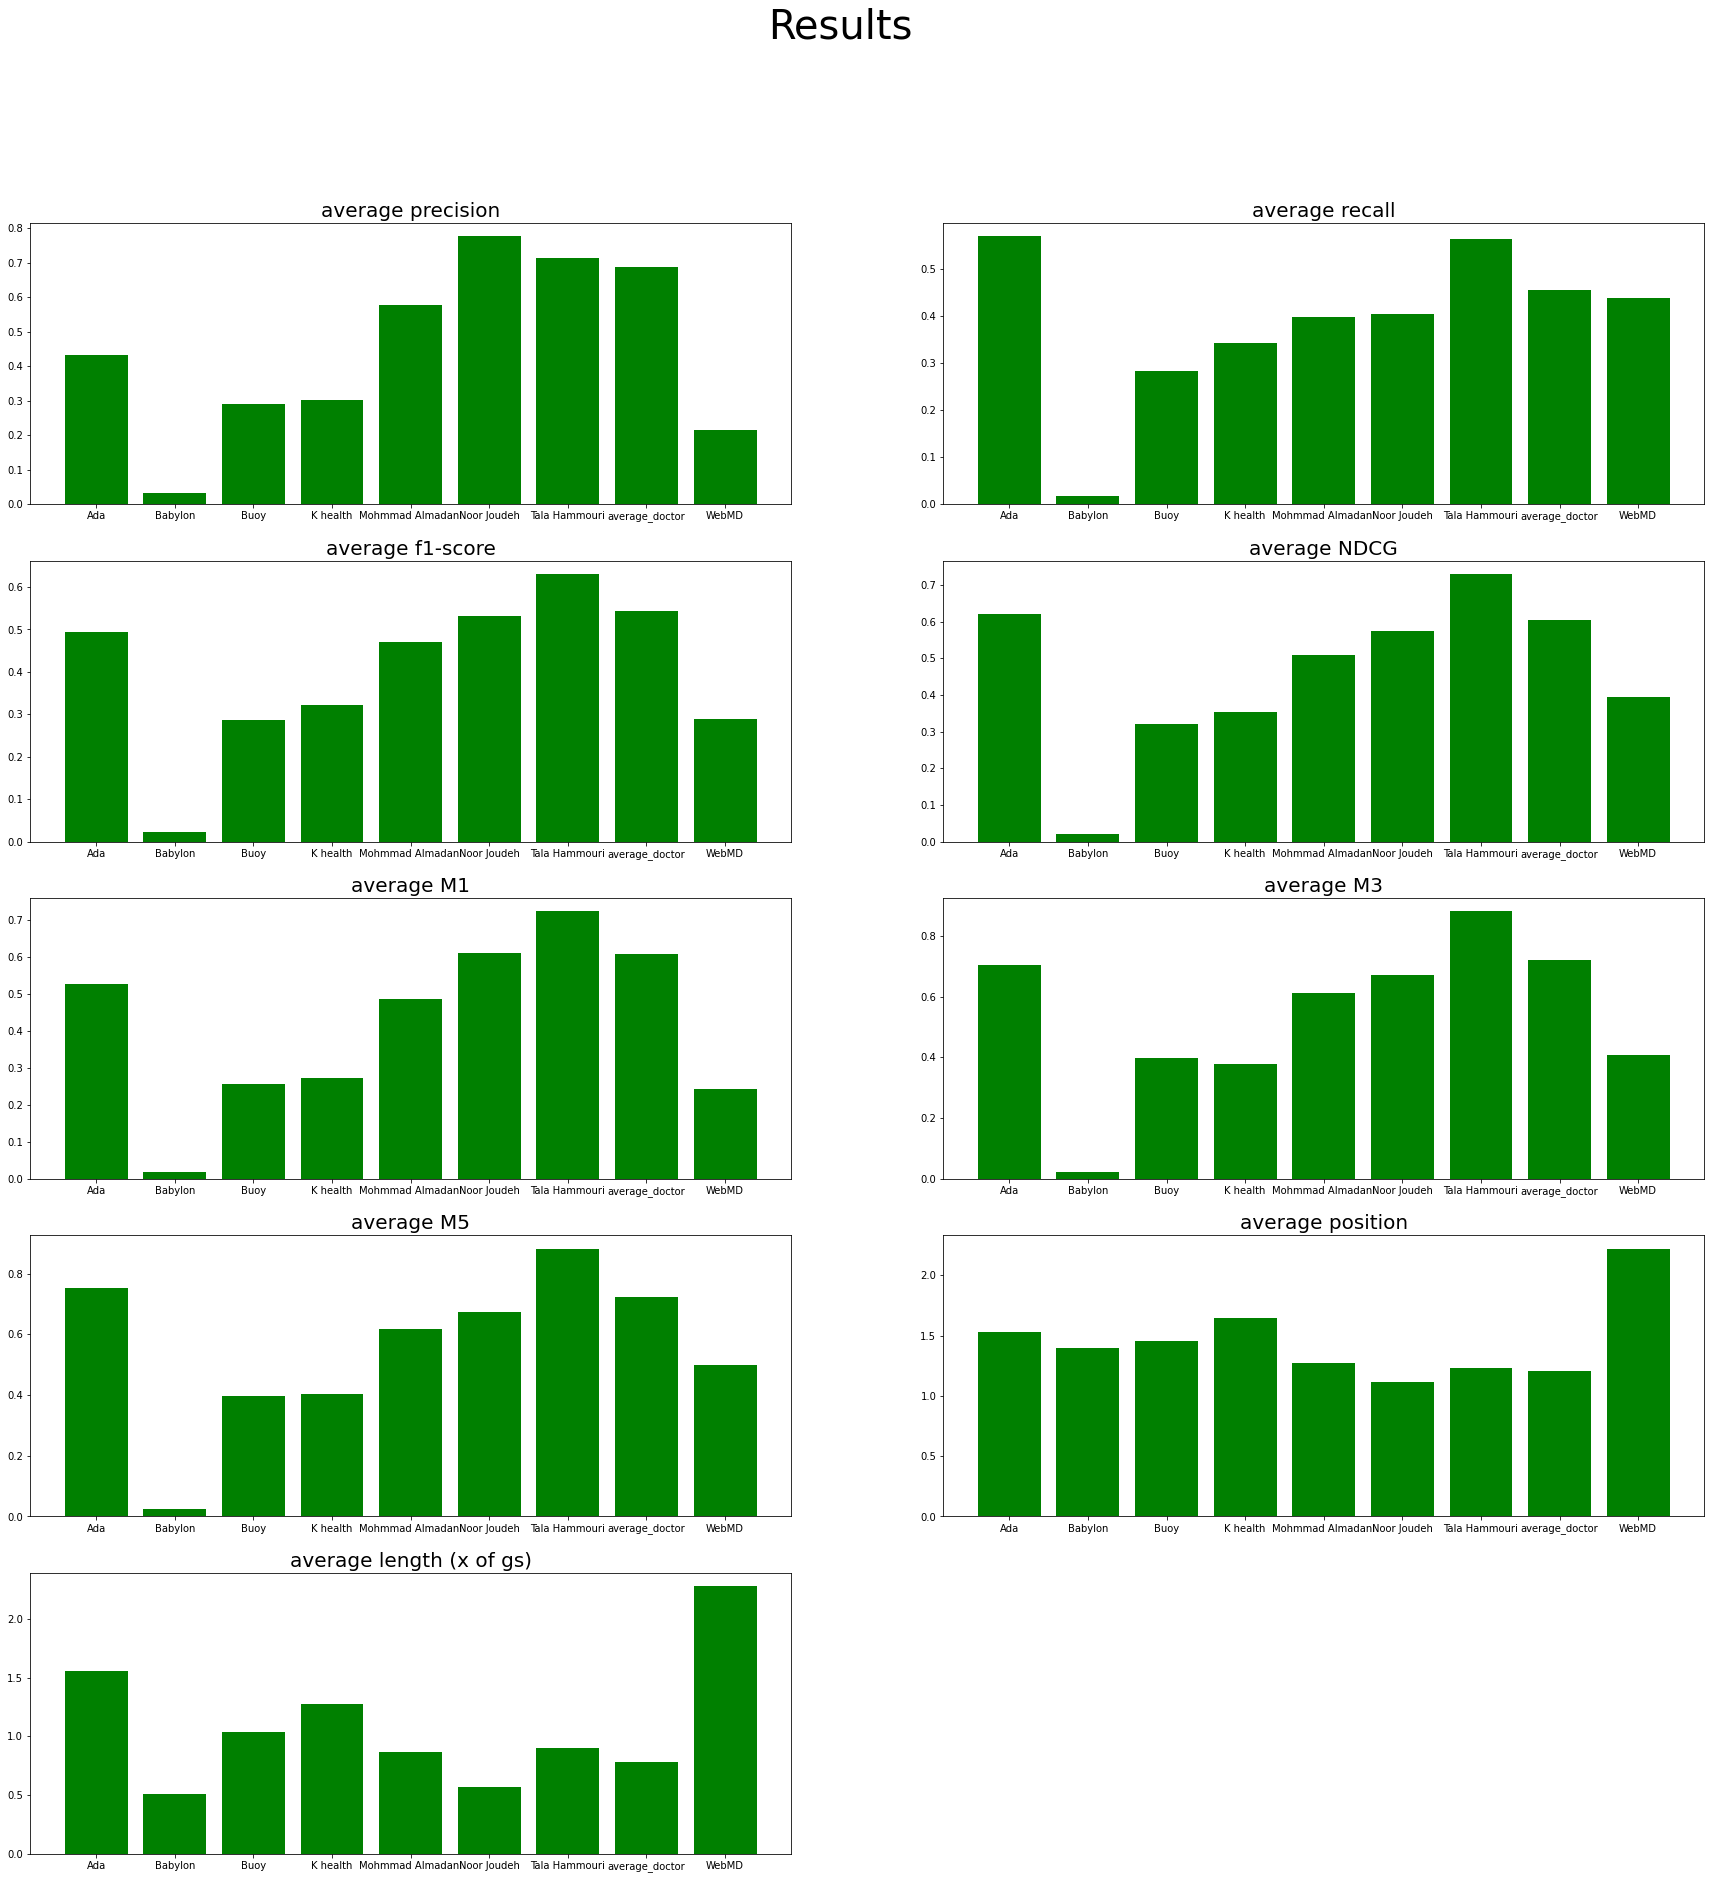

In [25]:
import matplotlib.pyplot as plt
import math

scoresToCompare = pd.DataFrame(averageScores,columns=averageScores.columns)

fig, subplots = plt.subplots(5,2, figsize=(30,30))
fig.suptitle("Results",fontsize=40)

for index, metric in enumerate(scoresToCompare.index.values.tolist()):
    subplots[index//2, index %
             2].bar(scoresToCompare.columns, averageScores.loc[metric],color="green")
    subplots[index//2, index % 2].set_title(metric.replace("_"," "),fontsize=20)


fig.delaxes(subplots[4,1])
plt.show()
averageScores.to_csv(path_or_buf="results.csv",sep=";")
